# Baixando dataset e Importando bibliotecas

In [1]:
!pip install category_encoders
!pip install optuna
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.1 MB/s eta 0:00:00


In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Pré-processamento e modelagem
import category_encoders as ce
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

# Otimização
import optuna

# Interpretabilidade
import shap


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
files = {'Base_maior': '1FHETSjlddxUq4woDtXWQGGh5ui-_GHEY',
         'Base_menor': '1gECQm3UN3GR_NPm8s_ZDO8nwn_OQ_bVC'
        }
# https://drive.google.com/file/d/1FHETSjlddxUq4woDtXWQGGh5ui-_GHEY/view?usp=sharing
# https://drive.google.com/file/d/1gECQm3UN3GR_NPm8s_ZDO8nwn_OQ_bVC/view?usp=sharing
for nome_arquivo, id in files.items():
    if not os.path.exists(nome_arquivo):
        !gdown --id {id} -O {nome_arquivo}
    else:
        continue

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1FHETSjlddxUq4woDtXWQGGh5ui-_GHEY
From (redirected): https://drive.google.com/uc?id=1FHETSjlddxUq4woDtXWQGGh5ui-_GHEY&confirm=t&uuid=f3cfaff5-c26a-4cc1-a68a-16f639563bd6
To: /content/Base_maior
100% 181M/181M [00:03<00:00, 57.5MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gECQm3UN3GR_NPm8s_ZDO8nwn_OQ_bVC
To: /content/Base_menor
100% 68.3M/68.3M [00:01<00:00, 57.0MB/s]


In [6]:
df = pd.read_csv('Base_maior')
base_oot = pd.read_csv('Base_menor')

# Análise exploratória

In [125]:
df_desenvolvimento = df.copy()

##  Informações da Base de Dados

In [126]:
print(f"Dimensões: {df_desenvolvimento.shape[0]} linhas x {df_desenvolvimento.shape[0]} colunas\n")
print(f"Tipos de dados:")
df_desenvolvimento.dtypes.value_counts()

Dimensões: 99104 linhas x 99104 colunas

Tipos de dados:


float64    333
int64        3
object       3
Name: count, dtype: int64

In [127]:
df_desenvolvimento.head()

id  safra_concessao  adimplencia regiao faixa_idade     faixa_renda  vp_1  \
0   1           202310            1  NORTE   41 ATÉ 45  9000 ATÉ 10000   0.0   
1   2           202306            1  NORTE   41 ATÉ 45  9000 ATÉ 10000   0.0   
2   3           202311            1  NORTE   41 ATÉ 45  9000 ATÉ 10000   0.0   
3   4           202301            1  NORTE   41 ATÉ 45  9000 ATÉ 10000   0.0   
4   5           202308            1  NORTE   41 ATÉ 45  9000 ATÉ 10000   0.0   

   vp_2   vp_3  vp_4        vp_5        vp_6        vp_7    vp_8  vp_9  vp_10  \
0   0.0  152.0   0.0   82.611830  100.150327  176.929001   355.0  19.0   23.0   
1   0.0  151.0   0.0    0.000000    0.000000    0.000000     0.0  17.0   22.0   
2   0.0  174.0   0.0  121.642746  119.774002  200.000000   959.0  24.0   27.0   
3   0.0  101.0   1.0  160.358690  172.628494  157.690018  4389.0  18.0   23.0   
4   0.0   79.0   1.0  103.956220  120.336091  135.227055   565.0  18.0   23.0   

   vp_11     vp_12      vp_13      vp_14      vp_15  vp_16  vp_17  vp_18  \
0   51.0  6.928766   0.000000   0.000000   0.000000    0.0   52.0  353.0   
1   56.0  0.000000   0.000000   0.000000   0.000000    0.0   44.0  311.0   
2   62.0  2.206758  22.386469  85.050828  83.151543   71.5   57.0  256.0   
3   56.0  0.000000   0.182127   0.147196   0.208389    0.2   61.0  389.0   
4   58.0  0.148492   2.973459   2.333763   1.419896    2.2   44.0  395.0   

   vp_19  vp_20  vp_21    vp_22    vp_23    vp_24    vp_25   vp_26   vp_27  \
0  369.0  401.0  545.0  1.07693  0.33333  0.86434  0.92364  4178.0   300.0   
1  308.0  354.0  610.0  1.03695  0.41503  1.12201  1.22509     0.0     0.0   
2  258.0  311.0  520.0  1.04864  0.49918  1.56638  1.72516  4554.0  2784.0   
3  386.0  449.0  606.0  1.03117  0.60332  1.65910  1.87013  3813.0  1276.0   
4  390.0  436.0  616.0  1.03995  0.55323  1.69467  1.87983  5522.0   496.0   

   vp_28   vp_29       vp_30       vp_31  vp_32   vp_33   vp_34  vp_35  \
0   46.0     6.0  100.000000  100.000000  12.50  121.30  126.04    0.0   
1    0.0     0.0    0.000000    0.000000   0.00    0.00    0.00    0.0   
2  552.0   108.0   33.333332   41.666668  66.67    0.00   37.55    2.0   
3  843.0  1026.0  100.000000  100.000000  50.00  179.12  136.53    0.0   
4  149.0   130.0   93.333336   96.551730  20.00  145.52  150.56  214.0   

    vp_36   vp_37   vp_38  vp_39  vp_40  vp_41     vp_42     vp_43  vp_44  \
0  1000.0  1000.0     0.0  521.0   23.0   23.0  1.212300  1.766634    1.0   
1     0.0     0.0     0.0    1.0    0.0    0.0  1.000000  1.000000    0.0   
2   347.0     0.0     0.0  941.0   48.0   48.0  0.984637  1.701742    0.0   
3  1000.0  1000.0  1000.0  567.0  261.0  261.0  1.076515  0.913465    0.0   
4   885.0   720.0   775.0  556.0   36.0  102.0  1.157565  1.123745    0.0   

   vp_45  vp_46       vp_47  vp_48  vp_49  vp_50    vp_51    vp_52  vp_53  \
0   21.0   40.0  68980000.0    0.0    0.0    0.0  0.98781  0.05930   10.0   
1    0.0    0.0  69900613.0    0.0    0.0    0.0  0.91562  0.04922    4.0   
2    5.0    8.0  69028140.0    0.0    0.0    0.0  0.91100  0.03921   10.0   
3    6.0   12.0  69058120.0    0.0   20.0    0.0  1.00320  0.05347    6.0   
4   14.0   30.0  69050190.0    0.0    0.0    0.0  0.99982  0.06959    3.0   

   vp_54  vp_55    vp_56    vp_57  vp_58  vp_59     vp_60     vp_61    vp_62  \
0   62.0   94.0   8576.0  68878.0   24.0   13.0  1.316687  2.000000  35972.0   
1    0.0  124.0   8485.0  52802.0   18.0    0.0  1.000000  1.000000      0.0   
2    0.0  103.0   4495.0  40030.0   26.0    0.0  0.933029  0.987458      0.0   
3  100.0  107.0   8767.0  79254.0   24.0    0.0  1.000000  1.000000      0.0   
4    0.0  102.0  10937.0  96255.0   28.0    0.0  1.000000  1.000000      0.0   

      vp_63  vp_64    vp_65  vp_66  vp_67  vp_68  vp_69    vp_70  vp_71  \
0  83.77936    0.0  1.44480   33.0    0.0    0.0    0.0  0.73256  100.0   
1   0.00000    0.0  1.30715   34.0    0.0    0.0    0.0  0.62055    0.0   
2   0.00000    0.0  1.56931   45

##  Valores Nulos

In [128]:
print(f"Total de colunas com valores nulos: {df_desenvolvimento.isnull().any().sum()}")

Total de colunas com valores nulos: 72


In [129]:
colunas_com_nulos = df_desenvolvimento.columns[df_desenvolvimento.isnull().any()]
print(f" Colunas com nulos:\n {colunas_com_nulos}")

 Colunas com nulos:
 Index(['vp_262', 'vp_263', 'vp_264', 'vp_265', 'vp_266', 'vp_267', 'vp_268',
       'vp_269', 'vp_270', 'vp_271', 'vp_272', 'vp_273', 'vp_274', 'vp_275',
       'vp_276', 'vp_277', 'vp_278', 'vp_279', 'vp_280', 'vp_281', 'vp_282',
       'vp_283', 'vp_284', 'vp_285', 'vp_286', 'vp_287', 'vp_288', 'vp_289',
       'vp_290', 'vp_291', 'vp_292', 'vp_293', 'vp_294', 'vp_295', 'vp_296',
       'vp_297', 'vp_298', 'vp_299', 'vp_300', 'vp_301', 'vp_302', 'vp_303',
       'vp_304', 'vp_305', 'vp_306', 'vp_307', 'vp_308', 'vp_309', 'vp_310',
       'vp_311', 'vp_312', 'vp_313', 'vp_314', 'vp_315', 'vp_316', 'vp_317',
       'vp_318', 'vp_319', 'vp_320', 'vp_321', 'vp_322', 'vp_323', 'vp_324',
       'vp_325', 'vp_326', 'vp_327', 'vp_328', 'vp_329', 'vp_330', 'vp_331',
       'vp_332', 'vp_333'],
      dtype='object')


In [130]:
max_nulos = df_desenvolvimento.isnull().sum().max()
print(f"Valor máximo de valores nulos em uma coluna: {max_nulos}")

Valor máximo de valores nulos em uma coluna: 1


In [131]:
linhas_com_nulos = df_desenvolvimento.isnull().any(axis=1).sum()
print(f"Linhas com valores nulos: {linhas_com_nulos}")

Linhas com valores nulos: 1


Como as colunas com valores nulos apresentam apenas um único valor ausente, e todos localizados na mesma linha, existem duas alternativas possíveis para o tratamento: excluir essa linha do conjunto de dados ou preencher os valores faltantes utilizando a mediana da respectiva coluna.

##  Perfil Geral dos clientes

### Contagem de clientes por região

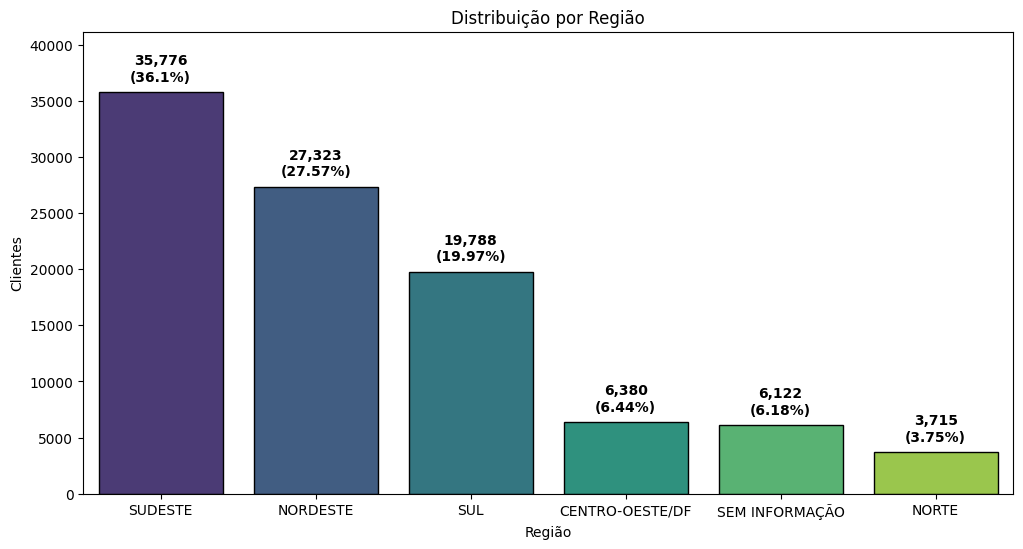

In [132]:
# Contagem da coluna regiao
contagens = df_desenvolvimento["regiao"].value_counts().reset_index()
contagens.columns = ["regiao", "frequencia"]
contagens["percentual"] = (contagens["frequencia"] / contagens["frequencia"].sum() * 100).round(2)

# Gráfico
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=contagens,
    x="regiao",
    y="frequencia",
    palette=sns.color_palette("viridis", len(contagens)),
    edgecolor="black"
)

# Ajusta limite do eixo Y (10% a mais do máximo)
max_freq = contagens["frequencia"].max()
plt.ylim(0, max_freq * 1.15)

# Adicionar rótulos em cima das barras
for i, row in contagens.iterrows():
    ax.text(
        i,
        row["frequencia"] + (max_freq * 0.02),  # desloca um pouco acima da barra
        f'{row["frequencia"]:,}\n({row["percentual"]}%)',
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.title("Distribuição por Região")
plt.xlabel("Região")
plt.ylabel("Clientes")
plt.show()

### Contagem de clientes por faixa etária

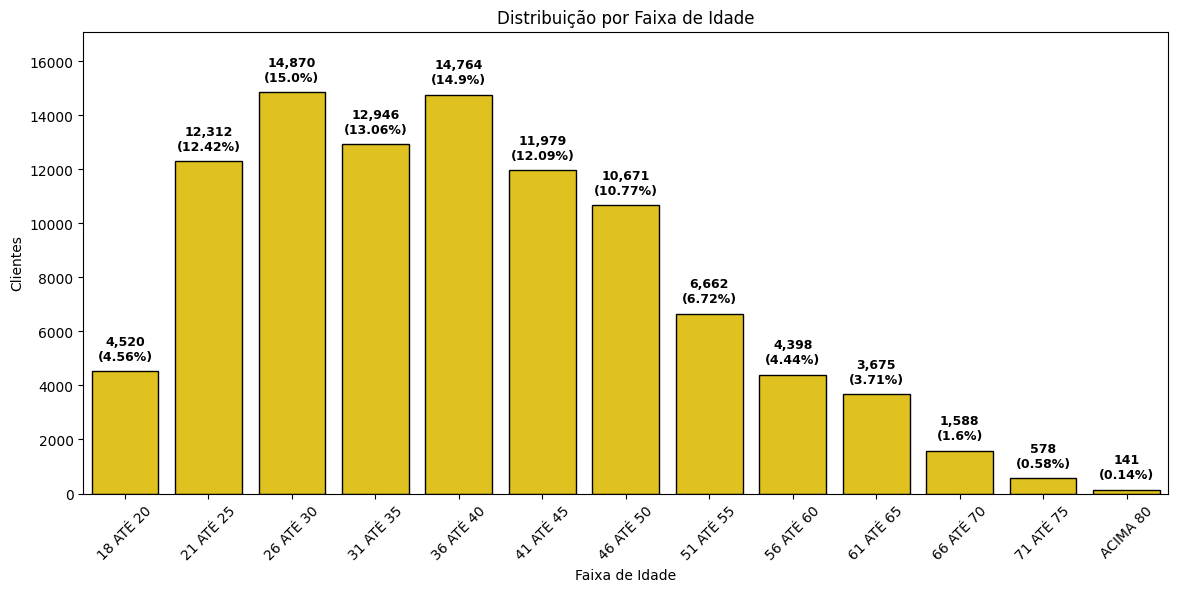

In [133]:
# Definindo a ordem das faixas etárias manualmente
ordem_idade = [
    "18 ATÉ 20",
    "21 ATÉ 25",
    "26 ATÉ 30",
    "31 ATÉ 35",
    "36 ATÉ 40",
    "41 ATÉ 45",
    "46 ATÉ 50",
    "51 ATÉ 55",
    "56 ATÉ 60",
    "61 ATÉ 65",
    "66 ATÉ 70",
    "71 ATÉ 75",
    "ACIMA 80"
]

# Contagem da coluna faixa_idade
contagens = df_desenvolvimento["faixa_idade"].value_counts().reindex(ordem_idade).dropna().reset_index()
contagens.columns = ["faixa_idade", "frequencia"]
contagens["percentual"] = (contagens["frequencia"] / contagens["frequencia"].sum() * 100).round(2)

# Gráfico
plt.figure(figsize=(14,6))
ax = sns.barplot(
    data=contagens,
    x="faixa_idade",
    y="frequencia",
    order=ordem_idade,  # <<< força a ordem desejada
    color="gold",
    edgecolor="black"
)

# Ajusta limite do eixo Y
max_freq = contagens["frequencia"].max()
plt.ylim(0, max_freq * 1.15)

# Adicionar rótulos em cima das barras
for i, row in contagens.iterrows():
    ax.text(
        i,
        row["frequencia"] + (max_freq * 0.02),
        f'{row["frequencia"]:,}\n({row["percentual"]}%)',
        ha="center", va="bottom", fontsize=9, fontweight="bold"
    )

plt.title("Distribuição por Faixa de Idade")
plt.xlabel("Faixa de Idade")
plt.ylabel("Clientes")
plt.xticks(rotation=45)
plt.show()

### Contagem de clientes por faixa de renda

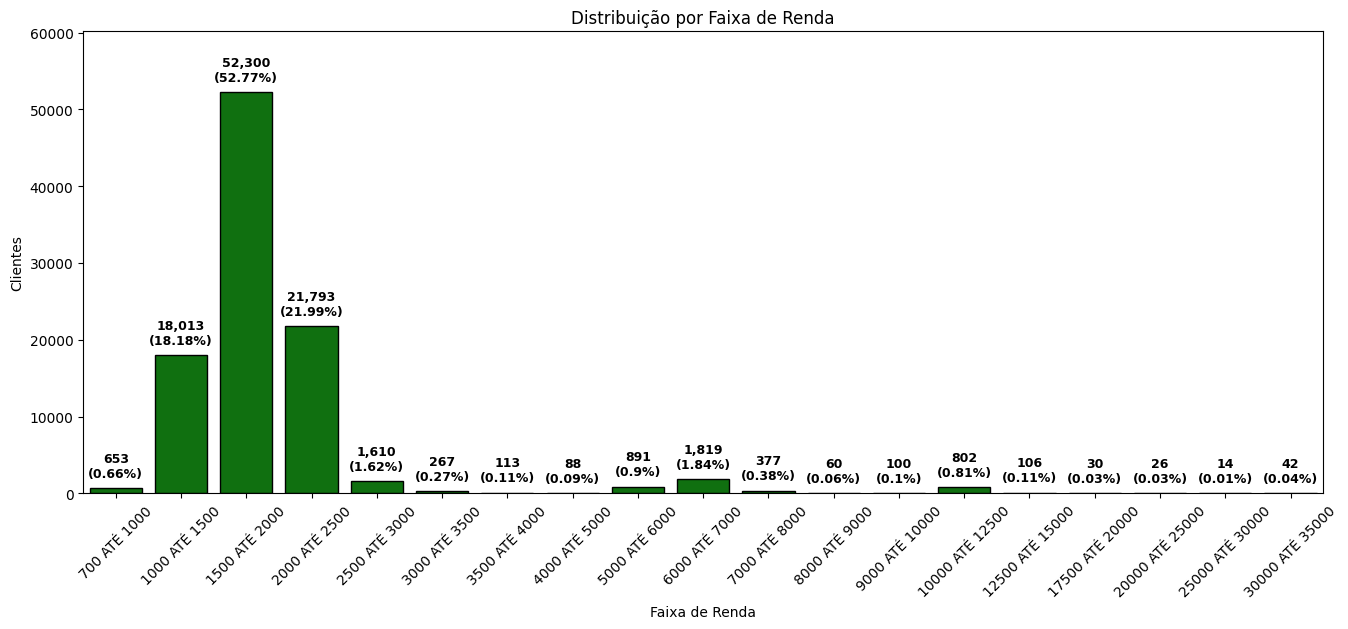

In [134]:
ordem_renda = [
    "700 ATÉ 1000",
    "1000 ATÉ 1500",
    "1500 ATÉ 2000",
    "2000 ATÉ 2500",
    "2500 ATÉ 3000",
    "3000 ATÉ 3500",
    "3500 ATÉ 4000",
    "4000 ATÉ 5000",
    "5000 ATÉ 6000",
    "6000 ATÉ 7000",
    "7000 ATÉ 8000",
    "8000 ATÉ 9000",
    "9000 ATÉ 10000",
    "10000 ATÉ 12500",
    "12500 ATÉ 15000",
    "17500 ATÉ 20000",
    "20000 ATÉ 25000",
    "25000 ATÉ 30000",
    "30000 ATÉ 35000"
]

# Contagem da coluna faixa_renda
contagens = df_desenvolvimento["faixa_renda"].value_counts().reindex(ordem_renda).dropna().reset_index()
contagens.columns = ["faixa_renda", "frequencia"]
contagens["percentual"] = (contagens["frequencia"] / contagens["frequencia"].sum() * 100).round(2)

# Gráfico
plt.figure(figsize=(16,6))
ax = sns.barplot(
    data=contagens,
    x="faixa_renda",
    y="frequencia",
    order=ordem_renda,
    color="green",
    edgecolor="black"
)

# Ajusta limite do eixo Y
max_freq = contagens["frequencia"].max()
plt.ylim(0, max_freq * 1.15)

# Adicionar rótulos em cima das barras
for i, row in contagens.iterrows():
    ax.text(
        i,
        row["frequencia"] + (max_freq * 0.02),
        f'{row["frequencia"]:,}\n({row["percentual"]}%)',
        ha="center", va="bottom", fontsize=9, fontweight="bold"
    )

plt.title("Distribuição por Faixa de Renda")
plt.xlabel("Faixa de Renda")
plt.ylabel("Clientes")
plt.xticks(rotation=45)
plt.show()

##  Evolução temporal Inadimplência

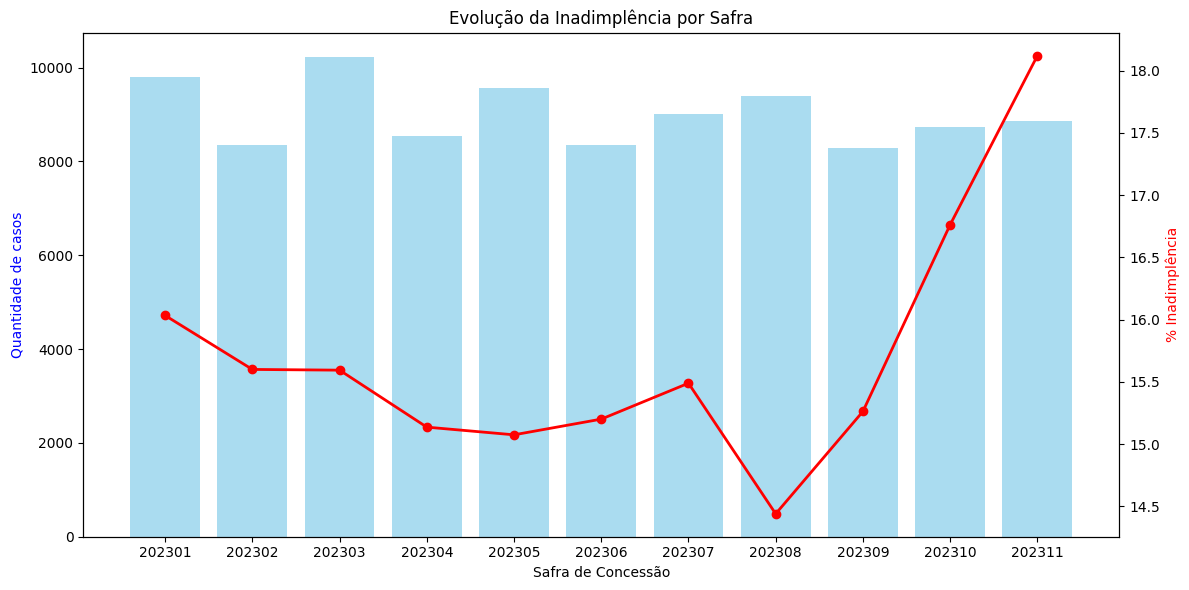

In [135]:
# Exemplo: df_desenvolvimento já carregado
# Calcular métricas por safra
agg = df_desenvolvimento.groupby("safra_concessao").agg(
    total=("id", "count"),
    inadimplentes=("adimplencia", "sum")
).reset_index()

agg["perc_inadimplencia"] = (1 - (agg["inadimplentes"] / agg["total"])) * 100

# Ordenar por safra
agg = agg.sort_values("safra_concessao")

# Converter safra para string (categórico)
agg["safra_concessao"] = agg["safra_concessao"].astype(str)

# Gráfico novamente
fig, ax1 = plt.subplots(figsize=(12,6))

# Barras - contagem
ax1.bar(agg["safra_concessao"], agg["total"], color="skyblue", alpha=0.7)
ax1.set_xlabel("Safra de Concessão")
ax1.set_ylabel("Quantidade de casos", color="blue")

# Linha - % inadimplência
ax2 = ax1.twinx()
ax2.plot(agg["safra_concessao"], agg["perc_inadimplencia"], color="red", marker="o", linewidth=2)
ax2.set_ylabel("% Inadimplência", color="red")

# Títulos e layout
plt.title("Evolução da Inadimplência por Safra")
plt.xticks(rotation=45)  # deixa os rótulos mais legíveis
plt.tight_layout()
plt.show()

##  Taxa de Inadimplência por perfil

Baixa renda (até R$2500) = alto risco → consistente com literatura de crédito.

Jovens = alto risco → falta de histórico de crédito, instabilidade laboral.

Diferenças regionais → podem refletir desigualdades econômicas estruturais, políticas locais de crédito ou perfis de consumo.

Picos específicos em idades mais altas podem indicar problemas de aposentadoria, endividamento acumulado ou saúde financeira fragilizada

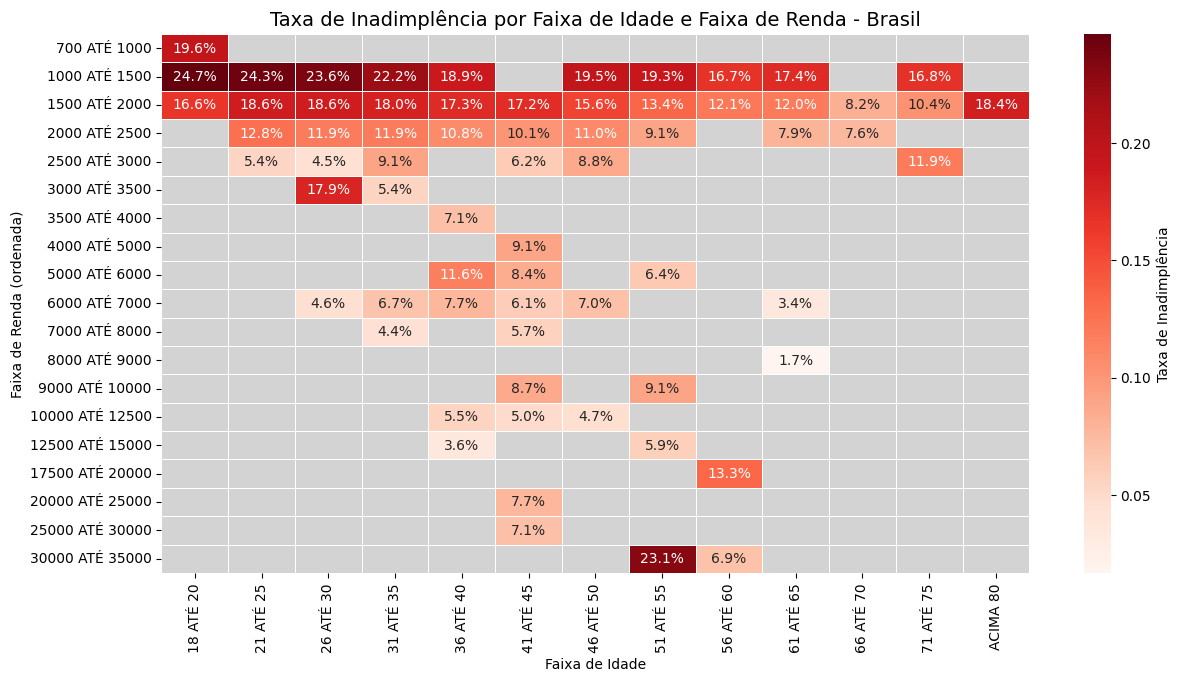

In [136]:
# Calcular taxa de inadimplência
tabela = (
    df_desenvolvimento
    .groupby(["faixa_idade", "faixa_renda"])
    .agg(
        inadimplentes=("adimplencia", "sum"),
        total=("adimplencia", "count")
    )
    .reset_index()
)
tabela["taxa_inadimplencia"] = 1 - (tabela["inadimplentes"] / tabela["total"])

# Extrair limite inferior das faixas de renda (caso seja "ACIMA", colocar um número alto)
def extrair_min(r):
    if "ACIMA" in r:
        return 999999  # joga no final
    else:
        return int(r.split()[0])  # pega o primeiro número

tabela["faixa_renda_min"] = tabela["faixa_renda"].apply(extrair_min)

# Criar ordem personalizada para eixo Y
ordem_renda = (
    tabela.drop_duplicates("faixa_renda")
    .sort_values("faixa_renda_min")
    ["faixa_renda"]
    .tolist()
)

# Pivot com categorias ordenadas
tabela["faixa_renda"] = pd.Categorical(tabela["faixa_renda"], categories=ordem_renda, ordered=True)
heatmap_data = tabela.pivot(index="faixa_renda", columns="faixa_idade", values="taxa_inadimplencia")

# Plot com fundo cinza
plt.figure(figsize=(14,7))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1%",
    cmap="Reds",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={'label': 'Taxa de Inadimplência'},
    mask=heatmap_data.isnull()
)

plt.gca().set_facecolor("lightgrey")
plt.title("Taxa de Inadimplência por Faixa de Idade e Faixa de Renda - Brasil", fontsize=14)
plt.xlabel("Faixa de Idade")
plt.ylabel("Faixa de Renda (ordenada)")
plt.show()

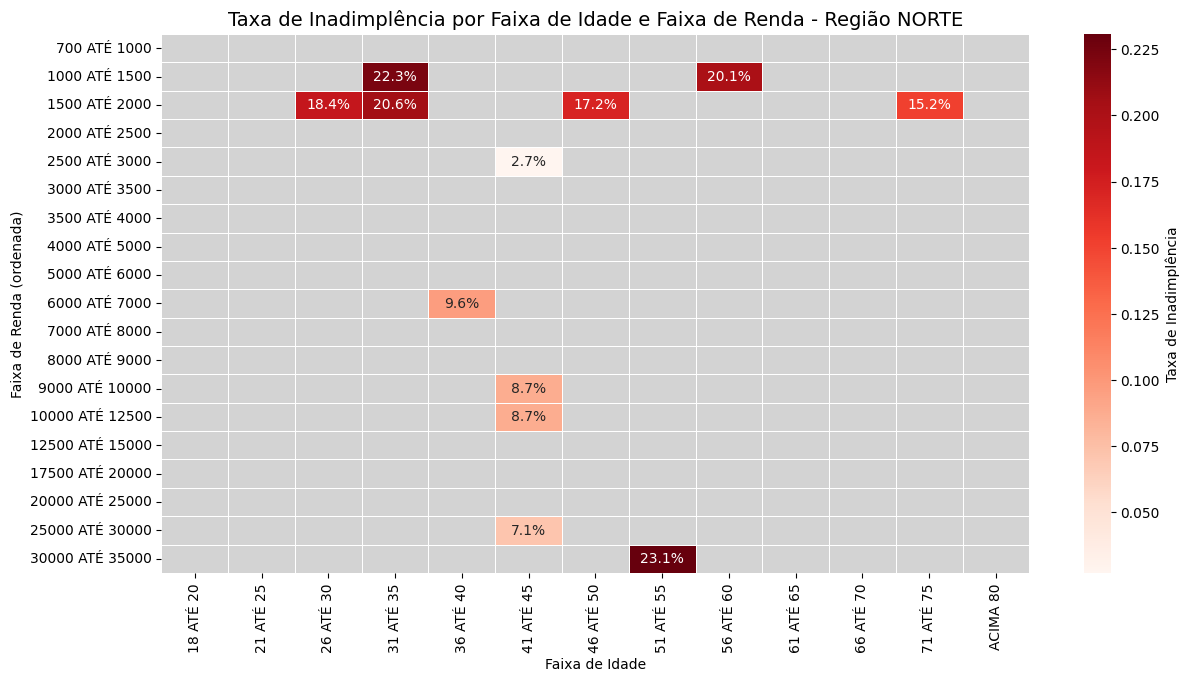

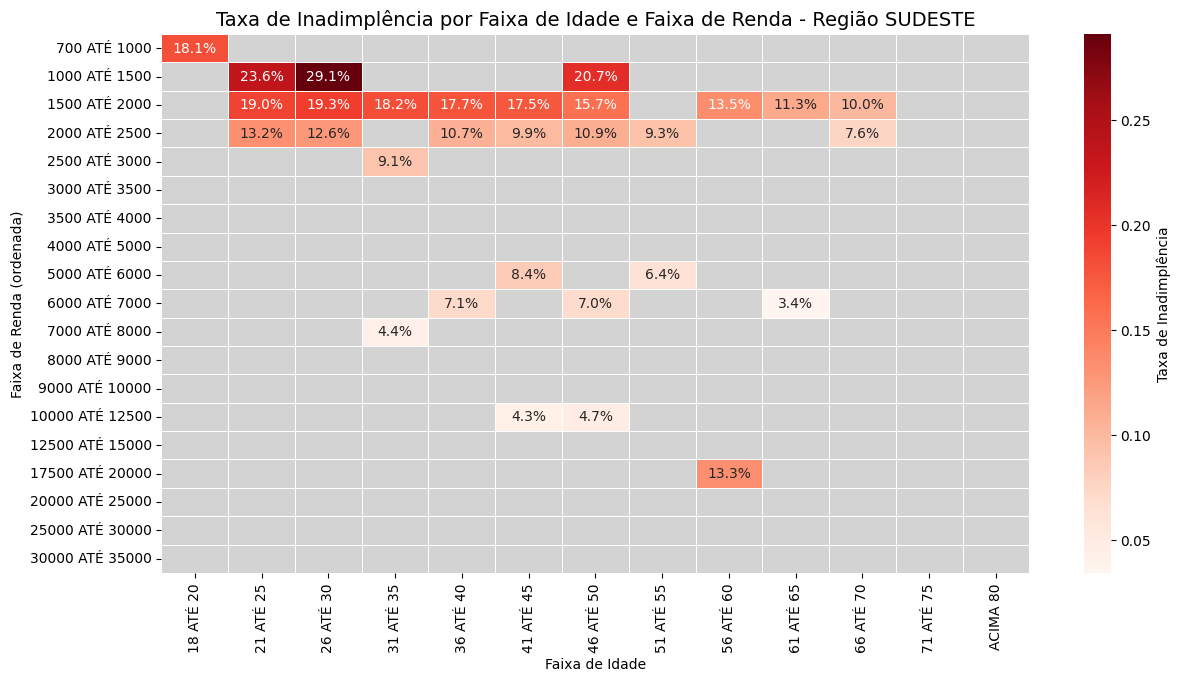

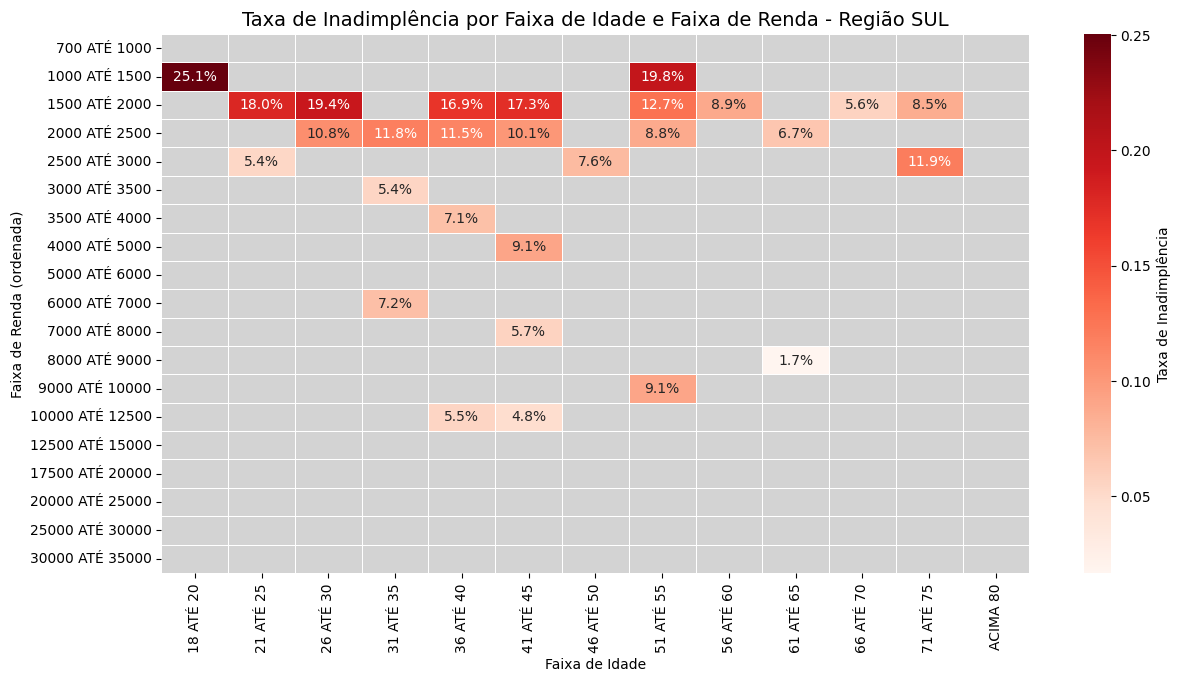

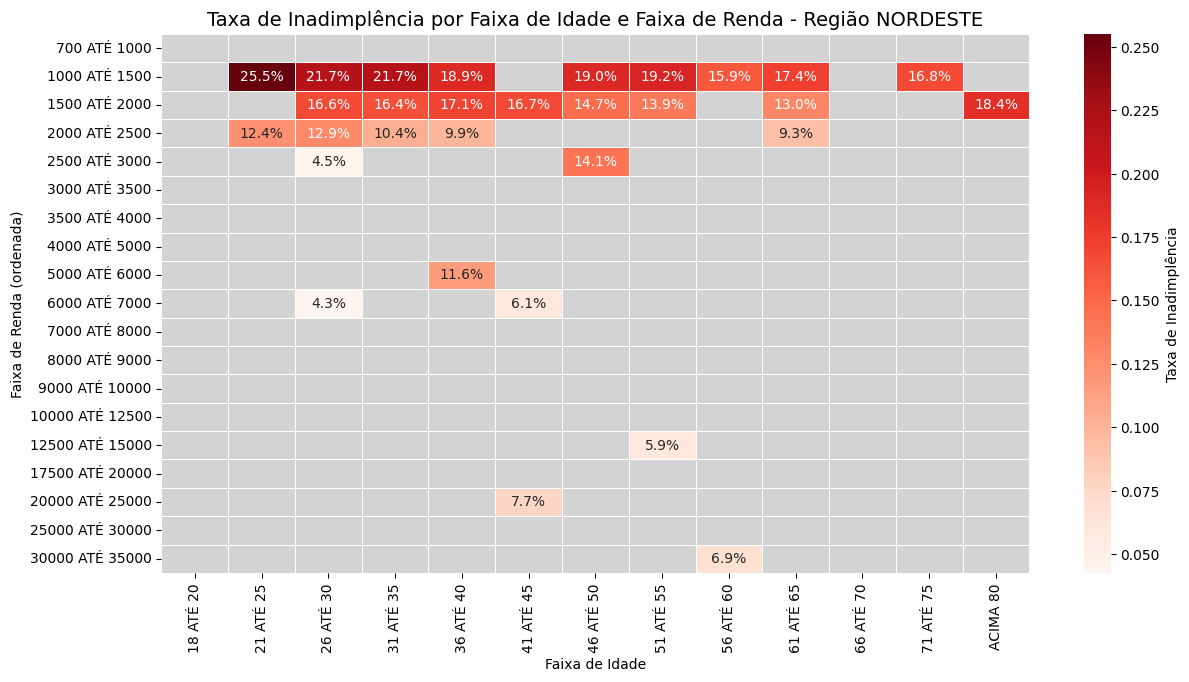

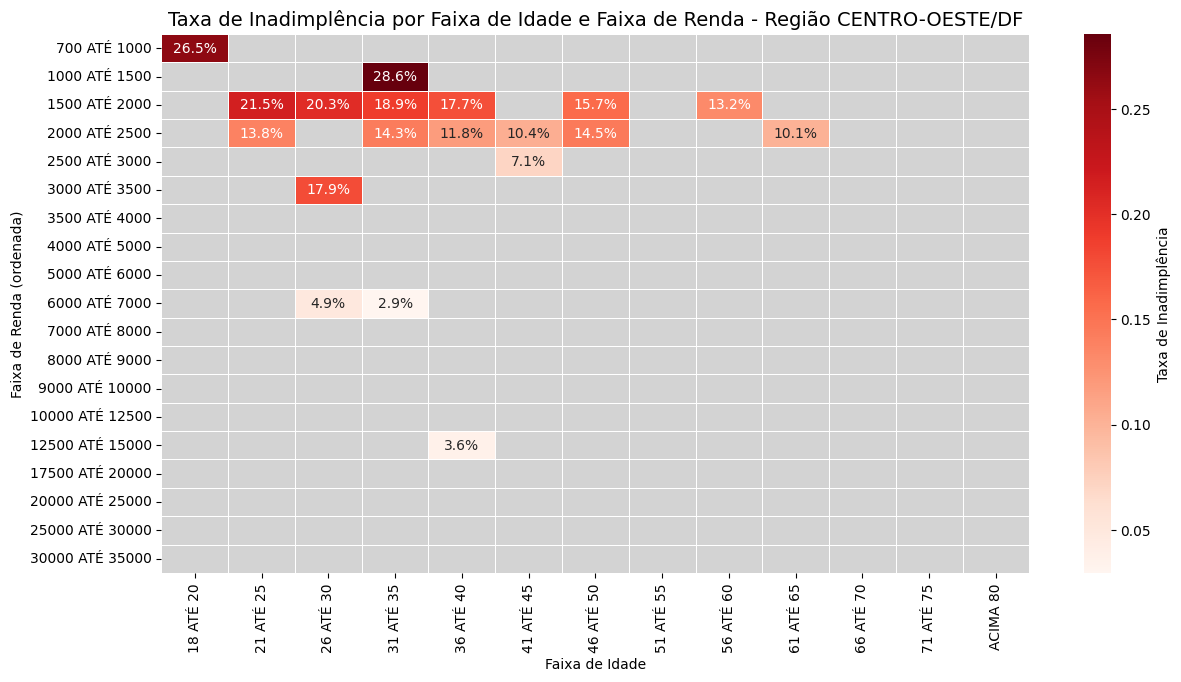

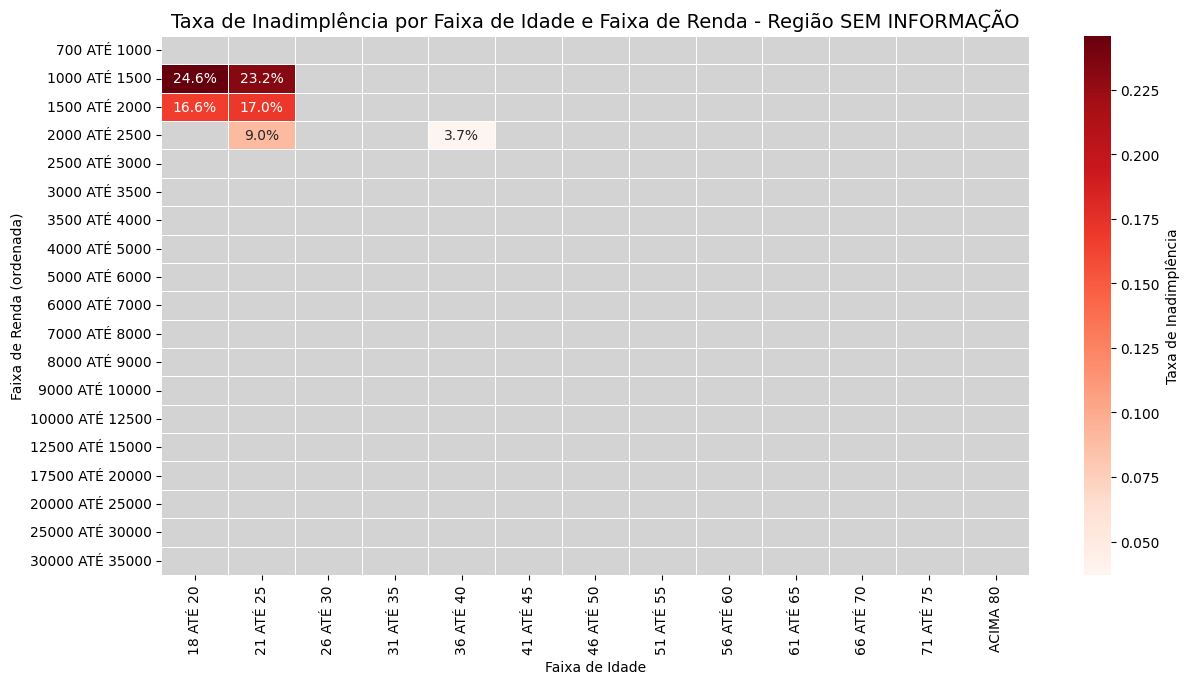

In [137]:
# Extrair todas as categorias de faixa de renda e idade do dataset original
def extrair_min(r):
    if "ACIMA" in r:
        return 999999
    else:
        return int(r.split()[0])

# Ordenação das faixas de renda
df_desenvolvimento["faixa_renda_min"] = df_desenvolvimento["faixa_renda"].apply(extrair_min)
ordem_renda = (
    df_desenvolvimento.drop_duplicates("faixa_renda")
    .sort_values("faixa_renda_min")["faixa_renda"]
    .tolist()
)

# Ordenação das faixas de idade (pelo menor número inicial, exceto "ACIMA")
def extrair_min_idade(r):
    if "ACIMA" in r:
        return 999999
    else:
        return int(r.split()[0])

df_desenvolvimento["faixa_idade_min"] = df_desenvolvimento["faixa_idade"].apply(extrair_min_idade)
ordem_idade = (
    df_desenvolvimento.drop_duplicates("faixa_idade")
    .sort_values("faixa_idade_min")["faixa_idade"]
    .tolist()
)

# Função para calcular e plotar heatmap por região
def plot_heatmap_por_regiao(df, regiao, ordem_renda, ordem_idade):
    df_regiao = df[df["regiao"] == regiao]

    tabela = (
        df_regiao
        .groupby(["faixa_idade", "faixa_renda"])
        .agg(
            inadimplentes=("adimplencia", "sum"),
            total=("adimplencia", "count")
        )
        .reset_index()
    )
    tabela["taxa_inadimplencia"] = 1 - (tabela["inadimplentes"] / tabela["total"])

    # Garantir categorias completas
    tabela["faixa_renda"] = pd.Categorical(tabela["faixa_renda"], categories=ordem_renda, ordered=True)
    tabela["faixa_idade"] = pd.Categorical(tabela["faixa_idade"], categories=ordem_idade, ordered=True)

    # Pivot reindexado
    heatmap_data = tabela.pivot(index="faixa_renda", columns="faixa_idade", values="taxa_inadimplencia")
    heatmap_data = heatmap_data.reindex(index=ordem_renda, columns=ordem_idade)

    # Plot
    plt.figure(figsize=(14,7))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".1%",
        cmap="Reds",
        linewidths=0.5,
        linecolor="white",
        cbar_kws={'label': 'Taxa de Inadimplência'},
        mask=heatmap_data.isnull()
    )
    plt.gca().set_facecolor("lightgrey")
    plt.title(f"Taxa de Inadimplência por Faixa de Idade e Faixa de Renda - Região {regiao}", fontsize=14)
    plt.xlabel("Faixa de Idade")
    plt.ylabel("Faixa de Renda (ordenada)")
    plt.show()

# Loop em todas as regiões
for reg in df_desenvolvimento["regiao"].unique():
    plot_heatmap_por_regiao(df_desenvolvimento, reg, ordem_renda, ordem_idade)

In [138]:
tabela_md = """
### 📊 Diferença entre Média Simples e Média Ponderada

| Característica        | Média Simples 🟦 | Média Ponderada 🟩 |
|------------------------|------------------|-------------------|
| **Definição**          | Soma das taxas dividido pelo número de grupos. | Soma das taxas multiplicadas pelo tamanho de cada grupo, dividido pelo total. |
| **Peso dos grupos**    | Todos os grupos têm o mesmo peso. | Grupos maiores têm mais peso, grupos menores têm menos. |
| **Exemplo prático**    | Faixa com 100 casos conta igual a faixa com 10.000 casos. | Faixa com 10.000 casos influencia muito mais do que a faixa com 100. |
| **Interpretação**       | Para comparar **faixas entre si**, sem influência do tamanho. | Para obter a **taxa real global** da base de clientes. |
"""

display(Markdown(tabela_md))


### 📊 Diferença entre Média Simples e Média Ponderada

| Característica        | Média Simples 🟦 | Média Ponderada 🟩 |
|------------------------|------------------|-------------------|
| **Definição**          | Soma das taxas dividido pelo número de grupos. | Soma das taxas multiplicadas pelo tamanho de cada grupo, dividido pelo total. |
| **Peso dos grupos**    | Todos os grupos têm o mesmo peso. | Grupos maiores têm mais peso, grupos menores têm menos. |
| **Exemplo prático**    | Faixa com 100 casos conta igual a faixa com 10.000 casos. | Faixa com 10.000 casos influencia muito mais do que a faixa com 100. |
| **Interpretação**       | Para comparar **faixas entre si**, sem influência do tamanho. | Para obter a **taxa real global** da base de clientes. |


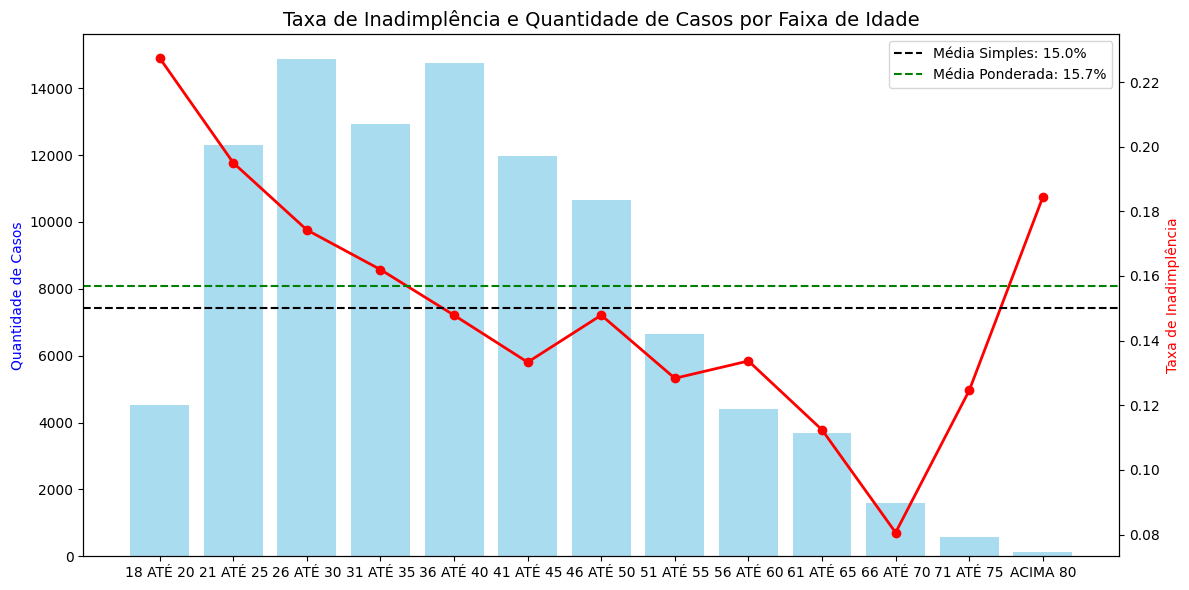

In [139]:
# Calcular taxa de inadimplência por faixa de idade
tabela_idade = (
    df_desenvolvimento
    .groupby("faixa_idade")
    .agg(
        inadimplentes=("adimplencia", "sum"),
        total=("adimplencia", "count")
    )
    .reset_index()
)

tabela_idade["taxa_inadimplencia"] = 1 - (tabela_idade["inadimplentes"] / tabela_idade["total"])

# Ordenar faixas de idade
def extrair_min_idade(r):
    if "ACIMA" in r:
        return 999999
    else:
        return int(r.split()[0])

tabela_idade["faixa_idade_min"] = tabela_idade["faixa_idade"].apply(extrair_min_idade)
tabela_idade = tabela_idade.sort_values("faixa_idade_min")

# Calcular médias
media_simples = tabela_idade["taxa_inadimplencia"].mean()
media_ponderada = 1 - (tabela_idade["inadimplentes"].sum() / tabela_idade["total"].sum())

# Plot com eixo duplo
fig, ax1 = plt.subplots(figsize=(12,6))

# Barras - contagem
ax1.bar(
    tabela_idade["faixa_idade"],
    tabela_idade["total"],
    color="skyblue",
    alpha=0.7
)
ax1.set_ylabel("Quantidade de Casos", color="blue")

# Linha - taxa de inadimplência
ax2 = ax1.twinx()
ax2.plot(
    tabela_idade["faixa_idade"],
    tabela_idade["taxa_inadimplencia"],
    marker="o",
    color="red",
    linewidth=2
)
ax2.set_ylabel("Taxa de Inadimplência", color="red")

# Linhas tracejadas de médias
ax2.axhline(media_simples, color="black", linestyle="--", linewidth=1.5, label=f"Média Simples: {media_simples:.1%}")
ax2.axhline(media_ponderada, color="green", linestyle="--", linewidth=1.5, label=f"Média Ponderada: {media_ponderada:.1%}")

# Legenda
ax2.legend(loc="upper right")

# Layout
plt.title("Taxa de Inadimplência e Quantidade de Casos por Faixa de Idade", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

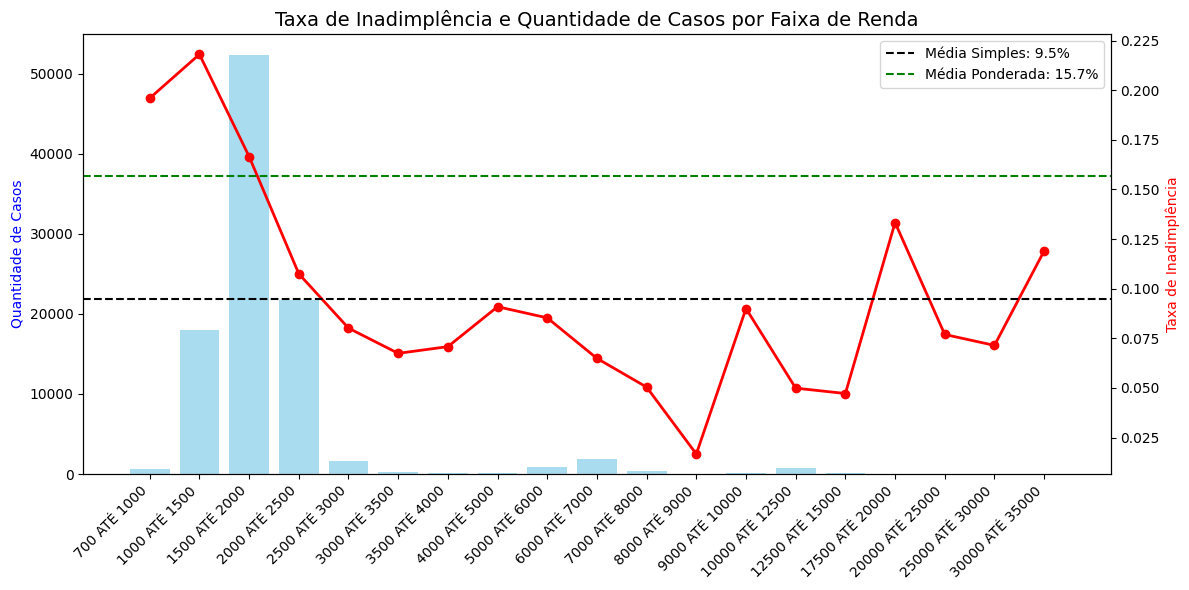

In [140]:
# Calcular taxa de inadimplência por faixa de renda
tabela_renda = (
    df_desenvolvimento
    .groupby("faixa_renda")
    .agg(
        inadimplentes=("adimplencia", "sum"),
        total=("adimplencia", "count")
    )
    .reset_index()
)

tabela_renda["taxa_inadimplencia"] = 1 - (tabela_renda["inadimplentes"] / tabela_renda["total"])

# Ordenar faixas de renda
def extrair_min_renda(r):
    if "ACIMA" in r:
        return 999999
    else:
        return int(r.split()[0])

tabela_renda["faixa_renda_min"] = tabela_renda["faixa_renda"].apply(extrair_min_renda)
tabela_renda = tabela_renda.sort_values("faixa_renda_min")

# Calcular médias
media_simples = tabela_renda["taxa_inadimplencia"].mean()
media_ponderada = 1 - (tabela_renda["inadimplentes"].sum() / tabela_renda["total"].sum())

# Plot com eixo duplo
fig, ax1 = plt.subplots(figsize=(12,6))

# Barras - contagem
ax1.bar(
    tabela_renda["faixa_renda"],
    tabela_renda["total"],
    color="skyblue",
    alpha=0.7
)
ax1.set_ylabel("Quantidade de Casos", color="blue")

# Rotacionar rótulos do eixo X
ax1.set_xticklabels(tabela_renda["faixa_renda"], rotation=45, ha="right")

# Linha - taxa de inadimplência
ax2 = ax1.twinx()
ax2.plot(
    tabela_renda["faixa_renda"],
    tabela_renda["taxa_inadimplencia"],
    marker="o",
    color="red",
    linewidth=2
)
ax2.set_ylabel("Taxa de Inadimplência", color="red")

# Linhas tracejadas das médias
ax2.axhline(media_simples, color="black", linestyle="--", linewidth=1.5, label=f"Média Simples: {media_simples:.1%}")
ax2.axhline(media_ponderada, color="green", linestyle="--", linewidth=1.5, label=f"Média Ponderada: {media_ponderada:.1%}")

# Legenda
ax2.legend(loc="upper right")

# Layout
plt.title("Taxa de Inadimplência e Quantidade de Casos por Faixa de Renda", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [141]:
media_ponderada = 1 - (tabela_idade["inadimplentes"].sum() / tabela_idade["total"].sum())
print(f"Média ponderada global: {media_ponderada:.2%}")

Média ponderada global: 15.70%


##  Análise de estabilidade (PSI)

O PSI (Population Stability Index) é uma métrica usada principalmente em ciência de dados, estatística e risco de crédito para medir a estabilidade de uma distribuição ao longo do tempo. Usada para valores contínuos.

### Separando as safras que serão utilizadas para treino e teste

In [142]:
treino = df_desenvolvimento.query("202301 <= safra_concessao <= 202308")
teste = df_desenvolvimento.query("202309 <= safra_concessao <= 202311")

treino = treino.drop(columns=["faixa_idade_min", "faixa_renda_min"])
teste = teste.drop(columns=["faixa_idade_min", "faixa_renda_min"])

### Cálculo do PSI

In [143]:
# Função para calcular o PSI
def calculate_psi(expected, actual, buckets=10):
    """
    Calcula o PSI entre duas distribuições.
    expected: array ou Series (baseline)
    actual: array ou Series (nova distribuição)
    buckets: número de faixas (bins) para discretizar
    """
    # cria bins com base na baseline
    breakpoints = np.linspace(0, 100, buckets + 1)
    cut_points = np.percentile(expected, breakpoints)

    expected_counts = np.histogram(expected, bins=cut_points)[0]
    actual_counts = np.histogram(actual, bins=cut_points)[0]

    # converte em proporções
    expected_perc = expected_counts / len(expected)
    actual_perc = actual_counts / len(actual)

    # evita divisão por zero
    expected_perc = np.where(expected_perc == 0, 0.0001, expected_perc)
    actual_perc = np.where(actual_perc == 0, 0.0001, actual_perc)

    psi = np.sum((expected_perc - actual_perc) * np.log(expected_perc / actual_perc))
    return psi

In [144]:
# Análise dos resultados obtidos
variaveis = [col for col in treino.columns if col.startswith("vp_")]
resultados = {}

for var in variaveis:
    baseline = treino[var].dropna()
    atual = teste[var].dropna()
    resultados[var] = calculate_psi(baseline, atual)

df_psi = pd.DataFrame.from_dict(resultados, orient="index", columns=["PSI"])
# df_resultados

**- PSI < 0.1 (Estável):**
Mudanças pequenas na população são esperadas, por exemplo sazonalidade ou ruído. Considera-se que a distribuição está suficientemente próxima da original.

**- 0.1 ≤ PSI < 0.25 (Moderado):**
Já indica que a população mudou o bastante para merecer atenção. Não necessariamente significa que o modelo está ruim, mas pode afetar performance em breve.

**- PSI ≥ 0.25 (Instável):**
Mudança muito forte na população. Normalmente é sinal de que o modelo deve ser recalibrado ou substituído, porque as condições de produção não se parecem mais com o treino.

In [145]:
# Classificação automática
def classificar_psi(valor):
    if valor < 0.1:
        return "Estável"
    elif valor < 0.25:
        return "Moderado"
    else:
        return "Instável"

df_psi["Classificação"] = df_psi["PSI"].apply(classificar_psi)

In [146]:
df_psi['Classificação'].value_counts()

Classificação
Estável     309
Moderado     13
Instável     11
Name: count, dtype: int64

##  Information Value e Weight of Evidence (WOE)

O Weight of Evidence (WOE) é uma medida que mostra quanto cada categoria ou faixa de uma variável contribui para distinguir entre bons e maus (ex.: adimplentes e inadimplentes). Ele é calculado como o logaritmo da razão entre a proporção de bons e a proporção de maus em cada grupo: valores positivos indicam maior concentração de bons e negativos, maior concentração de maus.

Já o Information Value (IV) resume o poder preditivo de uma variável como um todo, combinando os WOE de cada faixa. Ele reflete a capacidade da variável de separar bons e maus: valores muito baixos indicam variáveis fracas, valores intermediários indicam variáveis úteis, e valores altos indicam variáveis fortes, embora valores acima de 0.5 possam sugerir risco de overfitting.

In [147]:
warnings.filterwarnings("ignore")

### Variáveis Categóricas (Região, Faixa Idade e Faixa Renda)

In [148]:
def woe_iv(data, feature, target):
    """
    Calcula WOE e IV para uma variável categórica.
    feature: variável preditora (categórica ou binned)
    target: variável resposta binária (0 = mau, 1 = bom)
    """
    df = data.groupby(feature)[target].agg(['count','sum'])
    df.columns = ['total','goods']   # agora a soma representa bons (1)
    df['bads'] = df['total'] - df['goods']

    # Distribuições relativas
    dist_goods = df['goods'] / df['goods'].sum()
    dist_bads = df['bads'] / df['bads'].sum()

    # Evita problemas de log(0)
    dist_goods = dist_goods.replace(0, 0.0001)
    dist_bads = dist_bads.replace(0, 0.0001)

    # WOE
    df['WOE'] = np.log(dist_goods / dist_bads)

    # IV
    df['IV'] = (dist_goods - dist_bads) * df['WOE']
    iv_total = df['IV'].sum()

    return df[['total','goods','bads','WOE','IV']], iv_total

In [149]:
# Variáveis categóricas para análise
variaveis_categoricas = ["regiao", "faixa_idade", "faixa_renda"]

# Dicionário de resultados
resultados = {}

for var in variaveis_categoricas:
    tabela, iv_total = woe_iv(treino, var, "adimplencia")
    resultados[var] = {"IV_total": iv_total, "detalhes": tabela}

# Resumo dos IV totais
iv_resumo = pd.DataFrame({k: v["IV_total"] for k,v in resultados.items()}, index=["IV_total"]).T
print("Resumo de IV por variável (treino):")
print(iv_resumo)

# Exemplo: detalhamento de uma variável
print("\nDetalhes para 'faixa_renda':")
print(resultados["faixa_renda"]["detalhes"])

Resumo de IV por variável (treino):
             IV_total
regiao       0.021031
faixa_idade  0.045769
faixa_renda  0.109304

Detalhes para 'faixa_renda':
                 total  goods  bads       WOE        IV
faixa_renda                                            
1000 ATÉ 1500    13566  10680  2886 -0.400684  0.034016
10000 ATÉ 12500    576    547    29  1.227968  0.007661
12500 ATÉ 15000     76     75     1  2.608303  0.002923
1500 ATÉ 2000    38588  32367  6221 -0.059977  0.001935
17500 ATÉ 20000     23     21     2  0.642190  0.000103
2000 ATÉ 2500    15866  14193  1673  0.428945  0.034250
20000 ATÉ 25000     20     18     2  0.488039  0.000055
2500 ATÉ 3000     1199   1098   101  0.676940  0.005896
25000 ATÉ 30000     11     10     1  0.593400  0.000043
3000 ATÉ 3500      190    175    15  0.747551  0.001111
30000 ATÉ 35000     30     28     2  0.929872  0.000254
3500 ATÉ 4000       75     68     7  0.564412  0.000267
4000 ATÉ 5000       66     60     6  0.593400  0.000257
5000 A

### Variáveis contínuas (vp_*), que foram agregadas em bins (faixas)

In [150]:
def woe_iv_binned(data, feature, target, bins=10):
    """
    Calcula WOE e IV para variável contínua após binning por quantis.
    target binário: 0 = mau (inadimplente), 1 = bom (adimplente).
    """
    # Cria os bins (quantis)
    data = data[[feature, target]].copy()
    try:
        data["bin"] = pd.qcut(data[feature], q=bins, duplicates="drop")
    except ValueError:
        # Se a variável tiver poucos valores distintos
        data["bin"] = data[feature]

    # Conta bons e maus por bin
    df = data.groupby("bin")[target].agg(['count','sum'])
    df.columns = ['total','goods']   # agora sum() representa bons (1)
    df['bads'] = df['total'] - df['goods']

    # Distribuições relativas
    dist_goods = df['goods'] / df['goods'].sum()
    dist_bads  = df['bads']  / df['bads'].sum()

    dist_goods = dist_goods.replace(0, 0.0001)
    dist_bads  = dist_bads.replace(0, 0.0001)

    # Calcula WOE e IV
    df['WOE'] = np.log(dist_goods / dist_bads)
    df['IV']  = (dist_goods - dist_bads) * df['WOE']

    iv_total = df['IV'].sum()
    return df[['total','goods','bads','WOE','IV']], iv_total

In [151]:
# Seleciona as variáveis contínuas (vp_*)
variaveis_continuas = [col for col in treino.columns if col.startswith("vp_")]

# Calcula IV para cada variável contínua
resultados_vp = {}
for var in variaveis_continuas:
    tabela, iv_total = woe_iv_binned(treino, var, "adimplencia", bins=10)
    resultados_vp[var] = {"IV_total": iv_total, "detalhes": tabela}

# Resumo de IVs
iv_resumo_vp = pd.DataFrame({k: v["IV_total"] for k,v in resultados_vp.items()}, index=["IV_total"]).T
iv_resumo_vp = iv_resumo_vp.sort_values("IV_total", ascending=False)

print("Resumo de IV para variáveis contínuas (vp_*):")
print(iv_resumo_vp.head(20))  # mostra as 20 mais preditivas

# Exemplo: detalhes de uma variável
print("\nDetalhes para", variaveis_continuas[0])
print(resultados_vp[variaveis_continuas[0]]["detalhes"])

Resumo de IV para variáveis contínuas (vp_*):
        IV_total
vp_232  0.250675
vp_30   0.150510
vp_36   0.149910
vp_89   0.146125
vp_31   0.141321
vp_203  0.139317
vp_40   0.138732
vp_34   0.134356
vp_91   0.133525
vp_27   0.131536
vp_33   0.131307
vp_92   0.129368
vp_46   0.127644
vp_45   0.123420
vp_26   0.123346
vp_201  0.122561
vp_249  0.118647
vp_8    0.118556
vp_94   0.112802
vp_39   0.104932

Detalhes para vp_1
                   total  goods   bads  WOE   IV
bin                                             
(-0.001, 66943.0]  73224  62001  11223  0.0  0.0


### Juntando as informações de ambas variáveis

In [152]:
df_iv = pd.concat([iv_resumo, iv_resumo_vp], axis=0)
df_iv = df_iv.sort_values("IV_total", ascending=False)

In [153]:
def classificar_iv(iv):
    """Interpreta o valor de IV."""
    if iv < 0.02:
        return 'sem poder preditivo'
    elif iv < 0.10:
        return 'fraco'
    elif iv < 0.30:
        return 'médio'
    elif iv < 0.50:
        return 'forte'
    else:
        return 'suspeito (revisar vazamento)'

df_iv["Classificação"] = df_iv["IV_total"].apply(classificar_iv)

# Visualizar top 35 variáveis com classificação
print(df_iv.head(35))
# Supondo que seu DataFrame se chama df_iv
linha_faixa_idade = df_iv.loc['faixa_idade']

print(linha_faixa_idade)

             IV_total Classificação
vp_232       0.250675         médio
vp_30        0.150510         médio
vp_36        0.149910         médio
vp_89        0.146125         médio
vp_31        0.141321         médio
vp_203       0.139317         médio
vp_40        0.138732         médio
vp_34        0.134356         médio
vp_91        0.133525         médio
vp_27        0.131536         médio
vp_33        0.131307         médio
vp_92        0.129368         médio
vp_46        0.127644         médio
vp_45        0.123420         médio
vp_26        0.123346         médio
vp_201       0.122561         médio
vp_249       0.118647         médio
vp_8         0.118556         médio
vp_94        0.112802         médio
faixa_renda  0.109304         médio
vp_39        0.104932         médio
vp_14        0.104597         médio
vp_95        0.102679         médio
vp_87        0.102071         médio
vp_88        0.101040         médio
vp_16        0.099843         fraco
vp_205       0.095242       

In [154]:
df_iv['Classificação'].value_counts()

Classificação
sem poder preditivo    175
fraco                  136
médio                   25
Name: count, dtype: int64

##  PSI + IV e WOE

De todas variáveis que analisamos, podemos nos passos a frente descartar as que apresentaram instabilidade quanto ao PSI e também as variáveis que foram classificadas como não tendo poder preditivo através do IV.

In [155]:
df_psi_ren = df_psi.rename(columns={"Classificação": "Classificação_PSI"})
df_iv_ren  = df_iv.rename(columns={"Classificação": "Classificação_IV"})

df_psi_iv = df_psi_ren.join(df_iv_ren, how="inner")

In [156]:
df_psi_iv

PSI Classificação_PSI  IV_total     Classificação_IV
vp_1    0.000000           Estável  0.000000  sem poder preditivo
vp_2    0.000924           Estável  0.008363  sem poder preditivo
vp_3    0.001934           Estável  0.014771  sem poder preditivo
vp_4    0.001569           Estável  0.005324  sem poder preditivo
vp_5    0.001807           Estável  0.066912                fraco
...          ...               ...       ...                  ...
vp_329  0.000492           Estável  0.000758  sem poder preditivo
vp_330  0.000747           Estável  0.000672  sem poder preditivo
vp_331  0.000211           Estável  0.000822  sem poder preditivo
vp_332  0.000405           Estável  0.001570  sem poder preditivo
vp_333  0.000483           Estável  0.001268  sem poder preditivo

[333 rows x 4 columns]

# Feature engineering e Seleção de variáveis

Para avaliar o poder discriminatório das variáveis em relação à adimplência, foi utilizada a métrica Information Value (IV), amplamente empregada em modelos de risco de crédito. O IV é derivado do Weight of Evidence (WOE), que mede a diferença entre a distribuição de bons (adimplentes) e maus (inadimplentes) dentro das categorias ou intervalos de cada variável. Quanto maior essa diferença, maior a capacidade da variável de separar os dois grupos, refletindo em maior poder discriminatório.

Na prática, o IV foi calculado para todas as variáveis numéricas e categóricas após eventuais binarizações ou agrupamentos. As variáveis foram ranqueadas de acordo com seus valores de IV, permitindo identificar aquelas com maior contribuição para a diferenciação entre pagadores e não-pagadores. Seguindo os referenciais de mercado, variáveis com IV abaixo de 0,02 foram classificadas como de poder preditivo irrelevante, entre 0,02 e 0,1 como de baixo poder, entre 0,1 e 0,3 como de bom poder e acima de 0,3 como muito fortes (embora potenciais indícios de sobreajuste também devam ser avaliados nesse último caso).

Complementarmente, foi analisada a estabilidade temporal das variáveis por meio do Population Stability Index (PSI), que quantifica a mudança na distribuição das variáveis entre diferentes períodos (safras). Esse indicador permite identificar variáveis que, embora apresentem poder discriminatório elevado, podem sofrer variações significativas ao longo do tempo e, portanto, comprometer a robustez e a capacidade de generalização do modelo. Variáveis com PSI inferior a 0,1 foram consideradas estáveis, entre 0,1 e 0,25 como de estabilidade moderada e acima de 0,25 como instáveis.

Dessa forma, a seleção de variáveis não foi pautada apenas pelo critério de maior poder discriminatório (IV), mas também pela sua estabilidade temporal (PSI). Assim, foram priorizadas variáveis que, simultaneamente, apresentassem capacidade de diferenciação entre adimplentes e inadimplentes e comportamento consistente ao longo do tempo, garantindo maior robustez ao modelo final.

Por fim, após a exclusão inicial das variáveis que não atendiam a esses requisitos, foi realizada uma análise de multicolinearidade. Variáveis altamente correlacionadas entre si foram ajustadas, mantendo-se apenas aquela com maior IV (e, em casos de IV semelhantes, a mais estável segundo o PSI). Esse processo assegurou que a base final de variáveis utilizadas no modelo fosse composta apenas por atributos relevantes, estáveis e não redundantes.

In [157]:
df_tratamento = df.copy()

##  Removendo variáveis que são instáveis segundo o PSI + variáveis sem poder preditivo de acordo com IV

In [158]:
df_psi_iv

PSI Classificação_PSI  IV_total     Classificação_IV
vp_1    0.000000           Estável  0.000000  sem poder preditivo
vp_2    0.000924           Estável  0.008363  sem poder preditivo
vp_3    0.001934           Estável  0.014771  sem poder preditivo
vp_4    0.001569           Estável  0.005324  sem poder preditivo
vp_5    0.001807           Estável  0.066912                fraco
...          ...               ...       ...                  ...
vp_329  0.000492           Estável  0.000758  sem poder preditivo
vp_330  0.000747           Estável  0.000672  sem poder preditivo
vp_331  0.000211           Estável  0.000822  sem poder preditivo
vp_332  0.000405           Estável  0.001570  sem poder preditivo
vp_333  0.000483           Estável  0.001268  sem poder preditivo

[333 rows x 4 columns]

In [159]:
variaveis_remover = df_psi_iv[
    (df_psi_iv["Classificação_PSI"] == "Instável") |
    (df_psi_iv["Classificação_IV"] == "sem poder preditivo")
].index.tolist()

In [160]:
print("Quantidade de variáveis que o modelo não considera importantes de acordo com indicativos de instabilidade e sem poder preditivo:")
print(len(variaveis_remover))

Quantidade de variáveis que o modelo não considera importantes de acordo com indicativos de instabilidade e sem poder preditivo:
179


In [161]:
treino = treino.drop(columns=variaveis_remover)
teste = teste.drop(columns=variaveis_remover)

In [162]:
print(treino.shape)
print(teste.shape)

(73224, 160)
(25880, 160)


##  Segunda Análise após resultados insatisfatórios no treinamento e teste:
Após a primeira filtragem, realizar nova filtragem mantendo somente as variáveis com Information Value maior que 0.07.

In [163]:
treino2 = treino.copy()
teste2 = teste.copy()

In [164]:
df_psi_iv_remover = df_psi_iv[(df_psi_iv["IV_total"] <= 0.04) | (df_psi_iv["Classificação_PSI"] != "Estável")]

In [165]:
indices_remover = df_psi_iv_remover.index.tolist()
print(len(indices_remover))

248


In [166]:
# Transformando os nomes das colunas em uma lista
colunas_df = treino2.columns.tolist()

In [167]:
# Converte as listas para conjuntos
set_a = set(indices_remover)
set_b = set(colunas_df)

# Encontra a interseção (elementos comuns) usando o operador &
elementos_comuns_set = set_a & set_b

# Se você precisar do resultado como uma lista, basta converter de volta
lista_comuns = list(elementos_comuns_set)
print(len(lista_comuns))

69


In [168]:
treino2 = treino2.drop(columns=lista_comuns)
teste2 = teste2.drop(columns=lista_comuns)

In [169]:
print(treino2.shape)
print(teste2.shape)

(73224, 91)
(25880, 91)


##  Análise da correlação

### Primeira Análise

Muitos dados na matriz de correlação, ruim para enxergar, mas é possível identificar que existem valores altamente correlacionados.

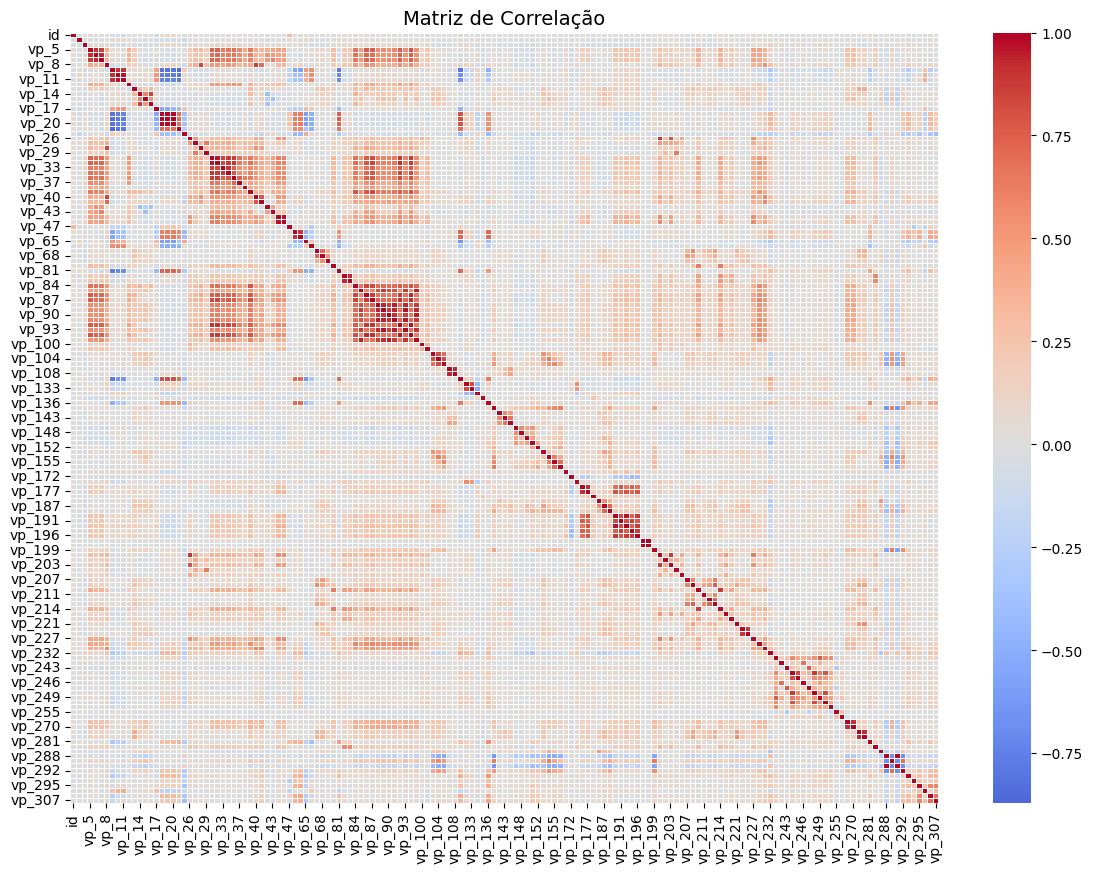

In [170]:
# Seleciona apenas colunas numéricas
df_num = treino.select_dtypes(include=[np.number])

# Calcula a matriz de correlação
corr = df_num.corr()

# Exibe como heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Matriz de Correlação", fontsize=14)
plt.show()

In [171]:
def listar_exclusoes_por_corr(df_num, iv_df, psi_df, limite=0.8, delta=0.01):
    """
    Retorna lista de variáveis a serem excluídas com base em:
    - correlação alta (|corr| > limite)
    - escolha pela variável com maior IV
    - em caso de empate (IV muito próximos), escolha pela variável mais estável (menor PSI).
    """
    corr_matrix = df_num.corr()
    corr_matrix_abs = corr_matrix.abs()

    altos_corr = np.where(corr_matrix_abs > limite)
    pares = [
        (corr_matrix.index[i], corr_matrix.columns[j], corr_matrix_abs.iloc[i, j])
        for i, j in zip(*altos_corr) if i < j
    ]

    excluir_set = set()
    sugestoes = []

    for v1, v2, corr in pares:
        iv1 = iv_df.loc[v1, "IV_total"] if v1 in iv_df.index else 0
        iv2 = iv_df.loc[v2, "IV_total"] if v2 in iv_df.index else 0
        psi1 = psi_df.loc[v1, "PSI"] if v1 in psi_df.index else 1
        psi2 = psi_df.loc[v2, "PSI"] if v2 in psi_df.index else 1

        # Critério 1: IV
        if abs(iv1 - iv2) > delta:
            if iv1 > iv2:
                manter, excluir = v1, v2
            else:
                manter, excluir = v2, v1
            criterio = "IV"
        else:
            # Critério 2: PSI
            if psi1 < psi2:
                manter, excluir = v1, v2
            else:
                manter, excluir = v2, v1
            criterio = "PSI"

        sugestoes.append({
            "var_1": v1, "iv_1": iv1, "psi_1": psi1,
            "var_2": v2, "iv_2": iv2, "psi_2": psi2,
            "correlacao": corr,
            "criterio": criterio,
            "manter": manter,
            "excluir": excluir
        })
        excluir_set.add(excluir)

    sugestoes_df = pd.DataFrame(sugestoes).sort_values("correlacao", ascending=False)
    return list(excluir_set), sugestoes_df

In [172]:
df_psi_aux = df_psi.copy()
df_psi_aux = df_psi_aux.drop(columns='Classificação')

In [173]:
# ========================
# Exemplo de uso
# ========================

excluir_vars, sugestoes_df = listar_exclusoes_por_corr(
    df_num, iv_resumo_vp, df_psi_aux, limite=0.8, delta=0.01
)

print("Variáveis a excluir:", excluir_vars[:30])  # mostra as 30 primeiras
print("Total de variáveis a excluir:", len(excluir_vars))

Variáveis a excluir: ['vp_210', 'vp_18', 'vp_291', 'vp_88', 'vp_95', 'vp_7', 'vp_201', 'vp_9', 'vp_36', 'vp_91', 'vp_107', 'vp_57', 'vp_92', 'vp_191', 'vp_195', 'vp_176', 'vp_21', 'vp_5', 'vp_133', 'vp_197', 'vp_224', 'vp_245', 'vp_192', 'vp_104', 'vp_190', 'vp_16', 'vp_86', 'vp_90', 'vp_84', 'vp_272']
Total de variáveis a excluir: 50


In [174]:
treino = treino.drop(columns=excluir_vars)
teste = teste.drop(columns=excluir_vars)

### Análise Pós primeiros resultados insatisfatórios

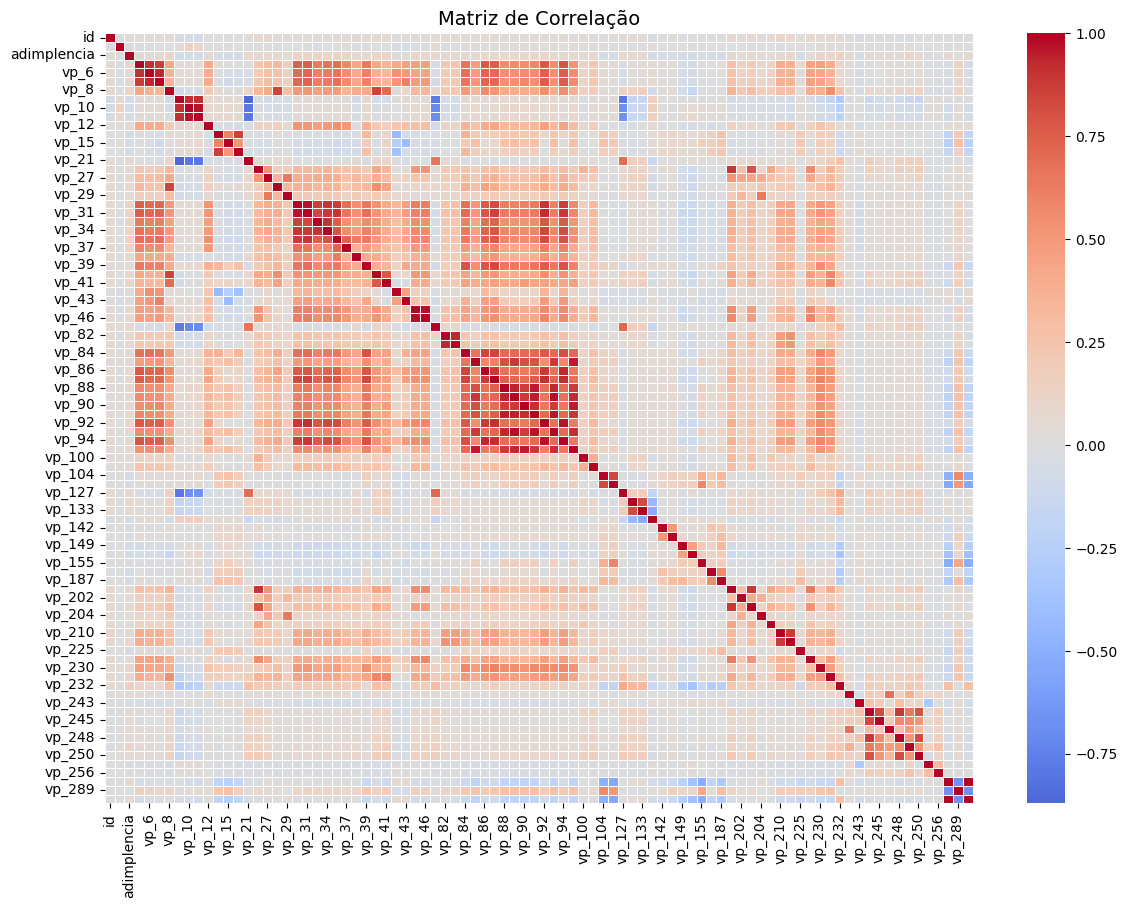

In [175]:
# Seleciona apenas colunas numéricas
df_num = treino2.select_dtypes(include=[np.number])

# Calcula a matriz de correlação
corr = df_num.corr()

# Exibe como heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Matriz de Correlação", fontsize=14)
plt.show()

In [176]:
# ========================
# Exemplo de uso
# ========================

excluir_vars, sugestoes_df = listar_exclusoes_por_corr(
    df_num, iv_resumo_vp, df_psi_aux, limite=0.8, delta=0.01
)

print("Variáveis a excluir:", excluir_vars[:10])  # mostra as 30 primeiras
print("Total de variáveis a excluir:", len(excluir_vars))

Variáveis a excluir: ['vp_210', 'vp_291', 'vp_88', 'vp_95', 'vp_7', 'vp_201', 'vp_9', 'vp_36', 'vp_91', 'vp_92']
Total de variáveis a excluir: 35


In [177]:
treino2 = treino2.drop(columns=excluir_vars)
teste2 = teste2.drop(columns=excluir_vars)

In [178]:
print(treino2.shape)
print(teste2.shape)

(73224, 56)
(25880, 56)


##  Ajustando colunas 'faixa_idade' e 'faixa_renda'

In [179]:
iv_resumo

IV_total
regiao       0.021031
faixa_idade  0.045769
faixa_renda  0.109304

In [180]:
resultados["faixa_idade"]["detalhes"]

total  goods  bads       WOE        IV
faixa_idade                                        
18 ATÉ 20     3303   2574   729 -0.447643  0.010493
21 ATÉ 25     9240   7462  1778 -0.274851  0.010464
26 ATÉ 30    11012   9124  1888 -0.133795  0.002819
31 ATÉ 35     9651   8156  1495 -0.012558  0.000021
36 ATÉ 40    10951   9362  1589  0.064369  0.000606
41 ATÉ 45     8717   7548  1169  0.155949  0.002741
46 ATÉ 50     7775   6692  1083  0.111993  0.001281
51 ATÉ 55     4911   4303   608  0.247708  0.003772
56 ATÉ 60     3192   2787   405  0.219649  0.001947
61 ATÉ 65     2725   2417   308  0.350997  0.004050
66 ATÉ 70     1150   1062    88  0.781387  0.007257
71 ATÉ 75      468    408    60  0.207737  0.000256
ACIMA 80       129    106    23 -0.181240  0.000062

### Faixa Renda

**Após realizar a análise exploratória, concluímos:**

Distribuição de clientes: mais de 90% dos clientes estão concentrados entre 1000 até 2500. As outras faixas têm participação quase irrelevante.

Taxa de inadimplência por faixa: as faixas mais baixas (até ~1500) têm inadimplência mais alta, mas há bastante ruído nas faixas com poucos clientes.

WOE/IV: só as faixas 1000–1500, 1500–2000, 2000–2500 e em menor grau 6000–7000 têm IV que passa do “mínimo aproveitável”. As demais são insignificantes (IV < 0.01).

**Estratégia de agrupamento**

O ideal é reduzir o número de categorias, preservando: Volume suficiente em cada grupo e a diferença de comportamento (inadimplência/WOE) entre grupos.

Baixa renda → até 1500: Representa grupo de maior inadimplência.

Renda média baixa → 1500 até 2500: Grande concentração da base, inadimplência intermediária.

Renda média/alta → 2500 até 7000: Pouca representatividade, mas comportamento parecido (IV baixo).

Alta renda → acima de 7000: Casos muito raros, pode ser agrupado para evitar colunas inúteis.

In [181]:
# Dicionário de mapeamento
mapa_faixa_renda = {
    # Baixa renda
    "700 ATÉ 1000": "<=1500",
    "1000 ATÉ 1500": "<=1500",

    # Renda média baixa
    "1500 ATÉ 2000": "1500–2500",
    "2000 ATÉ 2500": "1500–2500",

    # Renda média/alta
    "2500 ATÉ 3000": "2500–7000",
    "3000 ATÉ 3500": "2500–7000",
    "3500 ATÉ 4000": "2500–7000",
    "4000 ATÉ 5000": "2500–7000",
    "5000 ATÉ 6000": "2500–7000",
    "6000 ATÉ 7000": "2500–7000",

    # Alta renda
    "7000 ATÉ 8000": ">7000",
    "8000 ATÉ 9000": ">7000",
    "9000 ATÉ 10000": ">7000",
    "10000 ATÉ 12500": ">7000",
    "12500 ATÉ 15000": ">7000",
    "17500 ATÉ 20000": ">7000",
    "20000 ATÉ 25000": ">7000",
    "25000 ATÉ 30000": ">7000",
    "30000 ATÉ 35000": ">7000"
}

# Cria nova coluna com grupos reduzidos
treino["faixa_renda"] = treino["faixa_renda"].map(mapa_faixa_renda)
teste["faixa_renda"] = teste["faixa_renda"].map(mapa_faixa_renda)

# Repetir processo para segunda análise
treino2["faixa_renda"] = treino2["faixa_renda"].map(mapa_faixa_renda)
teste2["faixa_renda"] = teste2["faixa_renda"].map(mapa_faixa_renda)

In [182]:
teste["faixa_renda"].value_counts()

faixa_renda
1500–2500    19639
<=1500        4561
2500–7000     1257
>7000          423
Name: count, dtype: int64

### Faixa Idade

**Novamente, após a Análise exploratória concluímos:**

A distribuição é relativamente bem espalhada, mas algumas faixas têm poucos clientes (acima de 65 anos).

As taxas de inadimplência caem conforme a idade aumenta até ~65 anos, depois voltam a subir (mas com pouca representatividade).

O IV é baixo em todas as faixas, indicando que idade não tem um poder preditivo muito alto, mas ainda pode ajudar se agrupada corretamente.

**Estratégia de agrupamento**

Jovens → 18 ATÉ 25: Maior inadimplência, deve ficar separado.
Junta as duas primeiras faixas (18 ATÉ 20 e 21 ATÉ 25).

Adultos jovens → 26 ATÉ 40: Representa boa parte da base (~40%), inadimplência intermediária.
Une as faixas 26 ATÉ 30, 31 ATÉ 35, 36 ATÉ 40.

Adultos maduros → 41 ATÉ 60: Também uma grande parte da base, comportamento de inadimplência mais estável.
Une 41 ATÉ 45, 46 ATÉ 50, 51 ATÉ 55, 56 ATÉ 60.

Idosos → 61+: Volume pequeno, mas comportamento distinto (inadimplência mais baixa até 70, depois sobe um pouco).
Junta 61 ATÉ 65, 66 ATÉ 70, 71 ATÉ 75, ACIMA 80.

In [183]:
mapa_faixa_idade = {
    "18 ATÉ 20": "<=25",
    "21 ATÉ 25": "<=25",

    "26 ATÉ 30": "26–40",
    "31 ATÉ 35": "26–40",
    "36 ATÉ 40": "26–40",

    "41 ATÉ 45": "41–60",
    "46 ATÉ 50": "41–60",
    "51 ATÉ 55": "41–60",
    "56 ATÉ 60": "41–60",

    "61 ATÉ 65": "61+",
    "66 ATÉ 70": "61+",
    "71 ATÉ 75": "61+",
    "ACIMA 80": "61+"
}

treino["faixa_idade"] = treino["faixa_idade"].map(mapa_faixa_idade)
teste["faixa_idade"] = teste["faixa_idade"].map(mapa_faixa_idade)

# Repetir processo para segunda análise
treino2["faixa_idade"] = treino2["faixa_idade"].map(mapa_faixa_idade)
teste2["faixa_idade"] = teste2["faixa_idade"].map(mapa_faixa_idade)

In [184]:
treino['faixa_idade'].value_counts()

faixa_idade
26–40    31614
41–60    24595
<=25     12543
61+       4472
Name: count, dtype: int64

##  Tratamento de valores nulos

Somente uma linha apresentava valores nulos. Preenchemos esses valores com o valor da mediana da coluna correspondente.

In [185]:
print("Quantidade de valores nulos no treino:", treino.isna().sum().sum())
print("Quantidade de valores nulos no teste:", teste.isna().sum().sum())

Quantidade de valores nulos no treino: 14
Quantidade de valores nulos no teste: 0


In [186]:
# Preencher valores nulos com a mediana de cada coluna
treino = treino.fillna(treino.median(numeric_only=True))

In [187]:
print("Quantidade de valores nulos no treino:", treino.isna().sum().sum())

Quantidade de valores nulos no treino: 0


2ª análise

In [188]:
print("Quantidade de valores nulos no treino:", treino2.isna().sum().sum())
print("Quantidade de valores nulos no teste:", teste2.isna().sum().sum())

Quantidade de valores nulos no treino: 2
Quantidade de valores nulos no teste: 0


In [189]:
# Preencher valores nulos com a mediana de cada coluna
treino2 = treino2.fillna(treino2.median(numeric_only=True))

In [190]:
print("Quantidade de valores nulos no treino:", treino.isna().sum().sum())

Quantidade de valores nulos no treino: 0


# Modelagem (1ª análise)

In [73]:
treino

id  safra_concessao  adimplencia regiao faixa_idade faixa_renda  \
1          2           202306            1  NORTE       41–60       >7000   
3          4           202301            1  NORTE       41–60       >7000   
4          5           202308            1  NORTE       41–60       >7000   
5          6           202308            1  NORTE       41–60       >7000   
9         10           202308            1  NORTE       41–60       >7000   
...      ...              ...          ...    ...         ...         ...   
99098  99099           202305            1  NORTE       41–60   2500–7000   
99099  99100           202306            1  NORTE       41–60   2500–7000   
99100  99101           202304            1  NORTE       41–60   2500–7000   
99102  99103           202307            1  NORTE       41–60   2500–7000   
99103  99104           202302            1  NORTE       41–60   2500–7000   

             vp_6     vp_12      vp_13       vp_14       vp_15  vp_17  \
1        0.000000  0.000000   0.000000    0.000000    0.000000   44.0   
3      172.628494  0.000000   0.182127    0.147196    0.208389   61.0   
4      120.336091  0.148492   2.973459    2.333763    1.419896   44.0   
5        0.000000  0.000000   0.000000    0.000000    0.000000   51.0   
9       82.675501  1.861017   0.000000    0.013367    0.047774   47.0   
...           ...       ...        ...         ...         ...    ...   
99098   54.039493  0.000000  10.589566  175.970102  288.613348   48.0   
99099   90.361347  0.000000   4.572694    2.596829    2.713313   38.0   
99100  166.840603  0.000000   0.000000    0.875078    2.618878   27.0   
99102  142.939726  8.430648   2.276360    0.000000    0.000000   48.0   
99103   13.784899  0.000000  13.924706   79.938799   73.737723   58.0   

         vp_22   vp_27   vp_29       vp_30   vp_37   vp_38  vp_39  vp_40  \
1      1.03695     0.0     0.0    0.000000     0.0     0.0    1.0    0.0   
3      1.03117  1276.0  1026.0  100.000000  1000.0  1000.0  567.0  261.0   
4      1.03995   496.0   130.0   93.333336   720.0   775.0  556.0   36.0   
5      1.04009     0.0     0.0    0.000000     0.0     0.0    1.0    0.0   
9      1.07555   248.0     0.0  100.000000  1000.0   389.0  492.0   44.0   
...        ...     ...     ...         ...     ...     ...    ...    ...   
99098  1.04208    71.0    35.0   75.000000     0.0     0.0  922.0   29.0   
99099  1.04487   259.0     1.0   88.888885   858.0   824.0  537.0   23.0   
99100  1.02509  1070.0   471.0  100.000000     0.0   786.0  276.0  145.0   
99102  1.02246  1628.0     8.0   66.666664     0.0     0.0  201.0  107.0   
99103  1.03778   115.0    27.0   55.555557     0.0     0.0  656.0   35.0   

       vp_41     vp_42     vp_43  vp_46       vp_47    vp_56    vp_65  vp_66  \
1        0.0  1.000000  1.000000    0.0  69900613.0   8485.0  1.30715   34.0   
3      261.0  1.076515  0.913465   12.0  69058120.0   8767.0  1.31952   43.0   
4      102.0  1.157565  1.123745   30.0  69050190.0  10937.0  1.35281   49.0   
5        0.0  1.000000  1.000000    0.0  69312453.0  16912.0  1.42291   36.0   
9      196.0  0.663834  1.254792   13.0  68270000.0   9917.0  1.46397   42.0   
...      ...       ...       ...    ...         ...      ...      ...    ...   
99098  110.0  0.149259  0.562463   11.0  68515000.0   5163.0  1.50111   44.0   
99099   67.0  0.771170  0.855548   16.0  68590000.0   2839.0  1.34257   37.0   
99100  145.0  1.297493  1.121757    5.0  76995000.0   6301.0  1.37634   28.0   
99102  107.0  1.201555  1.387862    6.0  77817375.0   8371.0  1.62252   37.0   
99103   35.0  0.293496  1.786450   10.0  68537000.0   3009.0  1.57919   48.0   

           vp_67      vp_68  vp_69   vp_77  vp_81   vp_83         vp_89  \
1       0.000000   0.000000    0.0     1.0   62.0     0.0 -1.000000e+07   
3       0.000000   0.000000    0.0     1.0   68.0  1000.0  1.043312e+00   
4       0.000000   0.000000    0.0     1.0   71.0  1000.0  9.369186e-01   
5       0.000000   0.000000    0.0

##  Divisão treino e teste baseado na safra

In [191]:
print(treino.shape, teste.shape)

(73224, 110) (25880, 110)


### Salvar as informações sobre cliente e safra de concessão (no modelo não são variáveis que serão utilizadas)

In [192]:
treino_id_safra = treino[["id", "safra_concessao"]]
teste_id_safra  = teste[["id", "safra_concessao"]]

In [193]:
treino = treino.drop(columns=["id", "safra_concessao"])
teste  = teste.drop(columns=["id", "safra_concessao"])

## OneHotEncoder

In [194]:
# Selecionando os nomes das colunas do tipo 'object' e salvando em uma lista
object_columns = treino.select_dtypes(include='object').columns.tolist()
object_columns_teste = teste.select_dtypes(include='object').columns.tolist()

In [195]:
treino.head()

adimplencia regiao faixa_idade faixa_renda        vp_6     vp_12     vp_13  \
1            1  NORTE       41–60       >7000    0.000000  0.000000  0.000000   
3            1  NORTE       41–60       >7000  172.628494  0.000000  0.182127   
4            1  NORTE       41–60       >7000  120.336091  0.148492  2.973459   
5            1  NORTE       41–60       >7000    0.000000  0.000000  0.000000   
9            1  NORTE       41–60       >7000   82.675501  1.861017  0.000000   

      vp_14     vp_15  vp_17    vp_22   vp_27   vp_29       vp_30   vp_37  \
1  0.000000  0.000000   44.0  1.03695     0.0     0.0    0.000000     0.0   
3  0.147196  0.208389   61.0  1.03117  1276.0  1026.0  100.000000  1000.0   
4  2.333763  1.419896   44.0  1.03995   496.0   130.0   93.333336   720.0   
5  0.000000  0.000000   51.0  1.04009     0.0     0.0    0.000000     0.0   
9  0.013367  0.047774   47.0  1.07555   248.0     0.0  100.000000  1000.0   

    vp_38  vp_39  vp_40  vp_41     vp_42     vp_43  vp_46       vp_47  \
1     0.0    1.0    0.0    0.0  1.000000  1.000000    0.0  69900613.0   
3  1000.0  567.0  261.0  261.0  1.076515  0.913465   12.0  69058120.0   
4   775.0  556.0   36.0  102.0  1.157565  1.123745   30.0  69050190.0   
5     0.0    1.0    0.0    0.0  1.000000  1.000000    0.0  69312453.0   
9   389.0  492.0   44.0  196.0  0.663834  1.254792   13.0  68270000.0   

     vp_56    vp_65  vp_66  vp_67  vp_68  vp_69  vp_77  vp_81   vp_83  \
1   8485.0  1.30715   34.0    0.0    0.0    0.0    1.0   62.0     0.0   
3   8767.0  1.31952   43.0    0.0    0.0    0.0    1.0   68.0  1000.0   
4  10937.0  1.35281   49.0    0.0    0.0    0.0    1.0   71.0  1000.0   
5  16912.0  1.42291   36.0    0.0    0.0    0.0    1.0   74.0     0.0   
9   9917.0  1.46397   42.0    0.0    0.0    0.0    1.0   48.0  1000.0   

          vp_89  vp_100  vp_101  vp_105  vp_108  vp_127  vp_130  vp_134  \
1 -1.000000e+07   500.0     3.0     3.0  3329.0   717.0    22.0    85.0   
3  1.043312e+00   189.0     2.0     0.0     0.0   694.0    35.0    29.0   
4  9.369186e-01    83.0     1.0     3.0    34.0   706.0    20.0    80.0   
5  4.477008e-01   369.0     2.0     3.0   721.0   688.0     0.0   100.0   
9  1.083361e+00  1145.0     7.0     0.0     0.0   680.0     0.0   100.0   

   vp_135  vp_136  vp_139  vp_142  vp_143   vp_144  vp_146  vp_148  vp_149  \
1    11.0   184.0   100.0     0.0     0.0    159.0   147.0  1705.0     5.0   
3     0.0   418.0     0.0     0.0     0.0      0.0     0.0     0.0     0.0   
4     0.0   422.0   100.0     0.0     0.0    562.0    13.0    32.0     1.0   
5     0.0   304.0   100.0     0.0     0.0  19360.0  1033.0  1033.0    33.0   
9     0.0   153.0     0.0     0.0     0.0      0.0     0.0     0.0     0.0   

   vp_150  vp_152  vp_153  vp_154  vp_155  vp_156  vp_170  vp_172  vp_175  \
1    61.0    51.0    -1.0    15.0    15.0    51.0     0.0    72.0     0.0   
3     0.0    -1.0    -1.0    -1.0    -1.0    -1.0     0.0   860.0     5.0   
4    59.0    37.0    -1.0    36.0    41.0    41.0     6.0     6.0     1.0   
5    33.0     8.0    -1.0    -1.0    41.0    41.0   686.0    18.0     0.0   
9     0.0    -1.0    -1.0    -1.0    -1.0    -1.0     0.0   935.0     0.0   

   vp_177  vp_183  vp_186  vp_187  vp_188  vp_196  vp_198  vp_199  vp_202  \
1    17.0     2.0     0.0     1.0    10.0     4.0     0.0   -77.0     0.0   
3     9.0     1.0     0.0     0.0     0.0     0.0     0.0   -99.0  1498.0   
4    30.0     0.0     0.0     0.0     5.0     6.0   351.0    25.0  1573.0   
5    41.0     0.0     0.0     1.0     3.0     4.0     0.0    50.0  2604.0   
9     0.0     0.0     0.0     0.0     0.0     0.0     0.0   -99.0   248.0   

   vp_203  vp_204   vp_205    vp_207  vp_208  vp_211  vp_212  vp_213  vp_214  \
1     0.0     0.0      0.0  0.000000     0.0     0.0     0.0     0.0     0.0   
3  3763.0  1026.0   4209.0  0.000000     0.0     0.0     0.0     0.0  1000.0   
4  5236.0   130.0  22767.0  0.166667     1.0     0.0     0.0     0.0  1000.0   
5  2604.0

In [196]:
X_train_safra = treino.drop(columns=["adimplencia"])
y_train_safra = treino["adimplencia"]
X_test_safra = teste.drop(columns=["adimplencia"])
y_test_safra = teste["adimplencia"]

In [197]:
# Suponha que object_columns são as colunas categóricas
encoder = ce.OneHotEncoder(cols=object_columns, use_cat_names=True)

# Fit + transform no treino
X_train_safra_encoded = encoder.fit_transform(X_train_safra)

# Transform no teste com o encoder já ajustado
X_test_safra_encoded = encoder.transform(X_test_safra)

##  Vetor que irá armazenar as métricas dos modelos

In [81]:
# Lista para guardar resultados
resultados_reg_log = []
resultados_rf = []
resultados_lightgbm = []
resultados_xgboost = []

# Exemplo de função para salvar os resultados
def avaliar_modelo(nome_modelo, y_true, y_pred, y_proba, resultados):
    # import numpy as np

    auc = roc_auc_score(y_true, y_proba)
    gini = 2*auc - 1
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    ks = np.max(tpr - fpr)

    # Guardar em dicionário
    resultados.append({
        "modelo": nome_modelo,
        "roc_auc": auc,
        "gini": gini,
        "ks": ks
    })

## Regressão Logística
Resultados no conjunto de validação melhores quando aplicado o oversampling, mas desempenho geral nos conjuntos de teste baixo (Auc em torno de 0.7). Importante manter o parâmetro "class_weight = 'balanced'" nos casos da não reamostragem, caso contrário o modelo simplesmente chuta todos valores como sendo adimplentes.

### Gerar scores

In [ ]:
def proba_to_score(y_proba):
    """
    Converte probabilidades (0..1) em scores inteiros (0..999).
    - p * 1000 -> [0..1000)
    - floor e clip para garantir [0..999]
    """
    y_proba = np.asarray(y_proba, dtype=float)
    scores = np.floor(y_proba * 1000).astype(int)
    scores = np.clip(scores, 0, 999)
    return scores

# Exemplo com array/Series de probabilidades da classe 1 (adimplente):
# y_proba = pipeline.predict_proba(X_val)[:, 1]
# scores = proba_to_score(y_proba)
# print(scores[:10])

# Se quiser anexar ao DataFrame de validação:
# df_val = pd.DataFrame(X_val)  # se X_val não for DataFrame
# df_val["score_0_999"] = proba_to_score(y_proba)

###Análise inicial sem undersampling ou oversampling

In [199]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Criar pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=1000)
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação:")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

# avaliar_modelo("Regressão Logística - Base Original sem Balanceamento", y_val, y_pred, y_proba, resultados_reg_log)

Desempenho nos dados de validação:
Acurácia : 0.8474564697849095
Precisão : 0.851521438450899
Recall   : 0.992983870967742
F1       : 0.9168279970215935
ROC AUC  : 0.7169116675048495
Gini     : 0.43382333500969894
KS       : 0.33104856670737837


In [200]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF com threshold padrão (0.5)
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra, cv=cv, method="predict_proba")[:,1]
oof_pred  = (oof_proba >= 0.5).astype(int)

print("Proporção de 1 nas predições OOF:", oof_pred.mean())  # perto de 1.0? alerta
print(confusion_matrix(y_train_safra, oof_pred))
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.9900442477876106
[[  352 10871]
 [  377 61624]]
              precision    recall  f1-score   support

           0      0.483     0.031     0.059     11223
           1      0.850     0.994     0.916     62001

    accuracy                          0.846     73224
   macro avg      0.666     0.513     0.488     73224
weighted avg      0.794     0.846     0.785     73224



In [201]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
# avaliar_modelo("Teste Regressão Logística - Base Original sem Balanceamento", y_test_safra, y_pred, y_proba, resultados_reg_log)

Resultados no conjunto de teste
Acurácia : 0.8315301391035549
Precisão : 0.8344100249066002
Recall   : 0.9951267056530214
F1       : 0.9077092417763855
ROC AUC  : 0.7052313803360202
Gini     : 0.41046276067204035
KS       : 0.3142101052422541

Classification Report:
              precision    recall  f1-score   support

           0      0.429     0.018     0.035      4334
           1      0.834     0.995     0.908     21546

    accuracy                          0.832     25880
   macro avg      0.632     0.507     0.471     25880
weighted avg      0.767     0.832     0.762     25880


Matriz de Confusão:
[[   79  4255]
 [  105 21441]]


Classes balanceadas no modelo

In [202]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Criar pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação:")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)
# avaliar_modelo("Regressão Logística - Base Original com Balanceamento", y_val, y_pred, y_proba, resultados_reg_log)

Desempenho nos dados de validação:
Acurácia : 0.6340047797883237
Precisão : 0.9216578821274557
Recall   : 0.6204838709677419
F1       : 0.7416618469250048
ROC AUC  : 0.7170681801853581
Gini     : 0.43413636037071623
KS       : 0.33532671168905814


In [203]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF com threshold padrão (0.5)
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra, cv=cv, method="predict_proba")[:,1]
oof_pred  = (oof_proba >= 0.5).astype(int)

print("Proporção de 1 nas predições OOF:", oof_pred.mean())  # perto de 1.0? alerta
print(confusion_matrix(y_train_safra, oof_pred))
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.5770375833060198
[[ 7751  3472]
 [23220 38781]]
              precision    recall  f1-score   support

           0      0.250     0.691     0.367     11223
           1      0.918     0.625     0.744     62001

    accuracy                          0.635     73224
   macro avg      0.584     0.658     0.556     73224
weighted avg      0.816     0.635     0.686     73224



In [204]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))

# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba_logistica = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba_logistica)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba_logistica)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba_logistica))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
# avaliar_modelo("Teste Regressão Logística - Base Original com Balanceamento", y_test_safra, y_pred, y_proba, resultados_reg_log)

Resultados no conjunto de teste
Acurácia : 0.6474884080370943
Precisão : 0.9055827619980411
Recall   : 0.6436925647451963
F1       : 0.7525026450720274
ROC AUC  : 0.7054873870485234
Gini     : 0.41097477409704686
KS       : 0.31404291805930423

Classification Report:
              precision    recall  f1-score   support

           0      0.273     0.666     0.388      4334
           1      0.906     0.644     0.753     21546

    accuracy                          0.647     25880
   macro avg      0.589     0.655     0.570     25880
weighted avg      0.800     0.647     0.691     25880


Matriz de Confusão:
[[ 2888  1446]
 [ 7677 13869]]


###Oversampling

In [104]:
# Adicionamos sampling_strategy=0.5
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_train_safra_res, y_train_safra_res = smote.fit_resample(X_train_safra_encoded, y_train_safra)

print("Antes do SMOTE:", y_train_safra.value_counts(normalize=True))
print("Depois do SMOTE:", y_train_safra_res.value_counts(normalize=True))

Antes do SMOTE: adimplencia
1    0.846731
0    0.153269
Name: proportion, dtype: float64
Depois do SMOTE: adimplencia
1    0.625004
0    0.374996
Name: proportion, dtype: float64


In [105]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)


# Criar pipeline
pipeline = make_pipeline_imb(
    StandardScaler(),
    SMOTE(random_state=42),
    LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação:")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

avaliar_modelo("Regressão Logística - Oversampling", y_val, y_pred, y_proba, resultados_reg_log)

Desempenho nos dados de validação:
Acurácia : 0.6325708432912257
Precisão : 0.9144915554505728
Recall   : 0.6244354838709677
F1       : 0.7421287199884986
ROC AUC  : 0.707613010992169
Gini     : 0.415226021984338
KS       : 0.3118180185358143


In [106]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF com threshold padrão (0.5)
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra, cv=cv, method="predict_proba")[:,1]
oof_pred  = (oof_proba >= 0.5).astype(int)

print("Proporção de 1 nas predições OOF:", oof_pred.mean())  # perto de 1.0? alerta
print(confusion_matrix(y_train_safra, oof_pred))
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.5770375833060198
[[ 7751  3472]
 [23220 38781]]
              precision    recall  f1-score   support

           0      0.250     0.691     0.367     11223
           1      0.918     0.625     0.744     62001

    accuracy                          0.635     73224
   macro avg      0.584     0.658     0.556     73224
weighted avg      0.816     0.635     0.686     73224



In [107]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Regressão Logística - Oversampling", y_test_safra, y_pred, y_proba, resultados_reg_log)

Resultados no conjunto de teste
Acurácia : 0.6474884080370943
Precisão : 0.9055827619980411
Recall   : 0.6436925647451963
F1       : 0.7525026450720274
ROC AUC  : 0.7054873870485234
Gini     : 0.41097477409704686
KS       : 0.31404291805930423

Classification Report:
              precision    recall  f1-score   support

           0      0.273     0.666     0.388      4334
           1      0.906     0.644     0.753     21546

    accuracy                          0.647     25880
   macro avg      0.589     0.655     0.570     25880
weighted avg      0.800     0.647     0.691     25880


Matriz de Confusão:
[[ 2888  1446]
 [ 7677 13869]]


###Undersampling

In [108]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Criar pipeline
# Pipeline com undersampling
pipeline_under = make_pipeline_imb(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    LogisticRegression(random_state=42, max_iter=1000)
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação:")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)
avaliar_modelo("Regressão Logística - Undersampling", y_val, y_pred, y_proba, resultados_reg_log)

Desempenho nos dados de validação:
Acurácia : 0.6340047797883237
Precisão : 0.9216578821274557
Recall   : 0.6204838709677419
F1       : 0.7416618469250048
ROC AUC  : 0.7170681801853581
Gini     : 0.43413636037071623
KS       : 0.33532671168905814


In [109]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Regressão Logística - Undersampling", y_test_safra, y_pred, y_proba, resultados_reg_log)

Resultados no conjunto de teste
Acurácia : 0.6474884080370943
Precisão : 0.9055827619980411
Recall   : 0.6436925647451963
F1       : 0.7525026450720274
ROC AUC  : 0.7054873870485234
Gini     : 0.41097477409704686
KS       : 0.31404291805930423

Classification Report:
              precision    recall  f1-score   support

           0      0.273     0.666     0.388      4334
           1      0.906     0.644     0.753     21546

    accuracy                          0.647     25880
   macro avg      0.589     0.655     0.570     25880
weighted avg      0.800     0.647     0.691     25880


Matriz de Confusão:
[[ 2888  1446]
 [ 7677 13869]]


### Análise resultados

In [110]:
resultados_reg_log = pd.DataFrame(resultados_reg_log)

In [111]:
resultados_reg_log.to_csv("resultados_reg_log.csv", index=False)

##  Random Forest

### Análise inicial sem reamostragem

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Criar pipeline com Random Forest
pipeline = make_pipeline(
    StandardScaler(),  # não é essencial para Random Forest, mas pode manter
    RandomForestClassifier(
        n_estimators=200,      # número de árvores
        max_depth=None,        # profundidade ilimitada (pode ajustar)
        random_state=42
        # class_weight="balanced"  # ajuda no desbalanceamento
    )
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (Random Forest):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)
avaliar_modelo("Random Forest - Base Original sem Balanceamento", y_val, y_pred, y_proba, resultados_rf)

Desempenho nos dados de validação (Random Forest):
Acurácia : 0.8475247524752475
Precisão : 0.8487821612349914
Recall   : 0.9976612903225807
F1       : 0.9172196478220574
ROC AUC  : 0.7148890904519003
Gini     : 0.4297781809038006
KS       : 0.3271499389323946


In [ ]:
# Criar pipeline com Random Forest
pipeline = make_pipeline(
    StandardScaler(),  # opcional, árvores não precisam de escala
    RandomForestClassifier(
        n_estimators=200,
        random_state=42
        # class_weight="balanced"  # importante para desbalanceamento
    )
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra,
                              cv=cv, method="predict_proba")[:, 1]
oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.9961351469463564

Matriz de Confusão:
[[  138 11085]
 [  145 61856]]

Classification Report:
              precision    recall  f1-score   support

           0      0.488     0.012     0.024     11223
           1      0.848     0.998     0.917     62001

    accuracy                          0.847     73224
   macro avg      0.668     0.505     0.470     73224
weighted avg      0.793     0.847     0.780     73224



In [ ]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Random Forest - Base Original sem Balanceamento", y_test_safra, y_pred, y_proba, resultados_rf)

Resultados no conjunto de teste
Acurácia : 0.8327279752704791
Precisão : 0.8333139737484029
Recall   : 0.998886104149262
F1       : 0.9086188335127604
ROC AUC  : 0.7068815559553826
Gini     : 0.4137631119107652
KS       : 0.31017109764104156

Classification Report:
              precision    recall  f1-score   support

           0      0.547     0.007     0.013      4334
           1      0.833     0.999     0.909     21546

    accuracy                          0.833     25880
   macro avg      0.690     0.503     0.461     25880
weighted avg      0.785     0.833     0.759     25880


Matriz de Confusão:
[[   29  4305]
 [   24 21522]]


Classes balanceadas

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Criar pipeline com Random Forest
pipeline = make_pipeline(
    StandardScaler(),  # não é essencial para Random Forest, mas pode manter
    RandomForestClassifier(
        n_estimators=200,      # número de árvores
        max_depth=None,        # profundidade ilimitada (pode ajustar)
        random_state=42,
        class_weight="balanced"  # ajuda no desbalanceamento
    )
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (Random Forest):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)
avaliar_modelo("Random Forest - Base Original com Balanceamento", y_val, y_pred, y_proba, resultados_rf)

Desempenho nos dados de validação (Random Forest):
Acurácia : 0.8465687948105155
Precisão : 0.8481585625128591
Recall   : 0.9973387096774193
F1       : 0.9167191727511953
ROC AUC  : 0.721146077304404
Gini     : 0.4422921546088081
KS       : 0.333470436094547


In [ ]:
# Criar pipeline com Random Forest
pipeline = make_pipeline(
    StandardScaler(),  # opcional, árvores não precisam de escala
    RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"  # importante para desbalanceamento
    )
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra,
                              cv=cv, method="predict_proba")[:, 1]
oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.9962717141920682

Matriz de Confusão:
[[  128 11095]
 [  145 61856]]

Classification Report:
              precision    recall  f1-score   support

           0      0.469     0.011     0.022     11223
           1      0.848     0.998     0.917     62001

    accuracy                          0.846     73224
   macro avg      0.658     0.505     0.469     73224
weighted avg      0.790     0.846     0.780     73224



In [ ]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Random Forest - Base Original com Balanceamento", y_test_safra, y_pred, y_proba, resultados_rf)

Resultados no conjunto de teste
Acurácia : 0.8327279752704791
Precisão : 0.8332107605960906
Recall   : 0.9990717534577184
F1       : 0.9086342626791329
ROC AUC  : 0.7157699984977568
Gini     : 0.4315399969955136
KS       : 0.32784065823517244

Classification Report:
              precision    recall  f1-score   support

           0      0.556     0.006     0.011      4334
           1      0.833     0.999     0.909     21546

    accuracy                          0.833     25880
   macro avg      0.694     0.502     0.460     25880
weighted avg      0.787     0.833     0.758     25880


Matriz de Confusão:
[[   25  4309]
 [   20 21526]]


### Busca pelos melhores parâmetros (Randomized Search)

In [ ]:
pipe = make_pipeline(
    StandardScaler(),                         # mantido
    RandomForestClassifier(
        n_estimators=300,                     # moderado para agilizar
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
)

param_dist = {
    "randomforestclassifier__max_depth": [None, 10, 16],
    "randomforestclassifier__min_samples_split": [2, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 5],
    "randomforestclassifier__max_features": ["sqrt", 0.4],
    "randomforestclassifier__class_weight": ["balanced", "balanced_subsample", {0:3, 1:1}],
    "randomforestclassifier__n_estimators": [250, 300, 400]  # pequeno leque
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=10,                 # bem mais rápido que 40
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_safra_encoded, y_train_safra)
best_pipe = search.best_estimator_
print("Melhor config:", search.best_params_)
print("AUC (CV):", search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhor config: {'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__class_weight': {0: 3, 1: 1}}
AUC (CV): 0.7225128354480111


In [ ]:
oof_proba = cross_val_predict(best_pipe, X_train_safra_encoded, y_train_safra,
                              cv=cv, method="predict_proba")[:,1]

# Escolher threshold por KS
fpr, tpr, thr = roc_curve(y_train_safra, oof_proba)
ks_vals = tpr - fpr
thr_ks = thr[np.argmax(ks_vals)]

oof_pred = (oof_proba >= thr_ks).astype(int)
print("Threshold (KS):", float(thr_ks))
print(confusion_matrix(y_train_safra, oof_pred))
print(classification_report(y_train_safra, oof_pred, digits=3))

Threshold (KS): 0.7877246033864548
[[ 7865  3358]
 [22571 39430]]
              precision    recall  f1-score   support

           0      0.258     0.701     0.378     11223
           1      0.922     0.636     0.753     62001

    accuracy                          0.646     73224
   macro avg      0.590     0.668     0.565     73224
weighted avg      0.820     0.646     0.695     73224



### Após achar os melhores parâmetros

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)


# Criar pipeline com Random Forest usando os melhores parâmetros
pipeline = make_pipeline_imb(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=250,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features='sqrt',
        max_depth=None,
        class_weight={0: 3, 1: 1},
        random_state=42
    )
)

# Treinar
pipeline.fit(X_tr, y_tr)

# Avaliar
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

gini = 2*auc - 1
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (Random Forest ajustado):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

avaliar_modelo("Random Forest - Base Original Após busca por melhores parâmetros", y_val, y_pred, y_proba, resultados_rf)

Desempenho nos dados de validação (Random Forest ajustado):
Acurácia : 0.8465005121201775
Precisão : 0.8510373443983402
Recall   : 0.9924193548387097
F1       : 0.9163067758749069
ROC AUC  : 0.7274362382355055
Gini     : 0.45487247647101103
KS       : 0.3493891443350815


In [ ]:
# Criar pipeline com Random Forest
pipeline = make_pipeline(
    StandardScaler(),  # opcional, árvores não precisam de escala
    RandomForestClassifier(
        n_estimators=250,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features='sqrt',
        max_depth=None,
        class_weight={0: 3, 1: 1},
        random_state=42
        )
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra,
                              cv=cv, method="predict_proba")[:, 1]
oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.9879820823773626

Matriz de Confusão:
[[  407 10816]
 [  473 61528]]

Classification Report:
              precision    recall  f1-score   support

           0      0.463     0.036     0.067     11223
           1      0.850     0.992     0.916     62001

    accuracy                          0.846     73224
   macro avg      0.656     0.514     0.492     73224
weighted avg      0.791     0.846     0.786     73224



In [ ]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Random Forest - Base Original Após busca por melhores parâmetros", y_test_safra, y_pred, y_proba, resultados_rf)

Resultados no conjunto de teste
Acurácia : 0.8328438948995364
Precisão : 0.8346548507462687
Recall   : 0.9966583124477861
F1       : 0.9084909252443203
ROC AUC  : 0.7183861909126847
Gini     : 0.4367723818253695
KS       : 0.32969627319079636

Classification Report:
              precision    recall  f1-score   support

           0      0.526     0.018     0.036      4334
           1      0.835     0.997     0.908     21546

    accuracy                          0.833     25880
   macro avg      0.680     0.508     0.472     25880
weighted avg      0.783     0.833     0.762     25880


Matriz de Confusão:
[[   80  4254]
 [   72 21474]]


### Balanced Ranfom Forest

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)


brf = BalancedRandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

# Treinar
brf.fit(X_tr, y_tr)

# Avaliar
y_pred = brf.predict(X_val)
y_proba = brf.predict_proba(X_val)[:, 1]

# Métricas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

gini = 2*auc - 1
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (Random Forest ajustado):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

avaliar_modelo("Balanced Random Forest - Base Original", y_val, y_pred, y_proba, resultados_rf)

Desempenho nos dados de validação (Random Forest ajustado):
Acurácia : 0.7493342437692045
Precisão : 0.8970976253298153
Recall   : 0.7951612903225806
F1       : 0.8430592963105468
ROC AUC  : 0.7296963143904015
Gini     : 0.459392628780803
KS       : 0.35514817874847326


In [ ]:
# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(brf, X_train_safra_encoded, y_train_safra,
                              cv=cv, method="predict_proba")[:, 1]
oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.7619632907243526

Matriz de Confusão:
[[ 5409  5814]
 [12021 49980]]

Classification Report:
              precision    recall  f1-score   support

           0      0.310     0.482     0.378     11223
           1      0.896     0.806     0.849     62001

    accuracy                          0.756     73224
   macro avg      0.603     0.644     0.613     73224
weighted avg      0.806     0.756     0.776     73224



In [ ]:
# Treinar o pipeline no treino balanceado
brf.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = brf.predict(X_test_safra_encoded)
y_proba = brf.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Balanced Random Forest - Base Original", y_test_safra, y_pred, y_proba, resultados_rf)

Resultados no conjunto de teste
Acurácia : 0.7591576506955178
Precisão : 0.8843045726045274
Recall   : 0.8176923790958879
F1       : 0.8496949528563505
ROC AUC  : 0.7224062705516976
Gini     : 0.4448125411033952
KS       : 0.33641637978622574

Classification Report:
              precision    recall  f1-score   support

           0      0.341     0.468     0.394      4334
           1      0.884     0.818     0.850     21546

    accuracy                          0.759     25880
   macro avg      0.612     0.643     0.622     25880
weighted avg      0.793     0.759     0.773     25880


Matriz de Confusão:
[[ 2029  2305]
 [ 3928 17618]]


### Análise de resultados

In [ ]:
resultados_rf = pd.DataFrame(resultados_rf)
resultados_rf

modelo   roc_auc      gini  \
0    Random Forest - Base Original sem Balanceamento  0.714889  0.429778   
1  Teste Random Forest - Base Original sem Balanc...  0.706882  0.413763   
2    Random Forest - Base Original com Balanceamento  0.721146  0.442292   
3  Teste Random Forest - Base Original com Balanc...  0.715770  0.431540   
4  Random Forest - Base Original Após busca por m...  0.727436  0.454872   
5  Teste Random Forest - Base Original Após busca...  0.718386  0.436772   
6             Balanced Random Forest - Base Original  0.729696  0.459393   
7       Teste Balanced Random Forest - Base Original  0.722406  0.444813   

         ks  
0  0.327150  
1  0.310171  
2  0.333470  
3  0.327841  
4  0.349389  
5  0.329696  
6  0.355148  
7  0.336416

In [ ]:
resultados_rf.to_csv("resultados_rf.csv", index=False)

## XGBoost

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Calcular peso da classe positiva (para lidar com desbalanceamento)
n_pos = (y_tr == 1).sum()
n_neg = (y_tr == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Criar modelo XGBoost
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,  # ajusta desbalanceamento
    eval_metric="auc",
    use_label_encoder=False,
    tree_method="hist"  # mais rápido; use "gpu_hist" se tiver GPU
)
# Renomear colunas para evitar erro
X_tr = X_tr.rename(columns=lambda x: str(x).replace("[","").replace("]","").replace("<",""))
X_val = X_val.rename(columns=lambda x: str(x).replace("[","").replace("]","").replace("<",""))

# Treinar
xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

# Avaliar
y_pred = xgb.predict(X_val)
y_proba = xgb.predict_proba(X_val)[:, 1]

# Métricas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

gini = 2*auc - 1
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (XGBoost):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

avaliar_modelo("XGBoost - Base Original", y_val, y_pred, y_proba, resultados_xgboost)

Desempenho nos dados de validação (XGBoost):
Acurácia : 0.7202458176852168
Precisão : 0.9030191243568586
Recall   : 0.7501612903225806
F1       : 0.8195233690145809
ROC AUC  : 0.7244000287376966
Gini     : 0.4488000574753932
KS       : 0.33043447805158416


In [ ]:
# Calcular peso da classe positiva (para lidar com desbalanceamento)
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Criar modelo XGBoost com os hiperparâmetros ajustados
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    use_label_encoder=False,
    tree_method="hist"
)

# Garantir que as colunas tenham nomes válidos
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(
    xgb,
    X_train_safra_encoded,
    y_train_safra,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.7037173604282749

Matriz de Confusão:
[[ 6256  4967]
 [15439 46562]]

Classification Report:
              precision    recall  f1-score   support

           0      0.288     0.557     0.380     11223
           1      0.904     0.751     0.820     62001

    accuracy                          0.721     73224
   macro avg      0.596     0.654     0.600     73224
weighted avg      0.809     0.721     0.753     73224



In [ ]:
def renomear_colunas(df):
    return df.rename(columns=lambda x: str(x).replace("[","").replace("]","").replace("<",""))

X_tr = renomear_colunas(X_tr)
X_val = renomear_colunas(X_val)
X_test_safra_encoded = renomear_colunas(X_test_safra_encoded)

In [ ]:
# Treinar o modelo XGBoost
xgb.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = xgb.predict(X_test_safra_encoded)
y_proba = xgb.predict_proba(X_test_safra_encoded)[:, 1]

# Métricas principais
auc = roc_auc_score(y_test_safra, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste (XGBoost):")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))

# Registrar no dicionário de resultados
avaliar_modelo("Teste XGBoost - Base Original", y_test_safra, y_pred, y_proba, resultados_xgboost)

Resultados no conjunto de teste (XGBoost):
Acurácia : 0.7277047913446677
Precisão : 0.8956934665138366
Recall   : 0.7616262879420774
F1       : 0.8232372639024758
ROC AUC  : 0.7205266837469171
Gini     : 0.44105336749383417
KS       : 0.3340756521360315

Classification Report:
              precision    recall  f1-score   support

           0      0.321     0.559     0.407      4334
           1      0.896     0.762     0.823     21546

    accuracy                          0.728     25880
   macro avg      0.608     0.660     0.615     25880
weighted avg      0.799     0.728     0.754     25880


Matriz de Confusão:
[[ 2423  1911]
 [ 5136 16410]]


### Optimização do XGBoost

In [ ]:
# Garantir nomes válidos nas colunas
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)
X_test_safra_encoded  = X_test_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Calcular peso da classe positiva
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Função objetivo para Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "scale_pos_weight": scale_pos_weight,
        "random_state": 42,
        "tree_method": "hist",
        "n_jobs": -1,
        "eval_metric": "auc"
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(X_train_safra_encoded, y_train_safra):
        X_tr, X_val = X_train_safra_encoded.iloc[train_idx], X_train_safra_encoded.iloc[valid_idx]
        y_tr, y_val = y_train_safra.iloc[train_idx], y_train_safra.iloc[valid_idx]

        model = XGBClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        y_proba = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, y_proba))

    return np.mean(aucs)

# Rodar otimização
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Melhores parâmetros encontrados:")
print(study.best_params)
print("Melhor AUC médio em CV:", study.best_value)

# Treinar modelo final com melhores parâmetros
best_params = study.best_params
xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_train_safra_encoded, y_train_safra)

# ====== Verificação OOF após Optuna ======
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_proba = cross_val_predict(
    xgb_best,
    X_train_safra_encoded,
    y_train_safra,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

oof_pred = (oof_proba >= 0.5).astype(int)

# Métricas OOF
auc = roc_auc_score(y_train_safra, oof_proba)
gini = 2 * auc - 1
fpr, tpr, _ = roc_curve(y_train_safra, oof_proba)
ks = np.max(tpr - fpr)
acc = accuracy_score(y_train_safra, oof_pred)
prec = precision_score(y_train_safra, oof_pred)
rec = recall_score(y_train_safra, oof_pred)
f1 = f1_score(y_train_safra, oof_pred)

print("\n=== Verificação OOF (XGBoost - melhores parâmetros) ===")
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("AUC      :", auc)
print("Gini     :", gini)
print("KS       :", ks)
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

# Registrar resultados no dicionário
avaliar_modelo("Validação XGBoost com melhores parâmetros", y_train_safra, oof_pred, oof_proba, resultados_xgboost)

[I 2025-10-08 14:00:46,702] A new study created in memory with name: no-name-abb1e4d3-d91a-49f0-9779-c25304f1705e
[I 2025-10-08 14:03:56,120] Trial 0 finished with value: 0.7284309436835056 and parameters: {'n_estimators': 658, 'max_depth': 7, 'learning_rate': 0.01158620896082447, 'subsample': 0.9835205868918447, 'colsample_bytree': 0.7331103575094908, 'min_child_weight': 7, 'gamma': 0.3025756425526154, 'reg_lambda': 0.2351676892824559}. Best is trial 0 with value: 0.7284309436835056.
[I 2025-10-08 14:05:47,391] Trial 1 finished with value: 0.7291647898807506 and parameters: {'n_estimators': 836, 'max_depth': 4, 'learning_rate': 0.022053176032455404, 'subsample': 0.6395071175066179, 'colsample_bytree': 0.830090396290407, 'min_child_weight': 7, 'gamma': 0.011633249393110945, 'reg_lambda': 0.17526434474803818}. Best is trial 1 with value: 0.7291647898807506.
[I 2025-10-08 14:10:58,501] Trial 2 finished with value: 0.7242614383680362 and parameters: {'n_estimators': 1478, 'max_depth': 7, 

Melhores parâmetros encontrados:
{'n_estimators': 836, 'max_depth': 4, 'learning_rate': 0.022053176032455404, 'subsample': 0.6395071175066179, 'colsample_bytree': 0.830090396290407, 'min_child_weight': 7, 'gamma': 0.011633249393110945, 'reg_lambda': 0.17526434474803818}
Melhor AUC médio em CV: 0.7291647898807506

=== Verificação OOF (XGBoost - melhores parâmetros) ===
Proporção de 1 nas predições OOF: 0.9907953676390254
Acurácia : 0.8470037146290834
Precisão : 0.8500895933838732
Recall   : 0.9947258915178787
F1       : 0.916737891208538
AUC      : 0.7294921121228951
Gini     : 0.4589842242457902
KS       : 0.3411205036957328

Matriz de Confusão:
[[  347 10876]
 [  327 61674]]

Classification Report:
              precision    recall  f1-score   support

           0      0.515     0.031     0.058     11223
           1      0.850     0.995     0.917     62001

    accuracy                          0.847     73224
   macro avg      0.682     0.513     0.488     73224
weighted avg      0

In [ ]:
# Garantir que o teste também tem nomes válidos
X_test_safra_encoded = X_test_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Predições no conjunto de teste
y_pred = xgb_best.predict(X_test_safra_encoded)
y_proba = xgb_best.predict_proba(X_test_safra_encoded)[:, 1]

# Métricas no teste
auc = roc_auc_score(y_test_safra, y_proba)
gini = 2 * auc - 1
fpr, tpr, _ = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)
acc = accuracy_score(y_test_safra, y_pred)
prec = precision_score(y_test_safra, y_pred)
rec = recall_score(y_test_safra, y_pred)
f1 = f1_score(y_test_safra, y_pred)

print("\n=== Resultados no Conjunto de Teste (XGBoost - melhores parâmetros) ===")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("AUC      :", auc)
print("Gini     :", gini)
print("KS       :", ks)

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))

print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Registrar resultados no dicionário
avaliar_modelo("Teste XGBoost com melhores parâmetros", y_test_safra, y_pred, y_proba, resultados_xgboost)


=== Resultados no Conjunto de Teste (XGBoost - melhores parâmetros) ===
Acurácia : 0.8328052550231839
Precisão : 0.8344664154461754
Recall   : 0.9969367864104706
F1       : 0.9084949351830313
AUC      : 0.7272855886490226
Gini     : 0.4545711772980452
KS       : 0.34757386467244866

Matriz de Confusão:
[[   73  4261]
 [   66 21480]]

Classification Report:
              precision    recall  f1-score   support

           0      0.525     0.017     0.033      4334
           1      0.834     0.997     0.908     21546

    accuracy                          0.833     25880
   macro avg      0.680     0.507     0.471     25880
weighted avg      0.783     0.833     0.762     25880



### Análise de resultados

In [ ]:
resultados_xgboost = pd.DataFrame(resultados_xgboost)
resultados_xgboost

modelo   roc_auc      gini        ks
0                    XGBoost - Base Original  0.724400  0.448800  0.330434
1              Teste XGBoost - Base Original  0.720527  0.441053  0.334076
2  Validação XGBoost com melhores parâmetros  0.729492  0.458984  0.341121
3      Teste XGBoost com melhores parâmetros  0.727286  0.454571  0.347574

In [ ]:
resultados_xgboost.to_csv("resultados_xgboost.csv", index=False)

## LightGBM

In [206]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Calcular peso da classe positiva
n_pos = (y_tr == 1).sum()
n_neg = (y_tr == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Criar modelo LightGBM
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)

# Renomear colunas para evitar erro
X_tr = X_tr.rename(columns=lambda x: str(x).replace("[","").replace("]","").replace("<",""))
X_val = X_val.rename(columns=lambda x: str(x).replace("[","").replace("]","").replace("<",""))

# Treinar (sem verbose)
lgbm.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

# Avaliar
y_pred = lgbm.predict(X_val)
y_proba = lgbm.predict_proba(X_val)[:, 1]

# Métricas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

gini = 2 * auc - 1
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (LightGBM):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

# avaliar_modelo("LightGBM - Base Original", y_val, y_pred, y_proba, resultados_lightgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 49601, number of negative: 8978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.495532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18771
[LightGBM] [Info] Number of data points in the train set: 58579, number of used features: 118
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846737 -> initscore=1.709234
[LightGBM] [Info] Start training from score 1.709234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [207]:
# Calcular peso da classe positiva (para lidar com desbalanceamento)
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Criar modelo LightGBM com parâmetros ajustados
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)

# Garantir que as colunas tenham nomes válidos
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)
X_test_safra_encoded = X_test_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(
    lgbm,
    X_train_safra_encoded,
    y_train_safra,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("=== Verificação OOF (LightGBM) ===")
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

=== Verificação OOF (LightGBM) ===
Proporção de 1 nas predições OOF: 0.668141592920354

Matriz de Confusão:
[[ 6799  4424]
 [17501 44500]]

Classification Report:
              precision    recall  f1-score   support

           0      0.280     0.606     0.383     11223
           1      0.910     0.718     0.802     62001

    accuracy                          0.701     73224
   macro avg      0.595     0.662     0.593     73224
weighted avg      0.813     0.701     0.738     73224



In [208]:
# Criar modelo LightGBM com parâmetros ajustados
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)

# Treinar o modelo final no treino inteiro
lgbm.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no conjunto de teste
y_pred = lgbm.predict(X_test_safra_encoded)
y_proba_lgbm = lgbm.predict_proba(X_test_safra_encoded)[:, 1]

# Métricas principais
acc = accuracy_score(y_test_safra, y_pred)
prec = precision_score(y_test_safra, y_pred)
rec = recall_score(y_test_safra, y_pred)
f1 = f1_score(y_test_safra, y_pred)
auc = roc_auc_score(y_test_safra, y_proba_lgbm)

# Gini e KS
gini = 2 * auc - 1
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba_lgbm)
ks = np.max(tpr - fpr)

# Resultados
print("=== Resultados no Conjunto de Teste (LightGBM) ===")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))

# Registrar no dicionário de resultados (se já estiver usando)
# avaliar_modelo("Teste LightGBM - Base Original", y_test_safra, y_pred, y_proba, resultados_lightgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62001, number of negative: 11223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18850
[LightGBM] [Info] Number of data points in the train set: 73224, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846731 -> initscore=1.709185
[LightGBM] [Info] Start training from score 1.709185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

### Análise de resultados

In [ ]:
resultados_lightgbm = pd.DataFrame(resultados_lightgbm)
resultados_lightgbm

In [ ]:
resultados_lightgbm.to_csv("resultados_lightgbm.csv", index=False)

##  LightGBM + XGBoost

In [ ]:
resultado_light_xg = []

In [ ]:
# Calcular peso da classe positiva (para lidar com desbalanceamento)
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Garantir que as colunas tenham nomes válidos
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Vetores para armazenar predições OOF
oof_proba = np.zeros(len(y_train_safra))
oof_pred  = np.zeros(len(y_train_safra))

# Loop de validação cruzada
for train_idx, val_idx in cv.split(X_train_safra_encoded, y_train_safra):
    X_tr, X_val = X_train_safra_encoded.iloc[train_idx], X_train_safra_encoded.iloc[val_idx]
    y_tr, y_val = y_train_safra.iloc[train_idx], y_train_safra.iloc[val_idx]

    # Modelo LightGBM
    lgbm = LGBMClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        objective="binary",
        metric="auc"
    )

    # Modelo XGBoost
    xgb = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        eval_metric="auc",
        use_label_encoder=False,
        tree_method="hist"
    )

    # Treinar os dois
    lgbm.fit(X_tr, y_tr)
    xgb.fit(X_tr, y_tr)

    # Predições de probabilidade
    proba_lgbm = lgbm.predict_proba(X_val)[:, 1]
    proba_xgb  = xgb.predict_proba(X_val)[:, 1]

    # Ensemble (média das probabilidades)
    proba_ensemble = (proba_lgbm + proba_xgb) / 2

    # Guardar OOF
    oof_proba[val_idx] = proba_ensemble
    oof_pred[val_idx]  = (proba_ensemble >= 0.5).astype(int)

# Relatórios
print("=== Verificação OOF (Ensemble LightGBM + XGBoost) ===")
print("Proporção de 1 nas predições OOF:", oof_pred.mean())

print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))

print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

# Métricas adicionais
auc = roc_auc_score(y_train_safra, oof_proba)
gini = 2 * auc - 1
fpr, tpr, _ = roc_curve(y_train_safra, oof_proba)
ks = np.max(tpr - fpr)
acc = accuracy_score(y_train_safra, oof_pred)
prec = precision_score(y_train_safra, oof_pred)
rec = recall_score(y_train_safra, oof_pred)
f1 = f1_score(y_train_safra, oof_pred)

print("\nAcurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("AUC      :", auc)
print("Gini     :", gini)
print("KS       :", ks)

# Registrar resultados no dicionário
avaliar_modelo("Validação OOF Ensemble (LightGBM + XGBoost)", y_train_safra, oof_pred, oof_proba, resultado_light_xg)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 49600, number of negative: 8979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.786998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18803
[LightGBM] [Info] Number of data points in the train set: 58579, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846720 -> initscore=1.709102
[LightGBM] [Info] Start training from score 1.709102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [ ]:
# Calcular peso da classe positiva
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Garantir nomes válidos nas colunas
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)
X_test_safra_encoded = X_test_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Modelo LightGBM
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)

# Modelo XGBoost
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    use_label_encoder=False,
    tree_method="hist"
)

# Treinar nos dados de treino completos
lgbm.fit(X_train_safra_encoded, y_train_safra)
xgb.fit(X_train_safra_encoded, y_train_safra)

# Predições no teste
proba_lgbm = lgbm.predict_proba(X_test_safra_encoded)[:, 1]
proba_xgb  = xgb.predict_proba(X_test_safra_encoded)[:, 1]

# Ensemble (média das probabilidades)
y_proba = (proba_lgbm + proba_xgb) / 2
y_pred  = (y_proba >= 0.5).astype(int)

# Métricas no teste
auc = roc_auc_score(y_test_safra, y_proba)
gini = 2 * auc - 1
fpr, tpr, _ = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)
acc = accuracy_score(y_test_safra, y_pred)
prec = precision_score(y_test_safra, y_pred)
rec = recall_score(y_test_safra, y_pred)
f1 = f1_score(y_test_safra, y_pred)

print("\n=== Resultados no conjunto de teste (Ensemble LightGBM + XGBoost) ===")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))

print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Registrar no dicionário de resultados
avaliar_modelo("Teste Ensemble (LightGBM + XGBoost)", y_test_safra, y_pred, y_proba, resultado_light_xg)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62001, number of negative: 11223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.297005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18884
[LightGBM] [Info] Number of data points in the train set: 73224, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846731 -> initscore=1.709185
[LightGBM] [Info] Start training from score 1.709185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

### Análise de Resultados

In [ ]:
resultado_light_xg = pd.DataFrame(resultado_light_xg)
resultado_light_xg

modelo   roc_auc      gini        ks
0  Validação OOF Ensemble (LightGBM + XGBoost)  0.724635  0.449271  0.329142
1          Teste Ensemble (LightGBM + XGBoost)  0.724319  0.448638  0.342776

In [ ]:
resultado_light_xg.to_csv("resultado_light_xg.csv", index=False)

##  Balanced RF + LightGBM + XGBoost

In [ ]:
resultados_rf_light_xg = []

In [ ]:
# Calcular peso da classe positiva (para lidar com desbalanceamento)
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Garantir que as colunas tenham nomes válidos
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Vetores para armazenar predições OOF
oof_proba = np.zeros(len(y_train_safra))
oof_pred  = np.zeros(len(y_train_safra))

# Loop de validação cruzada
for train_idx, val_idx in cv.split(X_train_safra_encoded, y_train_safra):
    X_tr, X_val = X_train_safra_encoded.iloc[train_idx], X_train_safra_encoded.iloc[val_idx]
    y_tr, y_val = y_train_safra.iloc[train_idx], y_train_safra.iloc[val_idx]

    # Modelo LightGBM
    lgbm = LGBMClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        objective="binary",
        metric="auc"
    )

    # Modelo XGBoost
    xgb = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        eval_metric="auc",
        use_label_encoder=False,
        tree_method="hist"
    )

    # Modelo Balanced Random Forest
    brf = BalancedRandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )

    # Treinar os três
    lgbm.fit(X_tr, y_tr)
    xgb.fit(X_tr, y_tr)
    brf.fit(X_tr, y_tr)

    # Predições de probabilidade
    proba_lgbm = lgbm.predict_proba(X_val)[:, 1]
    proba_xgb  = xgb.predict_proba(X_val)[:, 1]
    proba_brf  = brf.predict_proba(X_val)[:, 1]

    # Ensemble (média das probabilidades)
    proba_ensemble = (proba_lgbm + proba_xgb + proba_brf) / 3

    # Guardar OOF
    oof_proba[val_idx] = proba_ensemble
    oof_pred[val_idx]  = (proba_ensemble >= 0.5).astype(int)

# Relatórios
print("=== Verificação OOF (Ensemble LightGBM + XGBoost + Balanced RF) ===")
print("Proporção de 1 nas predições OOF:", oof_pred.mean())

print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))

print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

# Métricas adicionais
auc = roc_auc_score(y_train_safra, oof_proba)
gini = 2 * auc - 1
fpr, tpr, _ = roc_curve(y_train_safra, oof_proba)
ks = np.max(tpr - fpr)
acc = accuracy_score(y_train_safra, oof_pred)
prec = precision_score(y_train_safra, oof_pred)
rec = recall_score(y_train_safra, oof_pred)
f1 = f1_score(y_train_safra, oof_pred)

print("\nAcurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("AUC      :", auc)
print("Gini     :", gini)
print("KS       :", ks)

# Registrar resultados
avaliar_modelo("Validação OOF Ensemble (LightGBM + XGBoost + Balanced RF)",
               y_train_safra, oof_pred, oof_proba, resultados_rf_light_xg)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 49600, number of negative: 8979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18803
[LightGBM] [Info] Number of data points in the train set: 58579, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846720 -> initscore=1.709102
[LightGBM] [Info] Start training from score 1.709102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [ ]:
# Calcular peso da classe positiva
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Garantir nomes válidos nas colunas
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)
X_test_safra_encoded = X_test_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Modelos
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)

xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    use_label_encoder=False,
    tree_method="hist"
)

brf = BalancedRandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

# Treinar em todo o treino
lgbm.fit(X_train_safra_encoded, y_train_safra)
xgb.fit(X_train_safra_encoded, y_train_safra)
brf.fit(X_train_safra_encoded, y_train_safra)

# Predições no teste
proba_lgbm = lgbm.predict_proba(X_test_safra_encoded)[:, 1]
proba_xgb  = xgb.predict_proba(X_test_safra_encoded)[:, 1]
proba_brf  = brf.predict_proba(X_test_safra_encoded)[:, 1]

# Ensemble (média)
proba_ensemble = (proba_lgbm + proba_xgb + proba_brf) / 3
pred_ensemble  = (proba_ensemble >= 0.5).astype(int)

# Métricas
auc = roc_auc_score(y_test_safra, proba_ensemble)
gini = 2 * auc - 1
fpr, tpr, _ = roc_curve(y_test_safra, proba_ensemble)
ks = np.max(tpr - fpr)
acc = accuracy_score(y_test_safra, pred_ensemble)
prec = precision_score(y_test_safra, pred_ensemble)
rec = recall_score(y_test_safra, pred_ensemble)
f1 = f1_score(y_test_safra, pred_ensemble)

print("=== Resultados no Conjunto de Teste (Ensemble LightGBM + XGBoost + BRF) ===")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("AUC      :", auc)
print("Gini     :", gini)
print("KS       :", ks)

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, pred_ensemble))

print("\nClassification Report:")
print(classification_report(y_test_safra, pred_ensemble, digits=3))

# Registrar resultados
avaliar_modelo("Teste Ensemble (LightGBM + XGBoost + BRF)",
               y_test_safra, pred_ensemble, proba_ensemble, resultados_rf_light_xg)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62001, number of negative: 11223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.297491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18884
[LightGBM] [Info] Number of data points in the train set: 73224, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846731 -> initscore=1.709185
[LightGBM] [Info] Start training from score 1.709185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

### Análise Resultado

In [ ]:
resultados_rf_light_xg = pd.DataFrame(resultados_rf_light_xg)
resultados_rf_light_xg

modelo   roc_auc      gini  \
0  Validação OOF Ensemble (LightGBM + XGBoost + B...  0.728832  0.457665   
1          Teste Ensemble (LightGBM + XGBoost + BRF)  0.727218  0.454437   

         ks  
0  0.337041  
1  0.346704

In [ ]:
resultados_rf_light_xg.to_csv("resultados_rf_light_xg.csv", index=False)

##  Análise Resultados RF / XGBoost / LightGBM / LightGbm + XGBoost

### Leitura dos arquivos com resultados

In [ ]:
files = {'resultados_xgboost': '1YYBtjQZAD4xudkuY1rR1wBR53A7H7pqU',
         'resultados_rf': '1WMfhWA61GaGsfaPXwtauGQF-ehiFO5aU',
         'resultados_rf_light_xg': '1UNKG1lPMgt73BfPrTOjYwDrT9dXtR5g2',
          'resultados_lightgbm': '1_0A4Gq65M3MWbCpk7a_WocY1swavhDNZ',
          'resultados_light_xg': '1YF63m0tR2zZqDj_mnTo7LyJe2PZuDL65'
        }
# https://drive.google.com/file/d/1YYBtjQZAD4xudkuY1rR1wBR53A7H7pqU/view?usp=sharing
# https://drive.google.com/file/d/1WMfhWA61GaGsfaPXwtauGQF-ehiFO5aU/view?usp=drive_link
# https://drive.google.com/file/d/1UNKG1lPMgt73BfPrTOjYwDrT9dXtR5g2/view?usp=drive_link
# https://drive.google.com/file/d/1_0A4Gq65M3MWbCpk7a_WocY1swavhDNZ/view?usp=drive_link
# https://drive.google.com/file/d/1YF63m0tR2zZqDj_mnTo7LyJe2PZuDL65/view?usp=drive_link
for nome_arquivo, id in files.items():
    if not os.path.exists(nome_arquivo):
        !gdown --id {id} -O {nome_arquivo}
    else:
        continue

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YYBtjQZAD4xudkuY1rR1wBR53A7H7pqU
To: /content/resultados_xgboost
100% 392/392 [00:00<00:00, 1.34MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WMfhWA61GaGsfaPXwtauGQF-ehiFO5aU
To: /content/resultados_rf
100% 910/910 [00:00<00:00, 3.15MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://dri

In [ ]:
resultados_xgboost = pd.read_csv('resultados_xgboost')
resultados_rf = pd.read_csv('resultados_rf')
resultados_rf_light_xg = pd.read_csv('resultados_rf_light_xg')
resultados_lightgbm = pd.read_csv('resultados_lightgbm')
resultados_light_xg = pd.read_csv('resultados_light_xg')
# Base_menor = pd.read_csv('Base_menor')

### Dropar os modelos que simplesmente assumem todas predições como 1

In [ ]:
resultados_rf = resultados_rf.drop([0,1,2,3,4,5])

In [ ]:
resultados_xgboost = resultados_xgboost.drop([2,3])

### Juntar os resultados

In [ ]:
resultados_finais = pd.concat([resultados_rf, resultados_xgboost, resultados_lightgbm ,resultado_light_xg, resultados_rf_light_xg], axis=0)
resultados_finais = resultados_finais.reset_index(drop=True)
resultados_finais

modelo   roc_auc      gini  \
0             Balanced Random Forest - Base Original  0.729696  0.459393   
1       Teste Balanced Random Forest - Base Original  0.722406  0.444813   
2                            XGBoost - Base Original  0.724400  0.448800   
3                      Teste XGBoost - Base Original  0.720527  0.441053   
4                           LightGBM - Base Original  0.726826  0.453652   
5                     Teste LightGBM - Base Original  0.723792  0.447584   
6        Validação OOF Ensemble (LightGBM + XGBoost)  0.724635  0.449271   
7                Teste Ensemble (LightGBM + XGBoost)  0.724319  0.448638   
8  Validação OOF Ensemble (LightGBM + XGBoost + B...  0.728832  0.457665   
9          Teste Ensemble (LightGBM + XGBoost + BRF)  0.727218  0.454437   

         ks  
0  0.355148  
1  0.336416  
2  0.330434  
3  0.334076  
4  0.341452  
5  0.339197  
6  0.329142  
7  0.342776  
8  0.337041  
9  0.346704

In [ ]:
resultados_treino = resultados_finais[resultados_finais.index % 2 == 0].reset_index(drop=True)
resultados_teste = resultados_finais[resultados_finais.index % 2 == 1].reset_index(drop=True)

### Análise para o treino

In [ ]:
resultados_treino

modelo   roc_auc      gini  \
0             Balanced Random Forest - Base Original  0.729696  0.459393   
1                            XGBoost - Base Original  0.724400  0.448800   
2                           LightGBM - Base Original  0.726826  0.453652   
3        Validação OOF Ensemble (LightGBM + XGBoost)  0.724635  0.449271   
4  Validação OOF Ensemble (LightGBM + XGBoost + B...  0.728832  0.457665   

         ks  
0  0.355148  
1  0.330434  
2  0.341452  
3  0.329142  
4  0.337041

In [ ]:
# Novos nomes para a coluna 'modelo'
nome_modelo = [
    'Balanced Random Forest',
    'XGBoost',
    'LightGBM',
    'XGBoost + LightGBM',
    'Balanced Random Forest + XGBoost + LightGBM'
]

# Atribuindo a nova lista à coluna
resultados_treino['modelo'] = nome_modelo

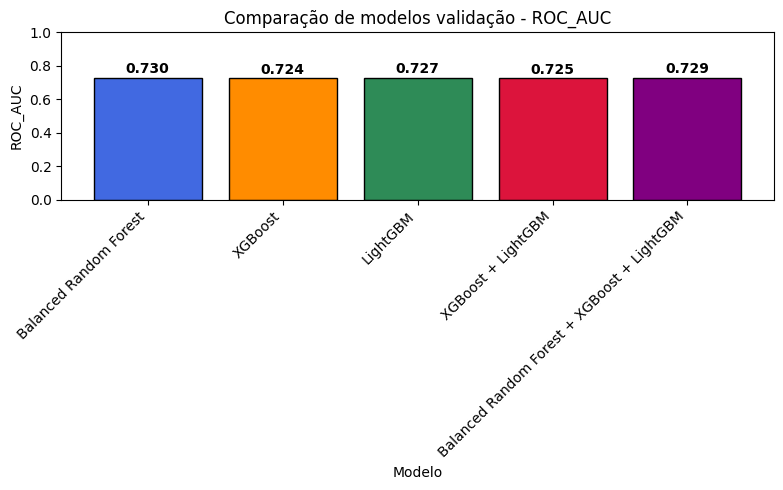

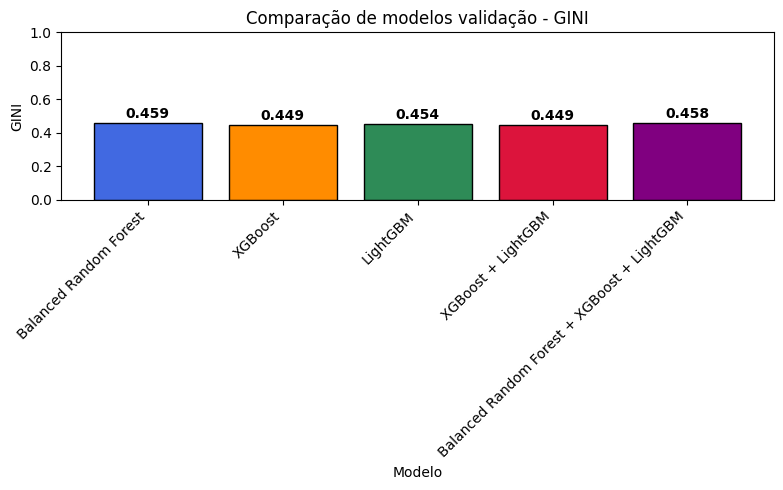

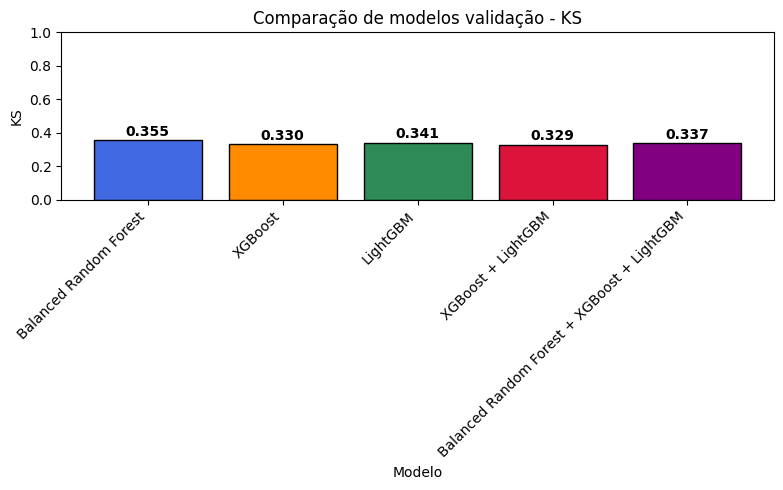

In [ ]:
# Definir as métricas que queremos plotar
metricas = ["roc_auc", "gini", "ks"]

# Definir cores para cada modelo
cores = {
    "Balanced Random Forest": "royalblue",
    "XGBoost": "darkorange",
    "LightGBM": "seagreen",
    "XGBoost + LightGBM": "crimson",
    "Balanced Random Forest + XGBoost + LightGBM": "purple"
}

# Criar 3 gráficos (um para cada métrica)
for metrica in metricas:
    plt.figure(figsize=(8,5))

    # Pegar as cores correspondentes aos modelos
    colors = [cores[m] for m in resultados_treino["modelo"]]

    bars = plt.bar(resultados_treino["modelo"], resultados_treino[metrica],
                   color=colors, edgecolor="black")

    # Adicionar os valores acima de cada barra
    for bar, valor in zip(bars, resultados_treino[metrica]):
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.01,
                 f"{valor:.3f}",
                 ha="center", va="bottom", fontsize=10, fontweight="bold")

    plt.title(f"Comparação de modelos validação - {metrica.upper()}")
    plt.xlabel("Modelo")
    plt.ylabel(metrica.upper())
    plt.ylim(0, 1)  # eixo y entre 0 e 1
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

### Análise para o teste

In [ ]:
resultados_teste

modelo   roc_auc      gini        ks
0  Teste Balanced Random Forest - Base Original  0.722406  0.444813  0.336416
1                 Teste XGBoost - Base Original  0.720527  0.441053  0.334076
2                Teste LightGBM - Base Original  0.723792  0.447584  0.339197
3           Teste Ensemble (LightGBM + XGBoost)  0.724319  0.448638  0.342776
4     Teste Ensemble (LightGBM + XGBoost + BRF)  0.727218  0.454437  0.346704

In [ ]:
# Novos nomes para a coluna 'modelo'
nome_modelo = [
    'Balanced Random Forest',
    'XGBoost',
    'LightGBM',
    'XGBoost + LightGBM',
    'Balanced Random Forest + XGBoost + LightGBM'
]

# Atribuindo a nova lista à coluna
resultados_teste['modelo'] = nome_modelo

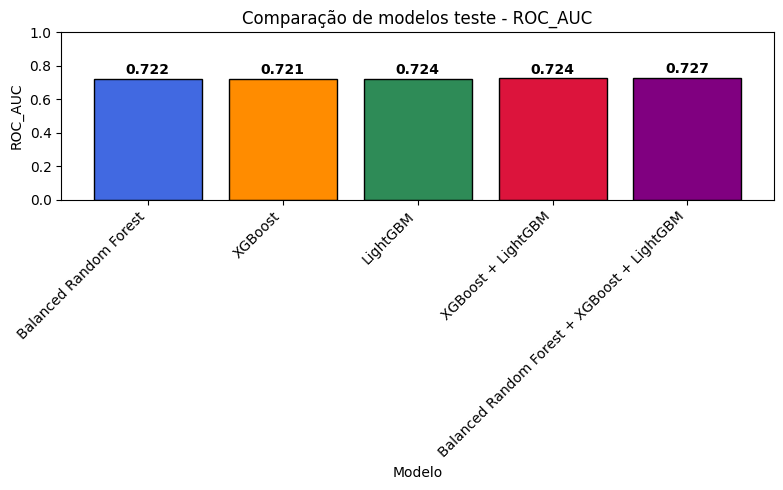

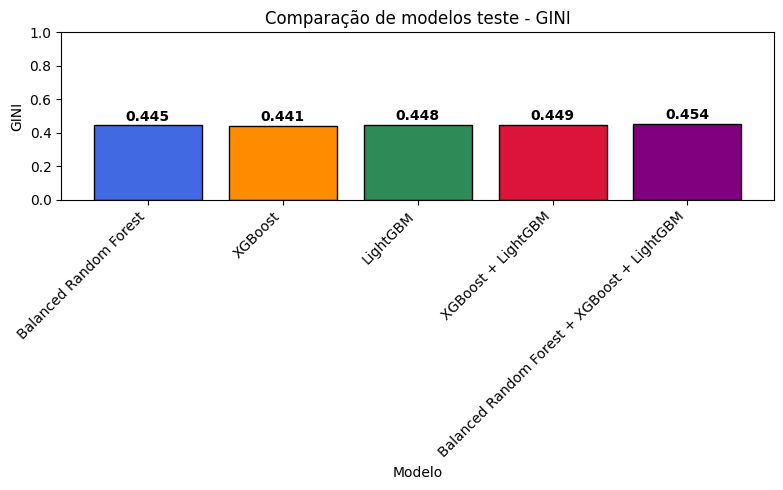

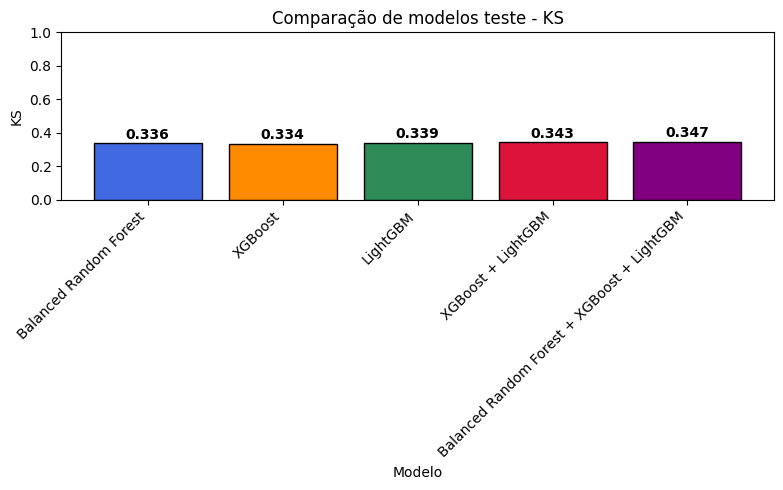

In [ ]:
# Definir as métricas que queremos plotar
metricas = ["roc_auc", "gini", "ks"]

# Definir cores para cada modelo
cores = {
    "Balanced Random Forest": "royalblue",
    "XGBoost": "darkorange",
    "LightGBM": "seagreen",
    "XGBoost + LightGBM": "crimson",
    "Balanced Random Forest + XGBoost + LightGBM": "purple"
}

# Criar 3 gráficos (um para cada métrica)
for metrica in metricas:
    plt.figure(figsize=(8,5))

    # Pegar as cores correspondentes aos modelos
    colors = [cores[m] for m in resultados_teste["modelo"]]

    bars = plt.bar(resultados_teste["modelo"], resultados_teste[metrica],
                   color=colors, edgecolor="black")

    # Adicionar os valores acima de cada barra
    for bar, valor in zip(bars, resultados_teste[metrica]):
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.01,
                 f"{valor:.3f}",
                 ha="center", va="bottom", fontsize=10, fontweight="bold")

    plt.title(f"Comparação de modelos teste - {metrica.upper()}")
    plt.xlabel("Modelo")
    plt.ylabel(metrica.upper())
    plt.ylim(0, 1)  # eixo y entre 0 e 1
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

##  Análise entre Regressão Logística e o LightGBM

In [ ]:
files = {'resultados_reglog': '1aScDkXwfQqqqVIOArEfTSSKOKFsgCRBB',
         'resultados_lightgbm': '1_0A4Gq65M3MWbCpk7a_WocY1swavhDNZ'
                 }
# https://drive.google.com/file/d/1aScDkXwfQqqqVIOArEfTSSKOKFsgCRBB/view?usp=drive_link
for nome_arquivo, id in files.items():
    if not os.path.exists(nome_arquivo):
        !gdown --id {id} -O {nome_arquivo}
    else:
        continue

In [ ]:
resultados_reg_log = pd.read_csv('resultados_reglog')
resultados_lightgbm = pd.read_csv('resultados_lightgbm')

In [ ]:
resultados_reg_log

modelo   roc_auc      gini  \
0  Regressão Logística - Base Original sem Balanc...  0.716679  0.433358   
1  Teste Regressão Logística - Base Original sem ...  0.705260  0.410520   
2  Regressão Logística - Base Original com Balanc...  0.716897  0.433793   
3  Teste Regressão Logística - Base Original com ...  0.705489  0.410977   
4                 Regressão Logística - Oversampling  0.707527  0.415053   
5           Teste Regressão Logística - Oversampling  0.705489  0.410977   
6                Regressão Logística - Undersampling  0.716897  0.433793   
7          Teste Regressão Logística - Undersampling  0.705489  0.410977   

         ks  
0  0.330921  
1  0.313510  
2  0.334662  
3  0.312531  
4  0.311245  
5  0.312531  
6  0.334662  
7  0.312531

In [ ]:
resultados_reg_log = resultados_reg_log.drop([0,1,4,5,6,7])

In [ ]:
resultados_reg_log = resultados_reg_log.reset_index(drop=True)

In [ ]:
resultados_reg_log

modelo   roc_auc      gini  \
0  Regressão Logística - Base Original com Balanc...  0.716897  0.433793   
1  Teste Regressão Logística - Base Original com ...  0.705489  0.410977   

         ks  
0  0.334662  
1  0.312531

### Juntando dados para comparação

In [ ]:
comparacao = pd.concat([resultados_reg_log, resultados_lightgbm], axis=0)
comparacao = comparacao.reset_index(drop=True)

In [ ]:
comparacao

modelo   roc_auc      gini  \
0  Regressão Logística - Base Original com Balanc...  0.716897  0.433793   
1  Teste Regressão Logística - Base Original com ...  0.705489  0.410977   
2                           LightGBM - Base Original  0.726826  0.453652   
3                     Teste LightGBM - Base Original  0.723792  0.447584   

         ks  
0  0.334662  
1  0.312531  
2  0.341452  
3  0.339197

In [ ]:
comparacao_treino = comparacao[comparacao.index % 2 == 0].reset_index(drop=True)
comparacao_teste = comparacao[comparacao.index % 2 == 1].reset_index(drop=True)

### Análise para o treino

In [ ]:
comparacao_treino

modelo   roc_auc      gini  \
0  Regressão Logística - Base Original com Balanc...  0.716897  0.433793   
1                           LightGBM - Base Original  0.726826  0.453652   

         ks  
0  0.334662  
1  0.341452

In [ ]:
# Novos nomes para a coluna 'modelo'
nome_modelo = [
    'Regressão Logística',
    'LightGBM'
]

# Atribuindo a nova lista à coluna
comparacao_treino['modelo'] = nome_modelo

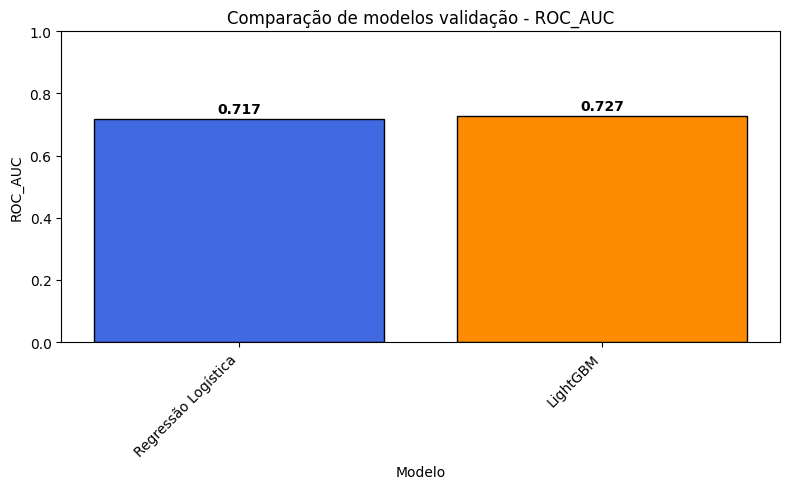

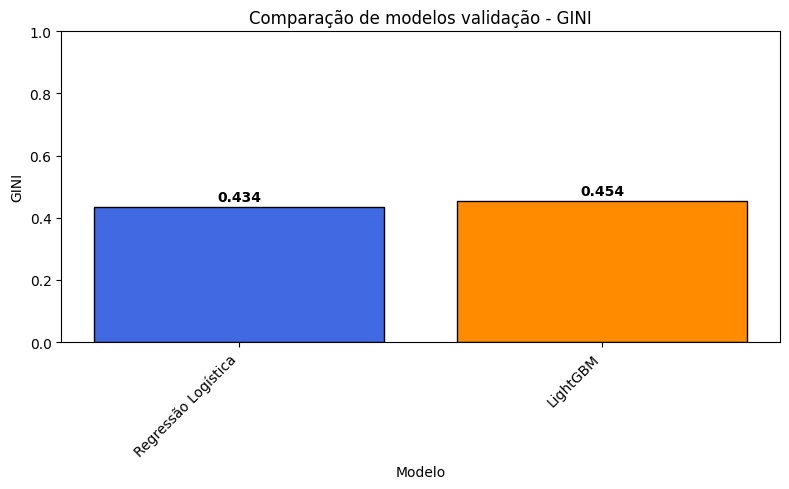

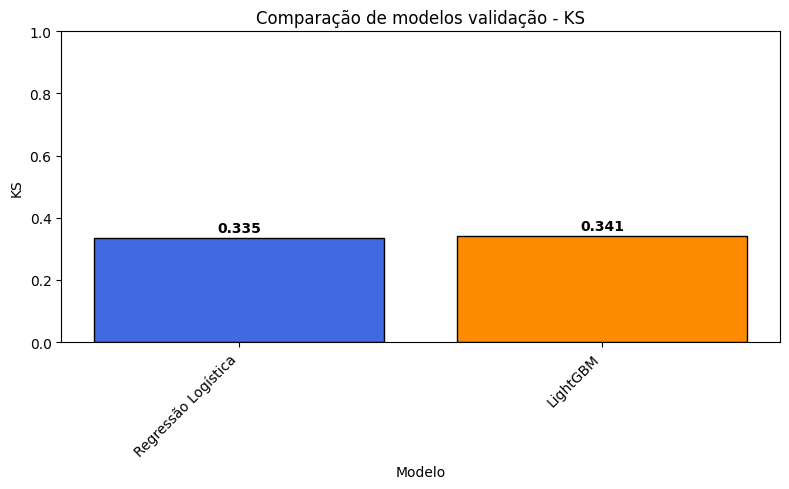

In [ ]:
# Definir as métricas que queremos plotar
metricas = ["roc_auc", "gini", "ks"]

# Definir cores para cada modelo
cores = {
    "Regressão Logística": "royalblue",
    "LightGBM": "darkorange"
    }

# Criar 3 gráficos (um para cada métrica)
for metrica in metricas:
    plt.figure(figsize=(8,5))

    # Pegar as cores correspondentes aos modelos
    colors = [cores[m] for m in comparacao_treino["modelo"]]

    bars = plt.bar(comparacao_treino["modelo"], comparacao_treino[metrica],
                   color=colors, edgecolor="black")

    # Adicionar os valores acima de cada barra
    for bar, valor in zip(bars, comparacao_treino[metrica]):
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.01,
                 f"{valor:.3f}",
                 ha="center", va="bottom", fontsize=10, fontweight="bold")

    plt.title(f"Comparação de modelos validação - {metrica.upper()}")
    plt.xlabel("Modelo")
    plt.ylabel(metrica.upper())
    plt.ylim(0, 1)  # eixo y entre 0 e 1
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

### Análise para o teste

In [ ]:
comparacao_teste

modelo   roc_auc      gini  \
0  Teste Regressão Logística - Base Original com ...  0.705489  0.410977   
1                     Teste LightGBM - Base Original  0.723792  0.447584   

         ks  
0  0.312531  
1  0.339197

In [ ]:
# Novos nomes para a coluna 'modelo'
nome_modelo = [
    'Regressão Logística',
    'LightGBM'
]

# Atribuindo a nova lista à coluna
comparacao_teste['modelo'] = nome_modelo

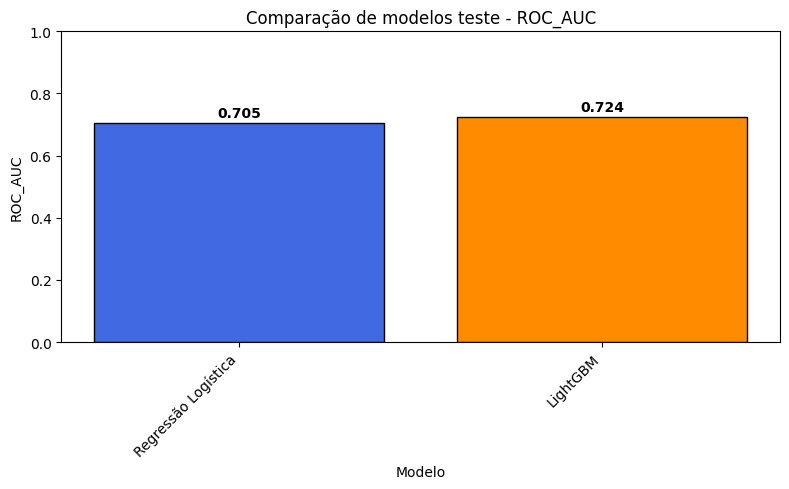

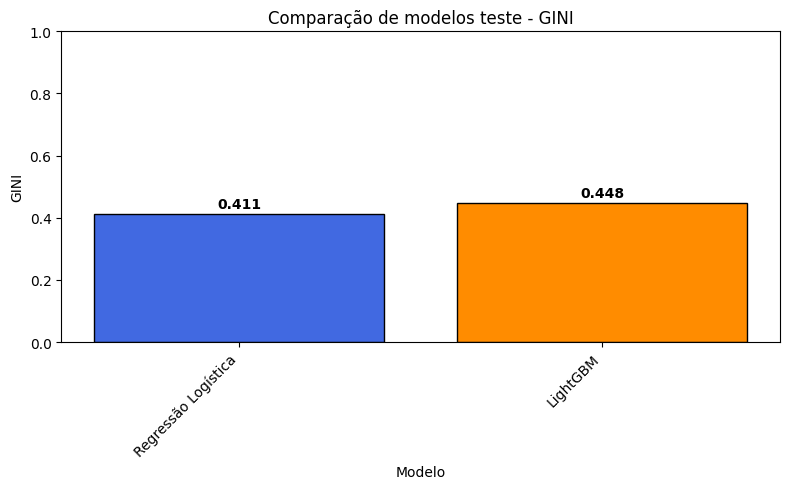

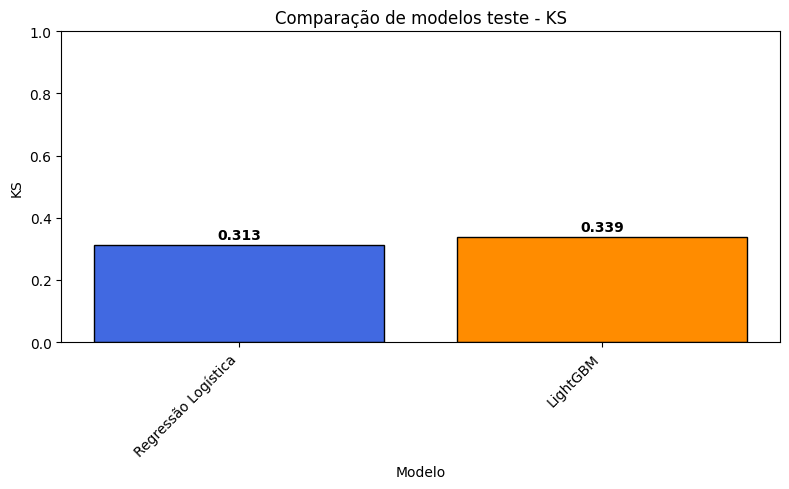

In [ ]:
# Definir as métricas que queremos plotar
metricas = ["roc_auc", "gini", "ks"]

# Definir cores para cada modelo
cores = {
    "Regressão Logística": "royalblue",
    "LightGBM": "darkorange"
    }

# Criar 3 gráficos (um para cada métrica)
for metrica in metricas:
    plt.figure(figsize=(8,5))

    # Pegar as cores correspondentes aos modelos
    colors = [cores[m] for m in comparacao_teste["modelo"]]

    bars = plt.bar(comparacao_teste["modelo"], comparacao_teste[metrica],
                   color=colors, edgecolor="black")

    # Adicionar os valores acima de cada barra
    for bar, valor in zip(bars, comparacao_teste[metrica]):
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.01,
                 f"{valor:.3f}",
                 ha="center", va="bottom", fontsize=10, fontweight="bold")

    plt.title(f"Comparação de modelos teste - {metrica.upper()}")
    plt.xlabel("Modelo")
    plt.ylabel(metrica.upper())
    plt.ylim(0, 1)  # eixo y entre 0 e 1
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

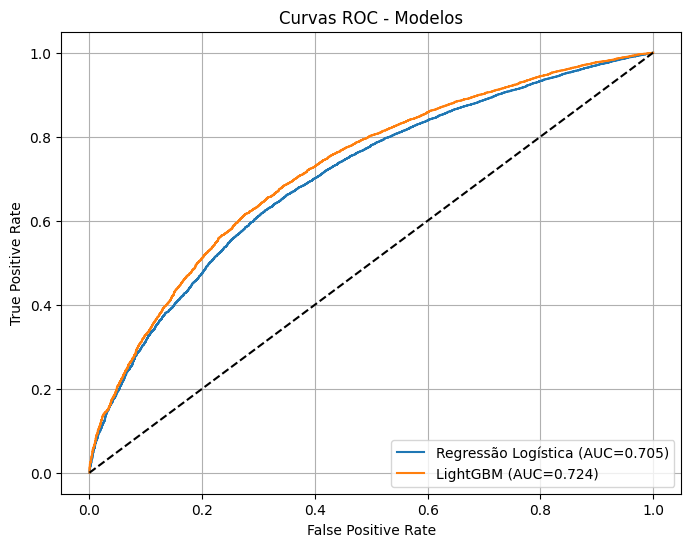

In [ ]:
# Exemplo para dois modelos: Regressão Logística e LightGBM
modelos = {
    "Regressão Logística": y_proba_logistica,
    "LightGBM": y_proba_lgbm
}

plt.figure(figsize=(8,6))

for nome, y_proba in modelos.items():
    fpr, tpr, _ = roc_curve(y_test_safra, y_proba)
    auc = roc_auc_score(y_test_safra, y_proba)
    plt.plot(fpr, tpr, label=f"{nome} (AUC={auc:.3f})")

# Linha de referência
plt.plot([0,1], [0,1], "k--")

plt.title("Curvas ROC - Modelos")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

##  Gerando os escores com Regressão Logística e LightGBM

### Gerar scores

In [209]:
def proba_to_score(y_proba):
    """
    Converte probabilidades (0..1) em scores inteiros (0..999).
    - p * 1000 -> [0..1000)
    - floor e clip para garantir [0..999]
    """
    y_proba = np.asarray(y_proba, dtype=float)
    scores = np.floor(y_proba * 1000).astype(int)
    scores = np.clip(scores, 0, 999)
    return scores

# Exemplo com array/Series de probabilidades da classe 1 (adimplente):
# y_proba = pipeline.predict_proba(X_val)[:, 1]
# scores = proba_to_score(y_proba)
# print(scores[:10])

# Se quiser anexar ao DataFrame de validação:
# df_val = pd.DataFrame(X_val)  # se X_val não for DataFrame
# df_val["score_0_999"] = proba_to_score(y_proba)

### Reaplicando o modelo para Regressão Logística

In [210]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))

# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba_logistica = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

In [211]:
# Converter probabilidades em scores (0–999)
scores = proba_to_score(y_proba_logistica)

# Exibir os primeiros scores
print(scores[:20])

[777 101 861 929 770 799 646 871 793 941 689 658 859 794 446 832 495 583
 709 815]


In [212]:
teste['score_modelo_A'] = scores

### Reaplicando o modelo para LightGBM

In [213]:
# Criar modelo LightGBM com parâmetros ajustados
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)


# Treinar o modelo final no treino inteiro
lgbm.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no conjunto de teste
y_pred = lgbm.predict(X_test_safra_encoded)
y_proba = lgbm.predict_proba(X_test_safra_encoded)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62001, number of negative: 11223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18850
[LightGBM] [Info] Number of data points in the train set: 73224, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846731 -> initscore=1.709185
[LightGBM] [Info] Start training from score 1.709185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [214]:
# Converter probabilidades em scores_B (0–999)
scores_B = proba_to_score(y_proba)

# Exibir os primeiros scores_B
print(scores_B[:20])

[874 840 966 940 896 974 915 925 874 989 765 700 908 915 820 841 721 613
 786 882]


In [215]:
teste['score_modelo_B'] = scores_B

In [216]:
teste.head(15)

adimplencia   regiao faixa_idade faixa_renda        vp_6     vp_12  \
0             1    NORTE       41–60       >7000  100.150327  6.928766   
2             1    NORTE       41–60       >7000  119.774002  2.206758   
6             1    NORTE       41–60       >7000  107.028944  1.863565   
7             1    NORTE       41–60       >7000   91.435008  0.000000   
8             1    NORTE       41–60       >7000   96.866999  0.663835   
11            1    NORTE       41–60       >7000  157.258790  0.000000   
12            1    NORTE       41–60       >7000  100.000000  0.000000   
13            1    NORTE       41–60       >7000  139.514548  0.000000   
14            0    NORTE       41–60       >7000  130.522351  3.026700   
15            1    NORTE       41–60       >7000   98.842490  0.000000   
23            1  SUDESTE       41–60   1500–2500  145.499428  2.881281   
25            1  SUDESTE       41–60   1500–2500  200.000000  3.183340   
29            1  SUDESTE       41–60   1500–2500   86.844058  6.872315   
31            1  SUDESTE       41–60   1500–2500  154.287218  2.261991   
32            1  SUDESTE       41–60   1500–2500   98.885088  0.596592   

        vp_13      vp_14       vp_15  vp_17    vp_22   vp_27   vp_29  \
0    0.000000   0.000000    0.000000   52.0  1.07693   300.0     6.0   
2   22.386469  85.050828   83.151543   57.0  1.04864  2784.0   108.0   
6    0.161918   0.233533    0.206315   60.0  1.01584  1942.0     0.0   
7    0.339780   0.346246    0.414321   54.0  1.04467  8338.0  7830.0   
8    0.336165   0.425675    1.406411   44.0  1.05623   763.0     0.0   
11   1.433169   0.730666    0.478668   48.0  1.05152  1538.0   528.0   
12   0.000000   0.000000    0.000000   40.0  1.03267     0.0     0.0   
13   0.399085   0.397262    0.464802   40.0  1.06118  2391.0    62.0   
14   0.000000   0.000000    0.000000   44.0  1.03786   300.0   294.0   
15   0.272403   0.494431    0.450855   54.0  1.01781  2764.0    30.0   
23   0.000000   0.000000    0.000000   45.0  1.00618   282.0   124.0   
25   0.000000   0.000000    0.000000   42.0  1.02438   349.0   111.0   
29   0.000000   0.691862   34.373521   43.0  0.99819   195.0    95.0   
31   1.095924   0.729563    8.153250   34.0  1.03285   550.0     0.0   
32  14.897876  12.374921  139.186860   43.0  1.01000   136.0     5.0   

         vp_30   vp_37   vp_38   vp_39  vp_40  vp_41     vp_42     vp_43  \
0   100.000000  1000.0     0.0   521.0   23.0   23.0  1.212300  1.766634   
2    33.333332     0.0     0.0   941.0   48.0   48.0  0.984637  1.701742   
6   100.000000  1000.0   191.0   322.0   97.0   97.0  0.997669  0.950009   
7   100.000000  1000.0  1000.0   449.0  117.0  117.0  1.031788  1.230759   
8   100.000000  1000.0   409.0   447.0   41.0   82.0  0.985673  0.987890   
11  100.000000   798.0   922.0   458.0  104.0  104.0  1.089230  1.189458   
12    0.000000     0.0     0.0     2.0  130.0  130.0  1.000000  1.000000   
13  100.000000  1000.0   963.0   466.0  244.0  244.0  1.254562  1.226080   
14  100.000000  1000.0   165.0  1000.0   12.0   12.0  1.321391  2.000000   
15  100.000000  1000.0   976.0   487.0   90.0   90.0  0.866455  0.936280   
23   85.714290   753.0   366.0   883.0   14.0   14.0  1.263468  1.937701   
25  100.000000  1000.0    65.0   828.0   39.0   39.0  1.332277  1.656292   
29  100.000000  1000.0   116.0   602.0  127.0  127.0  0.902869  1.442908   
31   90.000000  1000.0   350.0   489.0   57.0   57.0  1.089495  1.151765   
32   71.428570     0.0   278.0   696.0  180.0  180.0  1.251011  0.744905   

    vp_46       vp_47    vp_56    vp_65  vp_66  vp_67  vp_68  vp_69   vp_77  \
0    40.0  68980000.0   8576.0  1.44480   33.0    0.0    0.0    0.0  1000.0   
2     8.0  69028140.0   4495.0  1.56931   45.0    0.0    0.0    0.0     1.0   
6    14.0  67115000.0   7394.0  1.49127   37.0    0.0    0.0    0.0     1.0   
7     6.0  68790000.0   2929.0  1.55132   38.0    0.0    0.0    0.0     1.0   
8     6.0  69902810.0   7410.0  1.46452   31.0    0.0 

# Juntando Informações sobre os Escores

In [ ]:
teste['safra_concessao'] = teste_id_safra['safra_concessao']
teste['id'] = teste_id_safra['id']

In [ ]:
# Pegar todas as colunas do dataframe
cols = list(teste.columns)

# Definir nova ordem: ['safra_concessao', 'id', ...restante]
new_order = ['safra_concessao', 'id'] + [c for c in cols if c not in ['safra_concessao', 'id']]

# Reordenar o dataframe
teste = teste[new_order]

In [ ]:
teste

safra_concessao     id  adimplencia regiao faixa_idade faixa_renda  \
0               202310      1            1  NORTE       41–60       >7000   
2               202311      3            1  NORTE       41–60       >7000   
6               202311      7            1  NORTE       41–60       >7000   
7               202310      8            1  NORTE       41–60       >7000   
8               202310      9            1  NORTE       41–60       >7000   
...                ...    ...          ...    ...         ...         ...   
99087           202311  99088            1  NORTE       41–60   2500–7000   
99088           202310  99089            1  NORTE       41–60   2500–7000   
99089           202309  99090            1  NORTE       41–60   2500–7000   
99095           202309  99096            1  NORTE       41–60   2500–7000   
99101           202311  99102            1  NORTE       41–60   2500–7000   

             vp_6     vp_12      vp_13      vp_14      vp_15  vp_17    vp_22  \
0      100.150327  6.928766   0.000000   0.000000   0.000000   52.0  1.07693   
2      119.774002  2.206758  22.386469  85.050828  83.151543   57.0  1.04864   
6      107.028944  1.863565   0.161918   0.233533   0.206315   60.0  1.01584   
7       91.435008  0.000000   0.339780   0.346246   0.414321   54.0  1.04467   
8       96.866999  0.663835   0.336165   0.425675   1.406411   44.0  1.05623   
...           ...       ...        ...        ...        ...    ...      ...   
99087  102.500913  0.000000  37.767365  12.822899  52.856953   44.0  1.04871   
99088  118.787545  5.026450   0.000000   0.000000   0.139768   50.0  1.04774   
99089  113.421253  0.067421   2.294202   0.752194   0.596428   57.0  1.03023   
99095  100.017517  6.576034   0.000000   0.111936   0.049323   54.0  1.03916   
99101  128.118255  1.658392   0.660998   1.312595   3.282354   48.0  1.02572   

        vp_27   vp_29       vp_30   vp_37   vp_38  vp_39  vp_40  vp_41  \
0       300.0     6.0  100.000000  1000.0     0.0  521.0   23.0   23.0   
2      2784.0   108.0   33.333332     0.0     0.0  941.0   48.0   48.0   
6      1942.0     0.0  100.000000  1000.0   191.0  322.0   97.0   97.0   
7      8338.0  7830.0  100.000000  1000.0  1000.0  449.0  117.0  117.0   
8       763.0     0.0  100.000000  1000.0   409.0  447.0   41.0   82.0   
...       ...     ...         ...     ...     ...    ...    ...    ...   
99087   462.0   318.0    0.000000     0.0     0.0  658.0   33.0   33.0   
99088   599.0   575.0  100.000000  1000.0     0.0  786.0   31.0   31.0   
99089   503.0    82.0   93.333336   466.0   563.0  625.0  109.0  109.0   
99095   671.0     3.0   85.714290  1000.0     0.0  442.0  113.0  113.0   
99101  2047.0     0.0   83.333336   299.0   276.0  333.0  164.0  164.0   

          vp_42     vp_43  vp_46       vp_47   vp_56    vp_65  vp_66  \
0      1.212300  1.766634   40.0  68980000.0  8576.0  1.44480   33.0   
2      0.984637  1.701742    8.0  69028140.0  4495.0  1.56931   45.0   
6      0.997669  0.950009   14.0  67115000.0  7394.0  1.49127   37.0   
7      1.031788  1.230759    6.0  68790000.0  2929.0  1.55132   38.0   
8      0.985673  0.987890    6.0  69902810.0  7410.0  1.46452   31.0   
...         ...       ...    ...         ...     ...      ...    ...   
99087  0.838854  1.409907    3.0  77823250.0  6880.0  1.52542   32.0   
99088  1.337387  1.572708    6.0  77826165.0  3204.0  1.70339   37.0   
99089  1.016968  1.083897   29.0  69080680.0  4754.0  1.50873   46.0   
99095  1.029150  1.030827   15.0  77460000.0  2848.0  1.72414   48.0   
99101  1.196248  0.952960   12.0  76824692.0  8623.0  1.47193   32.0   

           vp_67      vp_68  vp_69   vp_77  vp_81   vp_83     vp_89  vp_100  \
0       0.000000   0.000000    0.0  1000.0   76.0     0.0  1.137239  3532.0   
2       0.000000   0.000000    0.0     1.0   59.0   979.0  0.739598   977.0   
6       0.000000   0.000000    0.0     1.0   69.0     0.0  1.095188   623.0   
7       0.000000   0.000000    0.0     1.0   49.0  

##  Métricas de acordo com safras e perfil demografico

In [ ]:
def calcular_metricas(y_true, scores):
    auc = roc_auc_score(y_true, scores)
    gini = 2 * auc - 1

    fpr, tpr, _ = roc_curve(y_true, scores)
    ks = np.max(tpr - fpr)

    return pd.Series({"AUC": auc, "Gini": gini, "KS": ks})

### Separando modelo A e modelo B

In [ ]:
# Por safra
resultado_safra_A = (
    teste.groupby("safra_concessao")
    .apply(lambda df: calcular_metricas(df["adimplencia"], df["score_modelo_A"]))
    .reset_index()
)

# Por safra e sexo (exemplo de grupo demográfico)
resultado_safra_renda_A = (
    teste.groupby(["safra_concessao", "faixa_renda"])
    .apply(lambda df: calcular_metricas(df["adimplencia"], df["score_modelo_A"]))
    .reset_index()
)

In [ ]:
# Por safra
resultado_safra_B = (
    teste.groupby("safra_concessao")
    .apply(lambda df: calcular_metricas(df["adimplencia"], df["score_modelo_B"]))
    .reset_index()
)

# Por safra e sexo (exemplo de grupo demográfico)
resultado_safra_renda_B= (
    teste.groupby(["safra_concessao", "faixa_renda"])
    .apply(lambda df: calcular_metricas(df["adimplencia"], df["score_modelo_B"]))
    .reset_index()
)

### Evoluçao das métricas ao longo do tempo

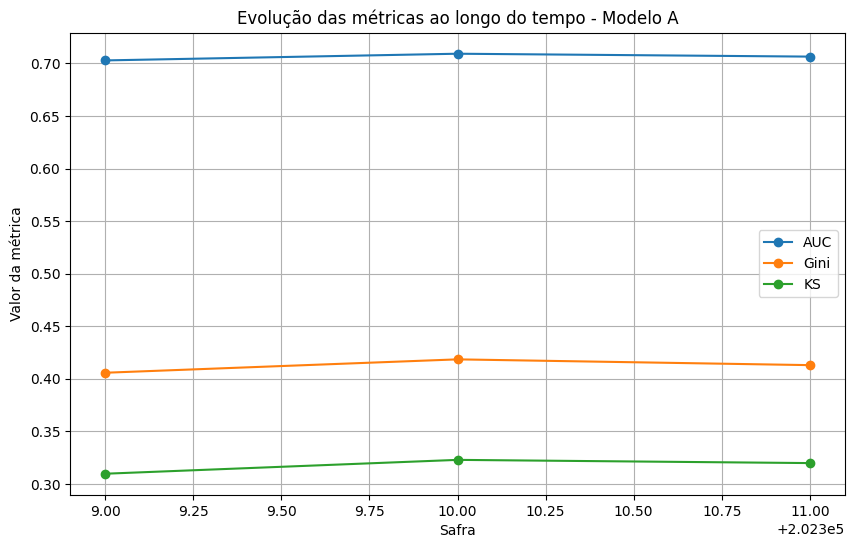

In [ ]:
plt.figure(figsize=(10,6))
for metric in ["AUC", "Gini", "KS"]:
    plt.plot(resultado_safra_A["safra_concessao"], resultado_safra_A[metric], marker="o", label=metric)

plt.title("Evolução das métricas ao longo do tempo - Modelo A")
plt.xlabel("Safra")
plt.ylabel("Valor da métrica")
plt.legend()
plt.grid(True)
plt.show()

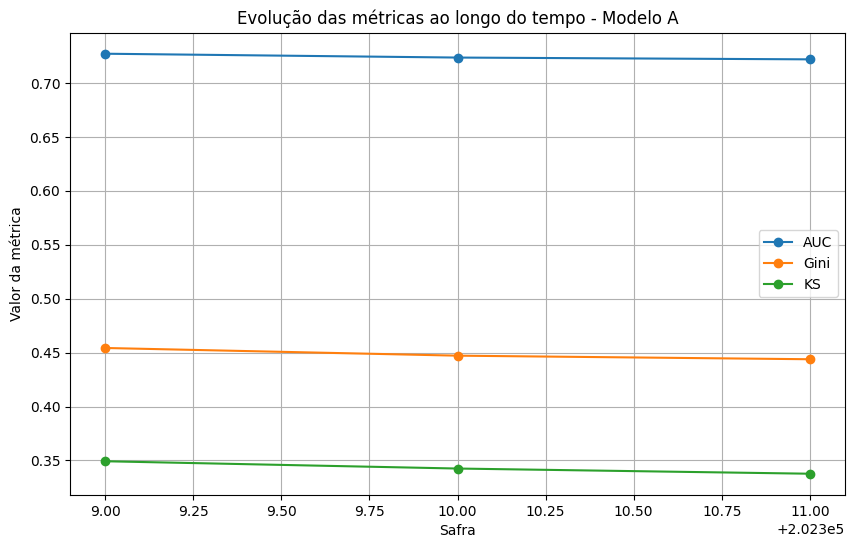

In [ ]:
plt.figure(figsize=(10,6))
for metric in ["AUC", "Gini", "KS"]:
    plt.plot(resultado_safra_B["safra_concessao"], resultado_safra_B[metric], marker="o", label=metric)

plt.title("Evolução das métricas ao longo do tempo - Modelo B")
plt.xlabel("Safra")
plt.ylabel("Valor da métrica")
plt.legend()
plt.grid(True)
plt.show()

### Tempo / renda

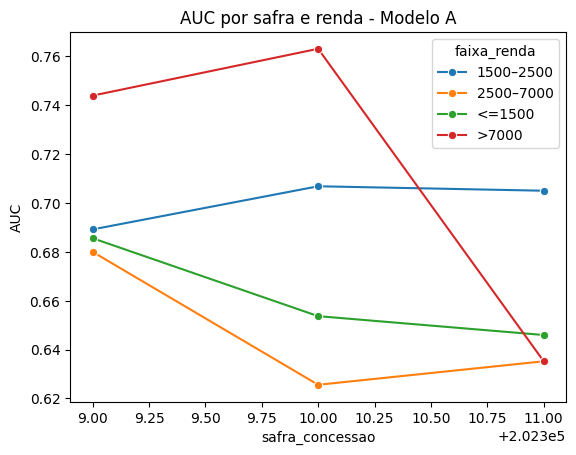

In [ ]:
sns.lineplot(data=resultado_safra_renda_A, x="safra_concessao", y="AUC", hue="faixa_renda", marker="o")
plt.title("AUC por safra e renda - Modelo A")
plt.show()

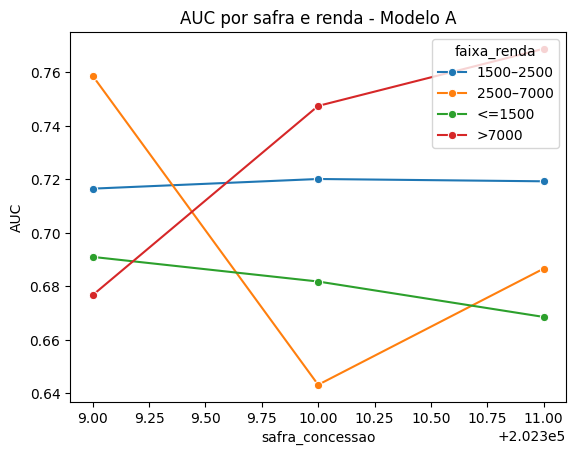

In [ ]:
sns.lineplot(data=resultado_safra_renda_B, x="safra_concessao", y="AUC", hue="faixa_renda", marker="o")
plt.title("AUC por safra e renda - Modelo A")
plt.show()

### Tempo / região

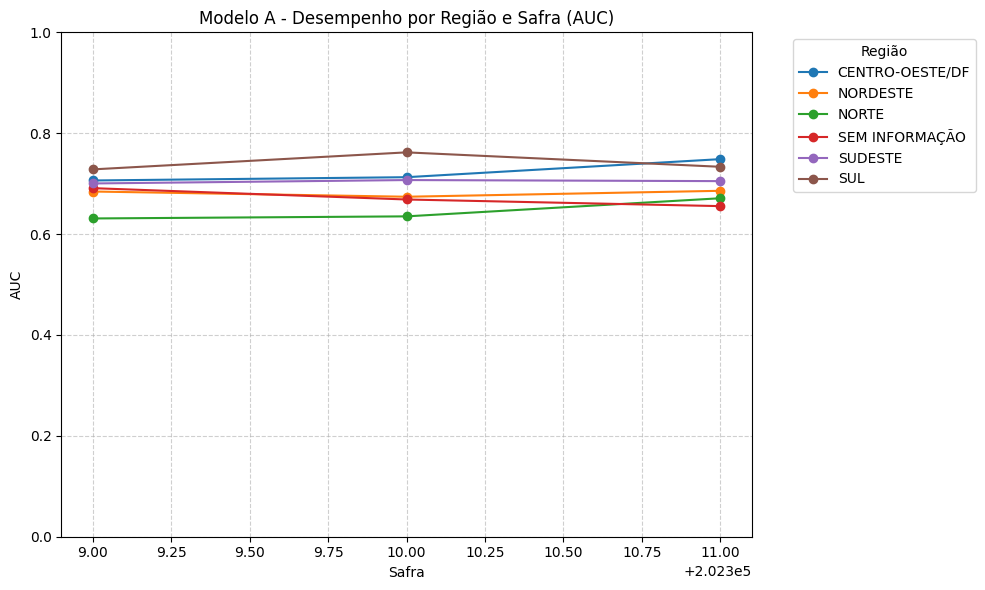

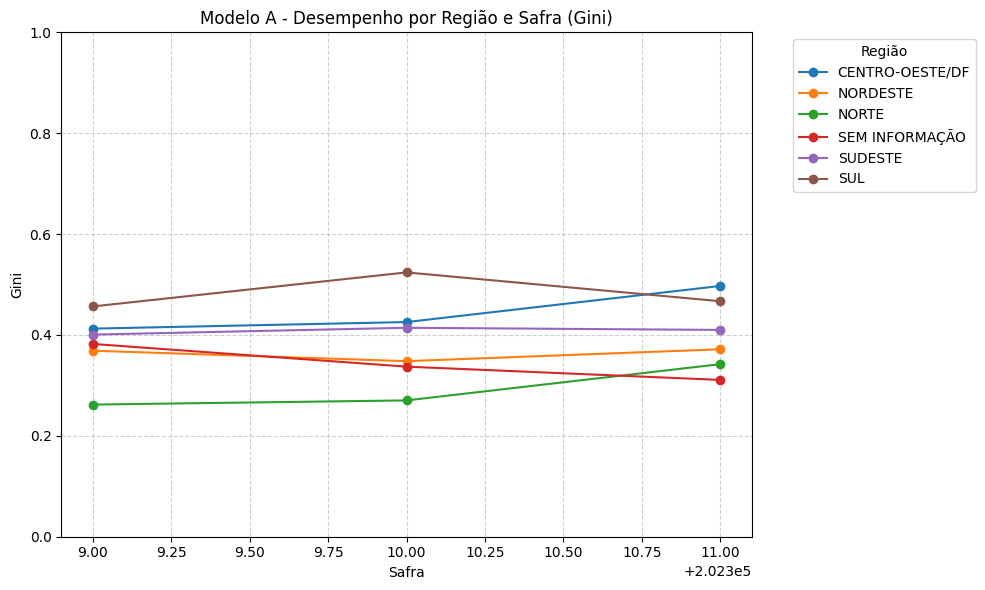

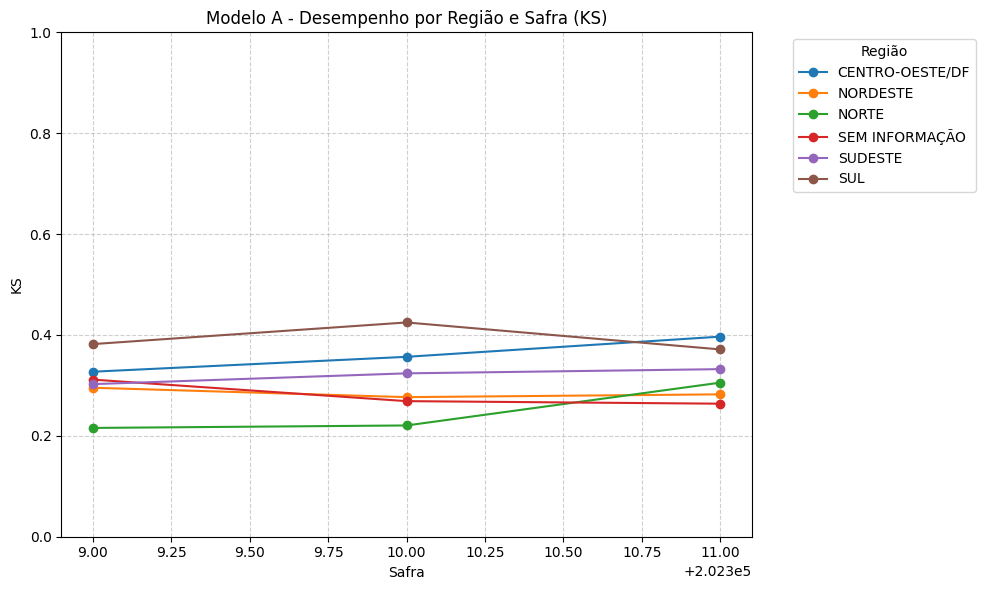

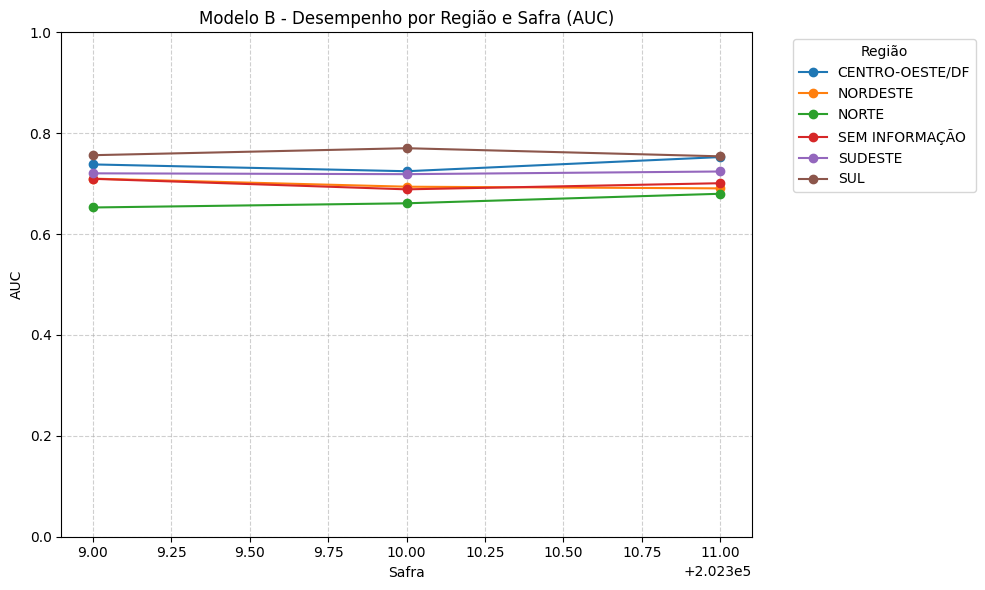

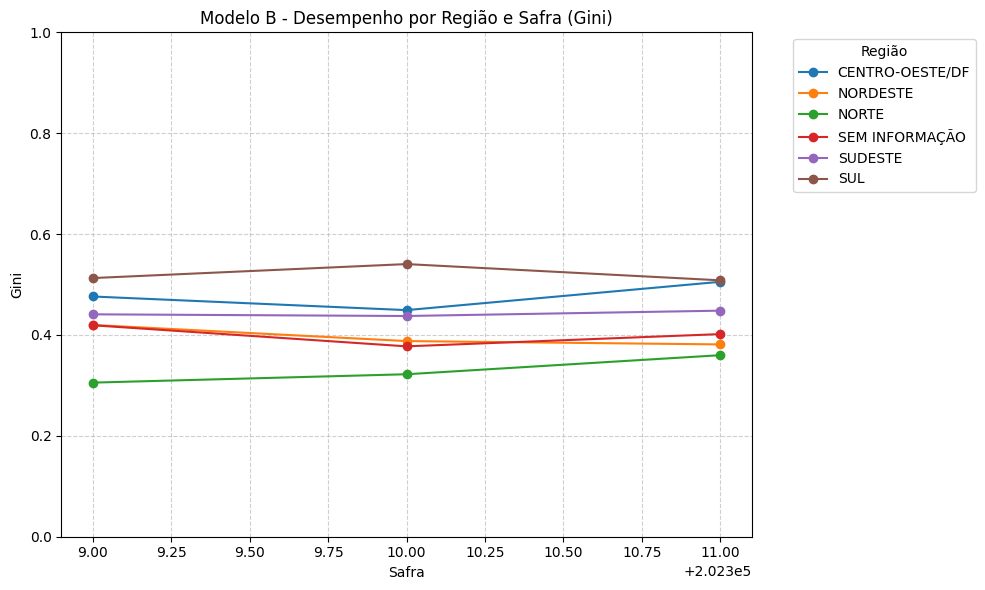

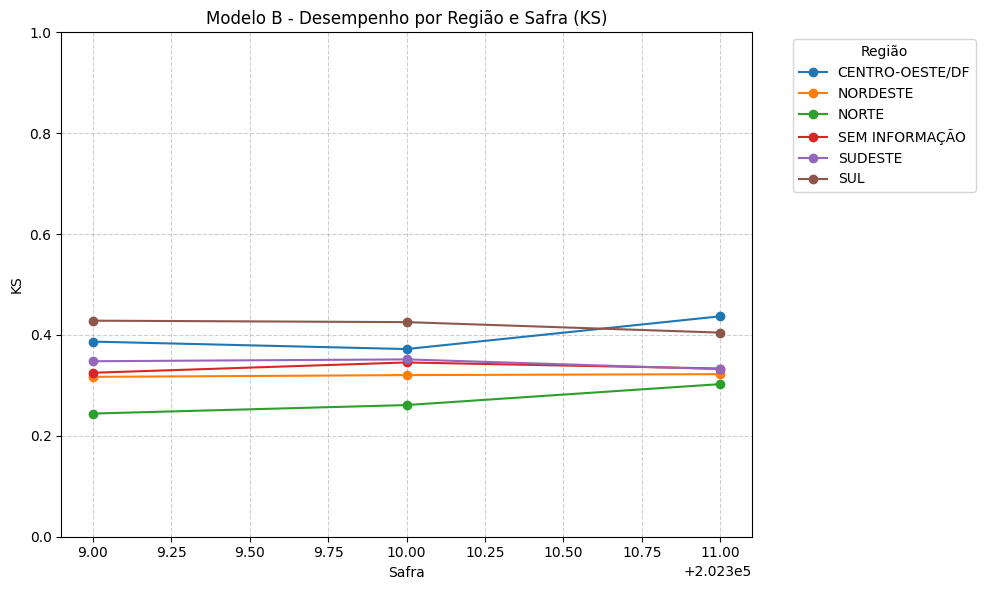

In [ ]:
# Agrupar por região + safra e calcular métricas para cada modelo
resultados_A = teste.groupby(["regiao", "safra_concessao"]).apply(
    lambda g: calcular_metricas(g["adimplencia"], g["score_modelo_A"])
).reset_index().assign(Modelo="Modelo A")

resultados_B = teste.groupby(["regiao", "safra_concessao"]).apply(
    lambda g: calcular_metricas(g["adimplencia"], g["score_modelo_B"])
).reset_index().assign(Modelo="Modelo B")

# Juntar resultados
resultados = pd.concat([resultados_A, resultados_B])

# --- Plotar separadamente para Modelo A e Modelo B ---
metricas = ["AUC", "Gini", "KS"]

for modelo in resultados["Modelo"].unique():
    subset_modelo = resultados[resultados["Modelo"] == modelo]

    for metrica in metricas:
        plt.figure(figsize=(10,6))
        for regiao in subset_modelo["regiao"].unique():
            dados = subset_modelo[subset_modelo["regiao"] == regiao]
            plt.plot(dados["safra_concessao"], dados[metrica], marker="o", label=f"{regiao}")

        plt.title(f"{modelo} - Desempenho por Região e Safra ({metrica})")
        plt.xlabel("Safra")
        plt.ylabel(metrica)
        plt.ylim(0, 1)
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Região")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

### Tempo / Idade

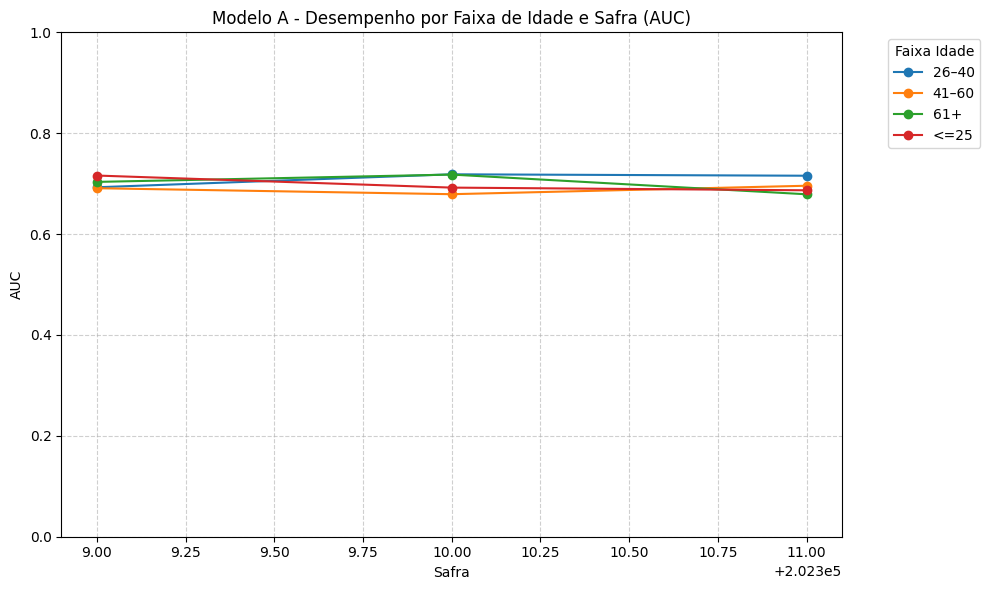

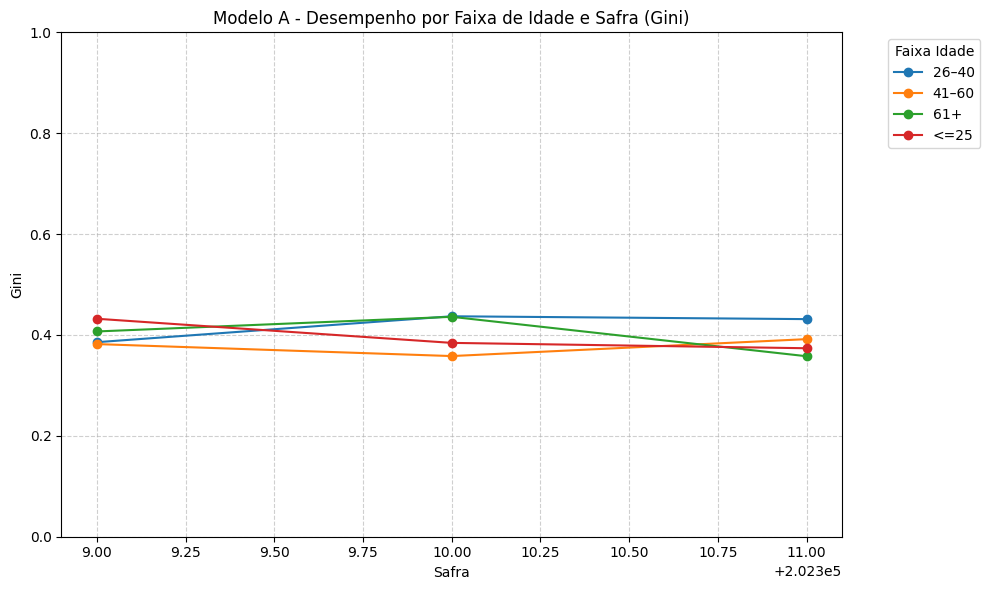

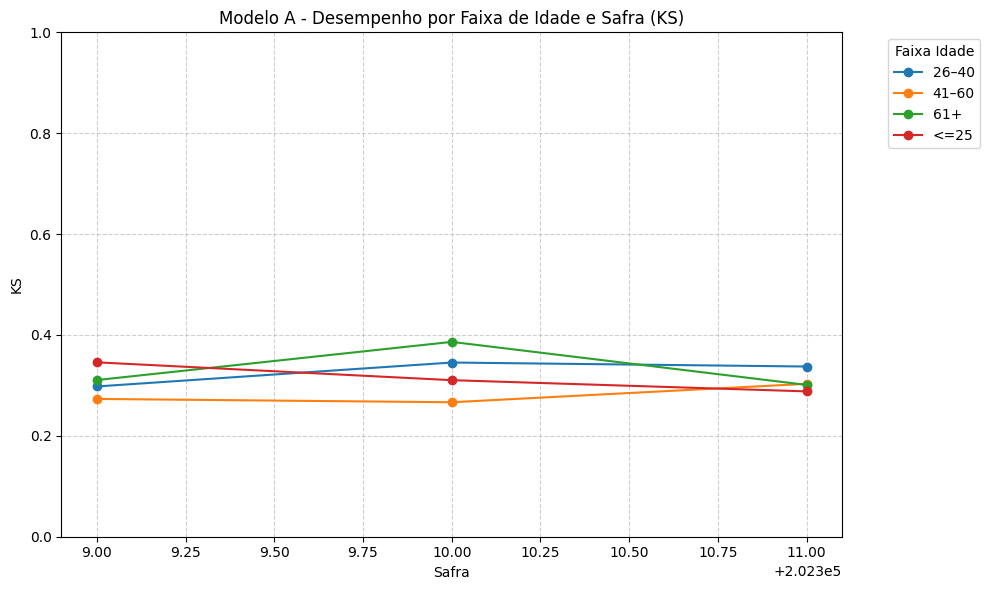

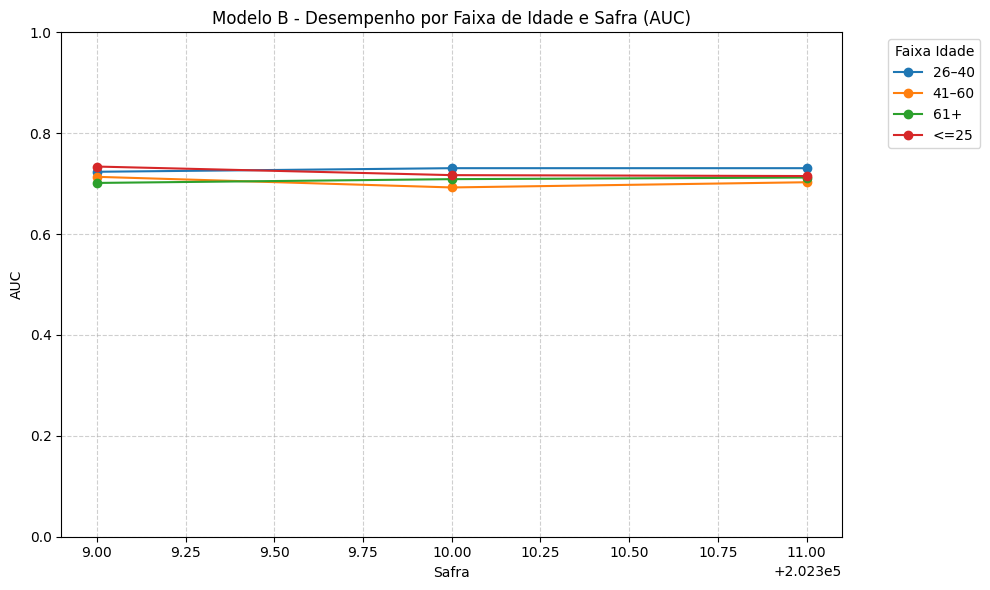

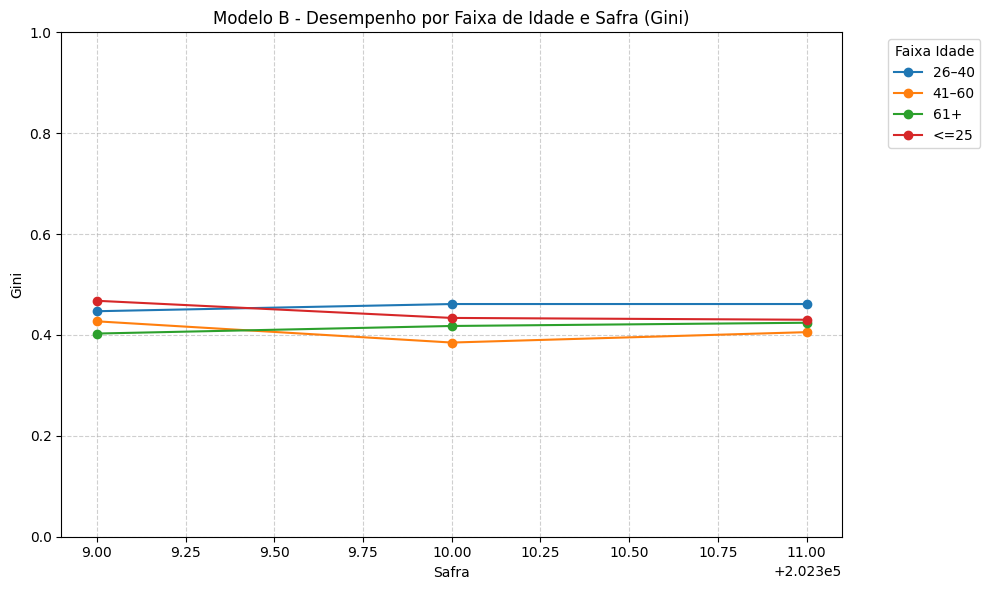

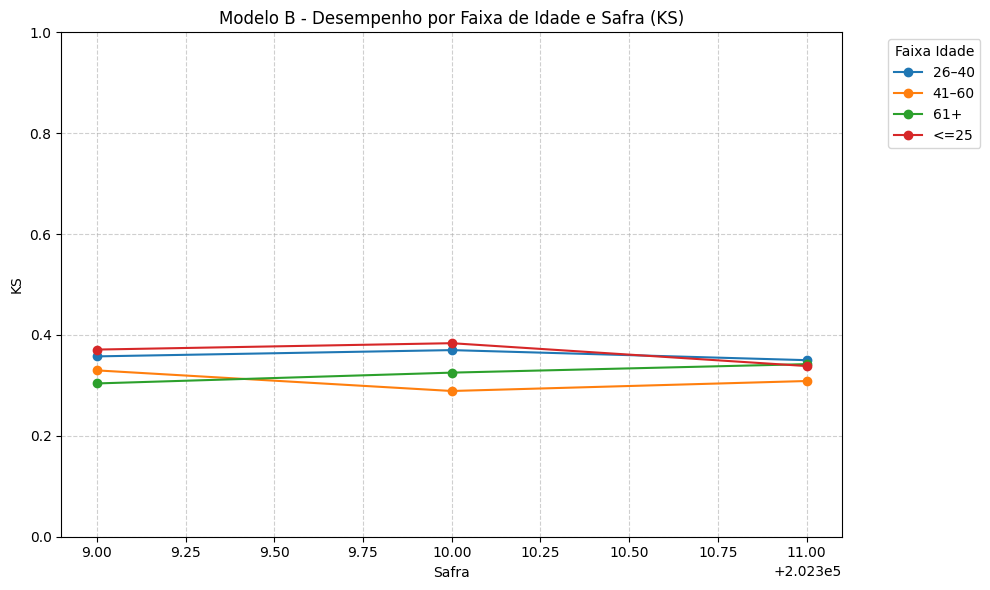

In [ ]:
# Agrupar por safra + faixa_idade e calcular métricas para cada modelo
resultados_A = teste.groupby(["safra_concessao", "faixa_idade"]).apply(
    lambda g: calcular_metricas(g["adimplencia"], g["score_modelo_A"])
).reset_index().assign(Modelo="Modelo A")

resultados_B = teste.groupby(["safra_concessao", "faixa_idade"]).apply(
    lambda g: calcular_metricas(g["adimplencia"], g["score_modelo_B"])
).reset_index().assign(Modelo="Modelo B")

# Juntar resultados
resultados = pd.concat([resultados_A, resultados_B])

# --- Plotar separadamente para Modelo A e Modelo B ---
metricas = ["AUC", "Gini", "KS"]

for modelo in resultados["Modelo"].unique():
    subset_modelo = resultados[resultados["Modelo"] == modelo]

    for metrica in metricas:
        plt.figure(figsize=(10,6))
        for faixa in subset_modelo["faixa_idade"].unique():
            dados = subset_modelo[subset_modelo["faixa_idade"] == faixa]
            plt.plot(dados["safra_concessao"], dados[metrica], marker="o", label=f"{faixa}")

        plt.title(f"{modelo} - Desempenho por Faixa de Idade e Safra ({metrica})")
        plt.xlabel("Safra")
        plt.ylabel(metrica)
        plt.ylim(0, 1)
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Faixa Idade")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

##Estabilidade dos Scores

In [ ]:
# Função PSI (igual à que você tem)
def calculate_psi(expected, actual, buckets=10):
    breakpoints = np.linspace(0, 100, buckets + 1)
    cut_points = np.percentile(expected, breakpoints)

    expected_counts, _ = np.histogram(expected, bins=cut_points)
    actual_counts, _ = np.histogram(actual, bins=cut_points)

    expected_perc = expected_counts / len(expected)
    actual_perc = actual_counts / len(actual)

    expected_perc = np.where(expected_perc == 0, 0.0001, expected_perc)
    actual_perc   = np.where(actual_perc == 0, 0.0001, actual_perc)

    psi = np.sum((expected_perc - actual_perc) * np.log(expected_perc / actual_perc))
    return psi


# --- Baseline = todas as 3 primeiras safras ---
baseline_A = teste.loc[teste["safra_concessao"].isin(sorted(teste["safra_concessao"].unique())[:3]), "score_modelo_A"]
baseline_B = teste.loc[teste["safra_concessao"].isin(sorted(teste["safra_concessao"].unique())[:3]), "score_modelo_B"]

# --- Calcular PSI por safra ---
resultados_psi = []

for safra in sorted(teste["safra_concessao"].unique()):
    atual_A = teste.loc[teste["safra_concessao"] == safra, "score_modelo_A"]
    atual_B = teste.loc[teste["safra_concessao"] == safra, "score_modelo_B"]

    psi_A = calculate_psi(baseline_A, atual_A)
    psi_B = calculate_psi(baseline_B, atual_B)

    resultados_psi.append({"safra": safra, "PSI_Modelo_A": psi_A, "PSI_Modelo_B": psi_B})

df_psi_scores = pd.DataFrame(resultados_psi)
print(df_psi_scores)

    safra  PSI_Modelo_A  PSI_Modelo_B
0  202309      0.000581      0.000900
1  202310      0.005419      0.001266
2  202311      0.004182      0.000672


In [ ]:
def classificar_psi(valor):
    if valor < 0.1:
        return "Estável"
    elif valor < 0.25:
        return "Moderada instabilidade"
    else:
        return "Instável"

# Aplicar para cada coluna de PSI
df_psi_scores["Class_Modelo_A"] = df_psi_scores["PSI_Modelo_A"].apply(classificar_psi)
df_psi_scores["Class_Modelo_B"] = df_psi_scores["PSI_Modelo_B"].apply(classificar_psi)

df_psi_scores

safra  PSI_Modelo_A  PSI_Modelo_B Class_Modelo_A Class_Modelo_B
0  202309      0.000581      0.000900        Estável        Estável
1  202310      0.005419      0.001266        Estável        Estável
2  202311      0.004182      0.000672        Estável        Estável

# Interpretabilidade do LightGBM

In [273]:
# Calcular peso da classe positiva (para lidar com desbalanceamento)
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Criar modelo LightGBM com parâmetros ajustados
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)


# Treinar o modelo final no treino inteiro
lgbm.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no conjunto de teste
y_pred = lgbm.predict(X_test_safra_encoded)
y_proba = lgbm.predict_proba(X_test_safra_encoded)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62001, number of negative: 11223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18834
[LightGBM] [Info] Number of data points in the train set: 73224, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846731 -> initscore=1.709185
[LightGBM] [Info] Start training from score 1.709185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Top 5 variáveis mais importantes: ['vp_232', 'vp_249', 'vp_203', 'vp_30', 'vp_89']


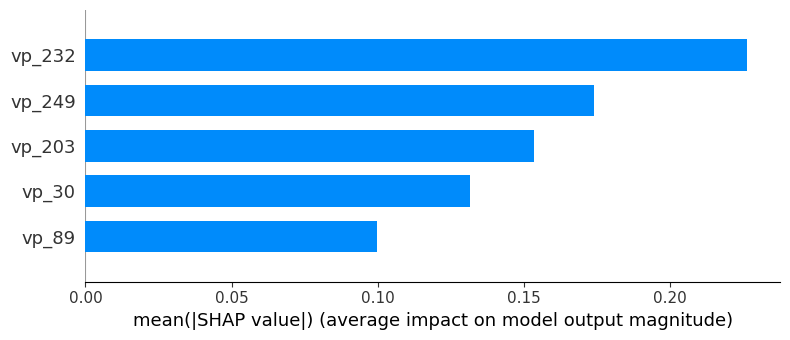

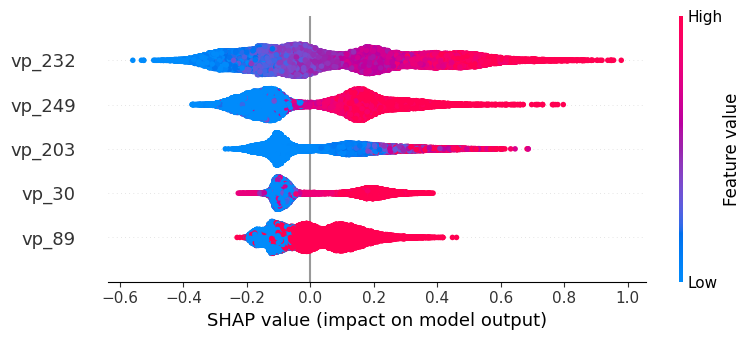

In [274]:
# Criar explainer para o modelo treinado
explainer = shap.TreeExplainer(lgbm)

# Calcular SHAP values no conjunto de teste
shap_values = explainer.shap_values(X_test_safra_encoded)

# Se for classificação binária, shap_values será uma lista: [classe_0, classe_1]
# Pegamos a classe positiva (inadimplência = 1)
shap_vals_class1 = shap_values[1] if isinstance(shap_values, list) else shap_values

# Importância média das features (valor absoluto dos SHAP values)
importances = np.abs(shap_vals_class1).mean(axis=0)

# Pegar top 5 variáveis mais importantes
indices = np.argsort(importances)[::-1][:5]
top_features = X_train_safra_encoded.columns[indices]

print("Top 5 variáveis mais importantes:", top_features.tolist())

# --- Visualizações apenas para as top 5 ---
X_top5 = X_test_safra_encoded[top_features]
shap_vals_top5 = shap_vals_class1[:, indices]

# Gráfico de barras das importâncias
shap.summary_plot(shap_vals_top5, X_top5, plot_type="bar", max_display=5)

# Gráfico de resumo detalhado (impacto individual das variáveis)
shap.summary_plot(shap_vals_top5, X_top5, max_display=5)

# Aplicando na base OOT

In [245]:
base_oot

id  safra_concessao          regiao faixa_idade    faixa_renda  \
0          1           202312             SUL   51 ATÉ 55  1500 ATÉ 2000   
1          2           202312        NORDESTE   31 ATÉ 35  6000 ATÉ 7000   
2          3           202312             SUL   31 ATÉ 35  4000 ATÉ 5000   
3          4           202312         SUDESTE   36 ATÉ 40  5000 ATÉ 6000   
4          5           202312  SEM INFORMAÇÃO   31 ATÉ 35  2000 ATÉ 2500   
...      ...              ...             ...         ...            ...   
36739  36740           202312         SUDESTE   26 ATÉ 30  1500 ATÉ 2000   
36740  36741           202312         SUDESTE   46 ATÉ 50  1500 ATÉ 2000   
36741  36742           202312  SEM INFORMAÇÃO   21 ATÉ 25  2000 ATÉ 2500   
36742  36743           202312        NORDESTE   21 ATÉ 25  1000 ATÉ 1500   
36743  36744           202312  SEM INFORMAÇÃO   36 ATÉ 40  1000 ATÉ 1500   

        vp_1   vp_2   vp_3  vp_4        vp_5        vp_6        vp_7    vp_8  \
0      541.0   65.0   78.0   2.0  128.955830  133.928809  118.541335  3496.0   
1        0.0    0.0  379.0   0.0  113.567970  105.622693  111.103774  2184.0   
2        0.0    0.0   90.0   0.0    8.794996   10.623740    6.868247  1348.0   
3        0.0    0.0   65.0   1.0  148.284410  166.676938  193.034108   972.0   
4        0.0    0.0   36.0   0.0  169.461650  138.987916  145.405744  2992.0   
...      ...    ...    ...   ...         ...         ...         ...     ...   
36739    0.0    0.0  115.0   0.0  140.869110  125.066337  162.900823   716.0   
36740  198.0    0.0  205.0   1.0    0.000000    0.000000    0.000000     0.0   
36741    0.0    0.0   36.0   0.0  114.428050  121.364359  190.623703   657.0   
36742    0.0  190.0  193.0   2.0  152.727070  139.178158  126.955663   794.0   
36743    0.0  268.0   36.0   3.0    0.000000    0.000000    0.000000     0.0   

       vp_9  vp_10  vp_11     vp_12     vp_13      vp_14      vp_15  vp_16  \
0      15.0   15.0   38.0  0.000000  0.377404   0.663093   0.959118    0.7   
1      19.0   21.0   51.0  0.000000  9.992000   5.164728   3.313283    5.6   
2      19.0   19.0   47.0  0.000000  0.000000  10.212286   8.533017    2.7   
3      20.0   24.0   54.0  0.105135  0.611729   2.143715   1.620271    0.5   
4      23.0   23.0   52.0  0.000000  0.000000  39.075533  20.637295    4.0   
...     ...    ...    ...       ...       ...        ...        ...    ...   
36739  31.0   30.0   69.0  3.842503  0.000000   0.000000  88.490856    0.0   
36740  21.0   25.0   59.0  0.000000  0.000000   0.000000   0.000000    0.0   
36741  23.0   23.0   52.0  1.449687  1.844510   6.765196   5.273970    6.3   
36742  25.0   24.0   59.0  0.393004  3.265420  47.780906  36.437066    5.1   
36743  23.0   23.0   52.0  0.000000  0.000000   0.000000   0.000000    0.0   

       vp_17  vp_18  vp_19  vp_20  vp_21    vp_22    vp_23    vp_24    vp_25  \
0       32.0  585.0  524.0  617.0  583.0  0.92716  0.32009  0.67555  0.79353   
1       54.0  330.0  326.0  383.0  566.0  1.06109  0.40844  1.16176  1.29963   
2       58.0  322.0  317.0  378.0  573.0  1.05004  0.42726  1.06930  1.19823   
3       53.0  278.0  265.0  329.0  549.0  1.03586  0.61496  1.59389  1.87430   
4       51.0  205.0  201.0  253.0  517.0  1.11827  0.29132  0.99801  1.15904   
...      ...    ...    ...    ...    ...      ...      ...      ...      ...   
36739   47.0  182.0  169.0  226.0  442.0  1.06438  0.36667  1.40132  1.68461   
36740   58.0  273.0  261.0  329.0  535.0  1.01839  0.57581  1.46747  1.67771   
36741   51.0  205.0  201.0  253.0  517.0  1.11827  0.29132  0.99801  1.15904   
36742   38.0  232.0  224.0  268.0  498.0  1.09691  0.31333  1.24196  1.52961   
36743   51.0  205.0  201.0  253.0  517.0  1.11827  0.29132  0.99801  1.15904   

        vp_26   vp_27   vp_28   vp_29       vp_30       vp_31  vp_32   vp_33  \
0      2570.0  1538.0  3496.0   628.0  100.000000  100.000000   0.00  200.00   
1      6998.0  4506.0  2184.0  2891.0   33.333332   66.666664   0.00    0.00  

In [246]:
treino

adimplencia regiao faixa_idade faixa_renda        vp_6     vp_12  \
1                1  NORTE         NaN         NaN    0.000000  0.000000   
3                1  NORTE         NaN         NaN  172.628494  0.000000   
4                1  NORTE         NaN         NaN  120.336091  0.148492   
5                1  NORTE         NaN         NaN    0.000000  0.000000   
9                1  NORTE         NaN         NaN   82.675501  1.861017   
...            ...    ...         ...         ...         ...       ...   
99098            1  NORTE         NaN         NaN   54.039493  0.000000   
99099            1  NORTE         NaN         NaN   90.361347  0.000000   
99100            1  NORTE         NaN         NaN  166.840603  0.000000   
99102            1  NORTE         NaN         NaN  142.939726  8.430648   
99103            1  NORTE         NaN         NaN   13.784899  0.000000   

           vp_13       vp_14       vp_15  vp_17    vp_22   vp_27   vp_29  \
1       0.000000    0.000000    0.000000   44.0  1.03695     0.0     0.0   
3       0.182127    0.147196    0.208389   61.0  1.03117  1276.0  1026.0   
4       2.973459    2.333763    1.419896   44.0  1.03995   496.0   130.0   
5       0.000000    0.000000    0.000000   51.0  1.04009     0.0     0.0   
9       0.000000    0.013367    0.047774   47.0  1.07555   248.0     0.0   
...          ...         ...         ...    ...      ...     ...     ...   
99098  10.589566  175.970102  288.613348   48.0  1.04208    71.0    35.0   
99099   4.572694    2.596829    2.713313   38.0  1.04487   259.0     1.0   
99100   0.000000    0.875078    2.618878   27.0  1.02509  1070.0   471.0   
99102   2.276360    0.000000    0.000000   48.0  1.02246  1628.0     8.0   
99103  13.924706   79.938799   73.737723   58.0  1.03778   115.0    27.0   

            vp_30   vp_37   vp_38  vp_39  vp_40  vp_41     vp_42     vp_43  \
1        0.000000     0.0     0.0    1.0    0.0    0.0  1.000000  1.000000   
3      100.000000  1000.0  1000.0  567.0  261.0  261.0  1.076515  0.913465   
4       93.333336   720.0   775.0  556.0   36.0  102.0  1.157565  1.123745   
5        0.000000     0.0     0.0    1.0    0.0    0.0  1.000000  1.000000   
9      100.000000  1000.0   389.0  492.0   44.0  196.0  0.663834  1.254792   
...           ...     ...     ...    ...    ...    ...       ...       ...   
99098   75.000000     0.0     0.0  922.0   29.0  110.0  0.149259  0.562463   
99099   88.888885   858.0   824.0  537.0   23.0   67.0  0.771170  0.855548   
99100  100.000000     0.0   786.0  276.0  145.0  145.0  1.297493  1.121757   
99102   66.666664     0.0     0.0  201.0  107.0  107.0  1.201555  1.387862   
99103   55.555557     0.0     0.0  656.0   35.0   35.0  0.293496  1.786450   

       vp_46       vp_47    vp_56    vp_65  vp_66      vp_67      vp_68  \
1        0.0  69900613.0   8485.0  1.30715   34.0   0.000000   0.000000   
3       12.0  69058120.0   8767.0  1.31952   43.0   0.000000   0.000000   
4       30.0  69050190.0  10937.0  1.35281   49.0   0.000000   0.000000   
5        0.0  69312453.0  16912.0  1.42291   36.0   0.000000   0.000000   
9       13.0  68270000.0   9917.0  1.46397   42.0   0.000000   0.000000   
...      ...         ...      ...      ...    ...        ...        ...   
99098   11.0  68515000.0   5163.0  1.50111   44.0   2.754376   1.780614   
99099   16.0  68590000.0   2839.0  1.34257   37.0  14.974898  23.624578   
99100    5.0  76995000.0   6301.0  1.37634   28.0   0.000000   0.000000   
99102    6.0  77817375.0   8371.0  1.62252   37.0   0.000000   0.000000   
99103   10.0  68537000.0   3009.0  1.57919   48.0  24.012094  26.163946   

       vp_69   vp_77  vp_81   vp_83         vp_89  vp_100  vp_101  vp_105  \
1        0.0     1.0   62.0     0.0 -1.000000e+07   500.0     3.0     3.0   
3        0.0     1.0   68.0  1000.0  1.043312e+00   189.0     2.0     0.0   
4        0.0     1.0   71.0  1000.0  9.369186e-01    83.0     1.0     3.0   
5        0.0     1.0   74.0     0.0  4.477008e-

##  Divisão treino e teste baseado na safra

In [247]:
print(treino.shape, teste.shape)

(73224, 108) (25880, 110)


### Salvar as informações sobre cliente e safra de concessão (no modelo não são variáveis que serão utilizadas)

In [248]:
aux = base_oot.copy()

In [249]:
# treino_id_safra = treino[["id", "safra_concessao"]]
aux_id_safra  = aux[["id", "safra_concessao"]]

In [250]:
# treino = treino.drop(columns=["id", "safra_concessao"])
aux  = aux.drop(columns=["id", "safra_concessao"])

In [251]:
# Pega somente as colunas em comum entre df1 e df2
aux = aux[treino.columns.intersection(aux.columns)]
print(aux.shape)
print(treino.shape)

(36744, 107)
(73224, 108)


In [252]:
treino.head()

adimplencia regiao faixa_idade faixa_renda        vp_6     vp_12     vp_13  \
1            1  NORTE         NaN         NaN    0.000000  0.000000  0.000000   
3            1  NORTE         NaN         NaN  172.628494  0.000000  0.182127   
4            1  NORTE         NaN         NaN  120.336091  0.148492  2.973459   
5            1  NORTE         NaN         NaN    0.000000  0.000000  0.000000   
9            1  NORTE         NaN         NaN   82.675501  1.861017  0.000000   

      vp_14     vp_15  vp_17    vp_22   vp_27   vp_29       vp_30   vp_37  \
1  0.000000  0.000000   44.0  1.03695     0.0     0.0    0.000000     0.0   
3  0.147196  0.208389   61.0  1.03117  1276.0  1026.0  100.000000  1000.0   
4  2.333763  1.419896   44.0  1.03995   496.0   130.0   93.333336   720.0   
5  0.000000  0.000000   51.0  1.04009     0.0     0.0    0.000000     0.0   
9  0.013367  0.047774   47.0  1.07555   248.0     0.0  100.000000  1000.0   

    vp_38  vp_39  vp_40  vp_41     vp_42     vp_43  vp_46       vp_47  \
1     0.0    1.0    0.0    0.0  1.000000  1.000000    0.0  69900613.0   
3  1000.0  567.0  261.0  261.0  1.076515  0.913465   12.0  69058120.0   
4   775.0  556.0   36.0  102.0  1.157565  1.123745   30.0  69050190.0   
5     0.0    1.0    0.0    0.0  1.000000  1.000000    0.0  69312453.0   
9   389.0  492.0   44.0  196.0  0.663834  1.254792   13.0  68270000.0   

     vp_56    vp_65  vp_66  vp_67  vp_68  vp_69  vp_77  vp_81   vp_83  \
1   8485.0  1.30715   34.0    0.0    0.0    0.0    1.0   62.0     0.0   
3   8767.0  1.31952   43.0    0.0    0.0    0.0    1.0   68.0  1000.0   
4  10937.0  1.35281   49.0    0.0    0.0    0.0    1.0   71.0  1000.0   
5  16912.0  1.42291   36.0    0.0    0.0    0.0    1.0   74.0     0.0   
9   9917.0  1.46397   42.0    0.0    0.0    0.0    1.0   48.0  1000.0   

          vp_89  vp_100  vp_101  vp_105  vp_108  vp_127  vp_130  vp_134  \
1 -1.000000e+07   500.0     3.0     3.0  3329.0   717.0    22.0    85.0   
3  1.043312e+00   189.0     2.0     0.0     0.0   694.0    35.0    29.0   
4  9.369186e-01    83.0     1.0     3.0    34.0   706.0    20.0    80.0   
5  4.477008e-01   369.0     2.0     3.0   721.0   688.0     0.0   100.0   
9  1.083361e+00  1145.0     7.0     0.0     0.0   680.0     0.0   100.0   

   vp_135  vp_136  vp_139  vp_142  vp_143   vp_144  vp_146  vp_148  vp_149  \
1    11.0   184.0   100.0     0.0     0.0    159.0   147.0  1705.0     5.0   
3     0.0   418.0     0.0     0.0     0.0      0.0     0.0     0.0     0.0   
4     0.0   422.0   100.0     0.0     0.0    562.0    13.0    32.0     1.0   
5     0.0   304.0   100.0     0.0     0.0  19360.0  1033.0  1033.0    33.0   
9     0.0   153.0     0.0     0.0     0.0      0.0     0.0     0.0     0.0   

   vp_150  vp_152  vp_153  vp_154  vp_155  vp_156  vp_170  vp_172  vp_175  \
1    61.0    51.0    -1.0    15.0    15.0    51.0     0.0    72.0     0.0   
3     0.0    -1.0    -1.0    -1.0    -1.0    -1.0     0.0   860.0     5.0   
4    59.0    37.0    -1.0    36.0    41.0    41.0     6.0     6.0     1.0   
5    33.0     8.0    -1.0    -1.0    41.0    41.0   686.0    18.0     0.0   
9     0.0    -1.0    -1.0    -1.0    -1.0    -1.0     0.0   935.0     0.0   

   vp_177  vp_183  vp_186  vp_187  vp_188  vp_196  vp_198  vp_199  vp_202  \
1    17.0     2.0     0.0     1.0    10.0     4.0     0.0   -77.0     0.0   
3     9.0     1.0     0.0     0.0     0.0     0.0     0.0   -99.0  1498.0   
4    30.0     0.0     0.0     0.0     5.0     6.0   351.0    25.0  1573.0   
5    41.0     0.0     0.0     1.0     3.0     4.0     0.0    50.0  2604.0   
9     0.0     0.0     0.0     0.0     0.0     0.0     0.0   -99.0   248.0   

   vp_203  vp_204   vp_205    vp_207  vp_208  vp_211  vp_212  vp_213  vp_214  \
1     0.0     0.0      0.0  0.000000     0.0     0.0     0.0     0.0     0.0   
3  3763.0  1026.0   4209.0  0.000000     0.0     0.0     0.0     0.0  1000.0   
4  5236.0   130.0  22767.0  0.166667     1.0     0.0     0.0     0.0  1000.0   
5  2604.0

In [253]:
aux.head()

regiao faixa_idade    faixa_renda        vp_6     vp_12     vp_13  \
0             SUL   51 ATÉ 55  1500 ATÉ 2000  133.928809  0.000000  0.377404   
1        NORDESTE   31 ATÉ 35  6000 ATÉ 7000  105.622693  0.000000  9.992000   
2             SUL   31 ATÉ 35  4000 ATÉ 5000   10.623740  0.000000  0.000000   
3         SUDESTE   36 ATÉ 40  5000 ATÉ 6000  166.676938  0.105135  0.611729   
4  SEM INFORMAÇÃO   31 ATÉ 35  2000 ATÉ 2500  138.987916  0.000000  0.000000   

       vp_14      vp_15  vp_17    vp_22   vp_27   vp_29       vp_30   vp_37  \
0   0.663093   0.959118   32.0  0.92716  1538.0   628.0  100.000000     0.0   
1   5.164728   3.313283   54.0  1.06109  4506.0  2891.0   33.333332     0.0   
2  10.212286   8.533017   58.0  1.05004    90.0    90.0  100.000000  1000.0   
3   2.143715   1.620271   53.0  1.03586   484.0    22.0  100.000000  1000.0   
4  39.075533  20.637295   51.0  1.11827   674.0   459.0  100.000000     0.0   

   vp_38  vp_39  vp_40  vp_41     vp_42     vp_43  vp_46       vp_47   vp_56  \
0    0.0  587.0  115.0  115.0  1.038563  0.885107    6.0  89515000.0  5503.0   
1  502.0  791.0   72.0   72.0  0.930039  1.051893    4.0  45430000.0  1893.0   
2   61.0  842.0   45.0  165.0  1.207930  0.646500    6.0  97545370.0  4903.0   
3  781.0  604.0   43.0   43.0  1.124035  1.158133   18.0  13223160.0  4808.0   
4    0.0  455.0   99.0   99.0  0.820173  1.046175    6.0         0.0  1586.0   

     vp_65  vp_66     vp_67  vp_68  vp_69   vp_77  vp_81   vp_83     vp_89  \
0  1.09778   33.0  0.000000    0.0    0.0  1000.0   83.0     0.0  1.067063   
1  1.44526   39.0  0.000000    0.0    0.0     1.0   57.0     0.0  0.954694   
2  1.58511   32.0  0.000000    0.0    0.0     1.0   88.0  1000.0  0.649146   
3  1.44426   42.0  0.666667    0.5    0.8  1000.0   76.0     0.0  1.039810   
4  1.60609   43.0  0.000000    0.0    0.0     1.0   66.0     0.0  1.165299   

   vp_100  vp_101  vp_105  vp_108  vp_127  vp_130  vp_134  vp_135  vp_136  \
0     0.0     0.0     0.0     0.0   751.0     0.0    81.0    18.0   125.0   
1   709.0     5.0     0.0   397.0   669.0     0.0   100.0     0.0    40.0   
2   114.0     2.0     7.0    31.0   679.0     8.0    95.0     9.0   156.0   
3   622.0     4.0     9.0    15.0   683.0     0.0    98.0     2.0   298.0   
4   102.0     1.0     0.0     0.0   644.0    80.0    67.0     0.0     2.0   

   vp_139  vp_142  vp_143  vp_144  vp_146  vp_148  vp_149  vp_150  vp_152  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    -1.0   
1   100.0     0.0     0.0     0.0    18.0    18.0     0.0    52.0    43.0   
2   100.0     0.0  2308.0  3752.0   127.0   127.0     4.0     4.0     1.0   
3   100.0     0.0     0.0     0.0   260.0     0.0     0.0     8.0    31.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    -1.0   

   vp_153  vp_154  vp_155  vp_156  vp_170  vp_172  vp_175  vp_177  vp_183  \
0    -1.0    -1.0    -1.0    -1.0   632.0    14.0     1.0    13.0     2.0   
1    -1.0    -1.0    -1.0    -1.0     0.0   599.0     0.0     6.0     0.0   
2     5.0     5.0     5.0     5.0   501.0    18.0     2.0    27.0     2.0   
3    -1.0    -1.0    39.0    39.0   169.0   169.0     1.0    41.0     2.0   
4    -1.0    -1.0    -1.0    -1.0    96.0    96.0     1.0     2.0     1.0   

   vp_186  vp_187  vp_188  vp_196  vp_198  vp_199  vp_202  vp_203  vp_204  \
0     0.0     0.0     0.0     7.0     0.0   -99.0   628.0  1395.0   262.0   
1     0.0     0.0     1.0     1.0     0.0   100.0  1121.0  2120.0   335.0   
2     0.0    10.0    12.0     5.0  2308.0    29.0   891.0   981.0    90.0   
3     0.0     0.0     1.0     8.0     0.0   -77.0   560.0  1410.0    22.0   
4     0.0     0.0     0.0     1.0     0.0   -99.0   818.0   166.0   459.0   

   vp_205    vp_207  vp_208  vp_211  vp_212  vp_213  vp_214    vp_216  vp_217  \
0  1987.0  0.000000     0.0     0.0     0.0     0.0  1000.0  38100.44    32.0   
1  6292.0  0.000000     0.0     0.0     0.0     0.0  1000.0  14331.07    35.0   
2   928.0 

##  Ajustando colunas 'faixa_idade' e 'faixa_renda'

### Faixa Renda

In [254]:
# Dicionário de mapeamento
mapa_faixa_renda = {
    # Baixa renda
    "700 ATÉ 1000": "<=1500",
    "1000 ATÉ 1500": "<=1500",

    # Renda média baixa
    "1500 ATÉ 2000": "1500–2500",
    "2000 ATÉ 2500": "1500–2500",

    # Renda média/alta
    "2500 ATÉ 3000": "2500–7000",
    "3000 ATÉ 3500": "2500–7000",
    "3500 ATÉ 4000": "2500–7000",
    "4000 ATÉ 5000": "2500–7000",
    "5000 ATÉ 6000": "2500–7000",
    "6000 ATÉ 7000": "2500–7000",

    # Alta renda
    "7000 ATÉ 8000": ">7000",
    "8000 ATÉ 9000": ">7000",
    "9000 ATÉ 10000": ">7000",
    "10000 ATÉ 12500": ">7000",
    "12500 ATÉ 15000": ">7000",
    "17500 ATÉ 20000": ">7000",
    "20000 ATÉ 25000": ">7000",
    "25000 ATÉ 30000": ">7000",
    "30000 ATÉ 35000": ">7000"
}

# Cria nova coluna com grupos reduzidos
treino["faixa_renda"] = treino["faixa_renda"].map(mapa_faixa_renda)
aux["faixa_renda"] = aux["faixa_renda"].map(mapa_faixa_renda)

In [255]:
aux["faixa_renda"].value_counts()

faixa_renda
1500–2500    20711
2500–7000     6048
<=1500        5608
>7000         3974
Name: count, dtype: int64

### Faixa Idade

In [256]:
mapa_faixa_idade = {
    "18 ATÉ 20": "<=25",
    "21 ATÉ 25": "<=25",

    "26 ATÉ 30": "26–40",
    "31 ATÉ 35": "26–40",
    "36 ATÉ 40": "26–40",

    "41 ATÉ 45": "41–60",
    "46 ATÉ 50": "41–60",
    "51 ATÉ 55": "41–60",
    "56 ATÉ 60": "41–60",

    "61 ATÉ 65": "61+",
    "66 ATÉ 70": "61+",
    "71 ATÉ 75": "61+",
    "ACIMA 80": "61+"
}

treino["faixa_idade"] = treino["faixa_idade"].map(mapa_faixa_idade)
aux["faixa_idade"] = aux["faixa_idade"].map(mapa_faixa_idade)

In [257]:
aux['faixa_idade'].value_counts()

faixa_idade
41–60    14918
26–40    12821
<=25      4794
61+       3914
Name: count, dtype: int64

## OneHotEncoder

In [258]:
# Selecionando os nomes das colunas do tipo 'object' e salvando em uma lista
object_columns = treino.select_dtypes(include='object').columns.tolist()
object_columns_base_oot = aux.select_dtypes(include='object').columns.tolist()

In [259]:
treino.head()

adimplencia regiao faixa_idade faixa_renda        vp_6     vp_12     vp_13  \
1            1  NORTE         NaN         NaN    0.000000  0.000000  0.000000   
3            1  NORTE         NaN         NaN  172.628494  0.000000  0.182127   
4            1  NORTE         NaN         NaN  120.336091  0.148492  2.973459   
5            1  NORTE         NaN         NaN    0.000000  0.000000  0.000000   
9            1  NORTE         NaN         NaN   82.675501  1.861017  0.000000   

      vp_14     vp_15  vp_17    vp_22   vp_27   vp_29       vp_30   vp_37  \
1  0.000000  0.000000   44.0  1.03695     0.0     0.0    0.000000     0.0   
3  0.147196  0.208389   61.0  1.03117  1276.0  1026.0  100.000000  1000.0   
4  2.333763  1.419896   44.0  1.03995   496.0   130.0   93.333336   720.0   
5  0.000000  0.000000   51.0  1.04009     0.0     0.0    0.000000     0.0   
9  0.013367  0.047774   47.0  1.07555   248.0     0.0  100.000000  1000.0   

    vp_38  vp_39  vp_40  vp_41     vp_42     vp_43  vp_46       vp_47  \
1     0.0    1.0    0.0    0.0  1.000000  1.000000    0.0  69900613.0   
3  1000.0  567.0  261.0  261.0  1.076515  0.913465   12.0  69058120.0   
4   775.0  556.0   36.0  102.0  1.157565  1.123745   30.0  69050190.0   
5     0.0    1.0    0.0    0.0  1.000000  1.000000    0.0  69312453.0   
9   389.0  492.0   44.0  196.0  0.663834  1.254792   13.0  68270000.0   

     vp_56    vp_65  vp_66  vp_67  vp_68  vp_69  vp_77  vp_81   vp_83  \
1   8485.0  1.30715   34.0    0.0    0.0    0.0    1.0   62.0     0.0   
3   8767.0  1.31952   43.0    0.0    0.0    0.0    1.0   68.0  1000.0   
4  10937.0  1.35281   49.0    0.0    0.0    0.0    1.0   71.0  1000.0   
5  16912.0  1.42291   36.0    0.0    0.0    0.0    1.0   74.0     0.0   
9   9917.0  1.46397   42.0    0.0    0.0    0.0    1.0   48.0  1000.0   

          vp_89  vp_100  vp_101  vp_105  vp_108  vp_127  vp_130  vp_134  \
1 -1.000000e+07   500.0     3.0     3.0  3329.0   717.0    22.0    85.0   
3  1.043312e+00   189.0     2.0     0.0     0.0   694.0    35.0    29.0   
4  9.369186e-01    83.0     1.0     3.0    34.0   706.0    20.0    80.0   
5  4.477008e-01   369.0     2.0     3.0   721.0   688.0     0.0   100.0   
9  1.083361e+00  1145.0     7.0     0.0     0.0   680.0     0.0   100.0   

   vp_135  vp_136  vp_139  vp_142  vp_143   vp_144  vp_146  vp_148  vp_149  \
1    11.0   184.0   100.0     0.0     0.0    159.0   147.0  1705.0     5.0   
3     0.0   418.0     0.0     0.0     0.0      0.0     0.0     0.0     0.0   
4     0.0   422.0   100.0     0.0     0.0    562.0    13.0    32.0     1.0   
5     0.0   304.0   100.0     0.0     0.0  19360.0  1033.0  1033.0    33.0   
9     0.0   153.0     0.0     0.0     0.0      0.0     0.0     0.0     0.0   

   vp_150  vp_152  vp_153  vp_154  vp_155  vp_156  vp_170  vp_172  vp_175  \
1    61.0    51.0    -1.0    15.0    15.0    51.0     0.0    72.0     0.0   
3     0.0    -1.0    -1.0    -1.0    -1.0    -1.0     0.0   860.0     5.0   
4    59.0    37.0    -1.0    36.0    41.0    41.0     6.0     6.0     1.0   
5    33.0     8.0    -1.0    -1.0    41.0    41.0   686.0    18.0     0.0   
9     0.0    -1.0    -1.0    -1.0    -1.0    -1.0     0.0   935.0     0.0   

   vp_177  vp_183  vp_186  vp_187  vp_188  vp_196  vp_198  vp_199  vp_202  \
1    17.0     2.0     0.0     1.0    10.0     4.0     0.0   -77.0     0.0   
3     9.0     1.0     0.0     0.0     0.0     0.0     0.0   -99.0  1498.0   
4    30.0     0.0     0.0     0.0     5.0     6.0   351.0    25.0  1573.0   
5    41.0     0.0     0.0     1.0     3.0     4.0     0.0    50.0  2604.0   
9     0.0     0.0     0.0     0.0     0.0     0.0     0.0   -99.0   248.0   

   vp_203  vp_204   vp_205    vp_207  vp_208  vp_211  vp_212  vp_213  vp_214  \
1     0.0     0.0      0.0  0.000000     0.0     0.0     0.0     0.0     0.0   
3  3763.0  1026.0   4209.0  0.000000     0.0     0.0     0.0     0.0  1000.0   
4  5236.0   130.0  22767.0  0.166667     1.0     0.0     0.0     0.0  1000.0   
5  2604.0

In [260]:
X_train_safra = treino.drop(columns=["adimplencia"])
y_train_safra = treino["adimplencia"]
X_test_safra = aux
# y_test_safra = teste["adimplencia"]

In [261]:
# Suponha que object_columns são as colunas categóricas
encoder = ce.OneHotEncoder(cols=object_columns, use_cat_names=True)

# Fit + transform no treino
X_train_safra_encoded = encoder.fit_transform(X_train_safra)

# Transform no teste com o encoder já ajustado
X_test_safra_encoded = encoder.transform(X_test_safra)

In [262]:
print(X_train_safra_encoded.shape)
print(X_test_safra_encoded.shape)

(73224, 112)
(36744, 112)


##  Gerando os escores com Regressão Logística e LightGBM

### Gerar scores

In [263]:
def proba_to_score(y_proba):
    """
    Converte probabilidades (0..1) em scores inteiros (0..999).
    - p * 1000 -> [0..1000)
    - floor e clip para garantir [0..999]
    """
    y_proba = np.asarray(y_proba, dtype=float)
    scores = np.floor(y_proba * 1000).astype(int)
    scores = np.clip(scores, 0, 999)
    return scores

# Exemplo com array/Series de probabilidades da classe 1 (adimplente):
# y_proba = pipeline.predict_proba(X_val)[:, 1]
# scores = proba_to_score(y_proba)
# print(scores[:10])

# Se quiser anexar ao DataFrame de validação:
# df_val = pd.DataFrame(X_val)  # se X_val não for DataFrame
# df_val["score_0_999"] = proba_to_score(y_proba)

### Reaplicando o modelo para Regressão Logística

In [264]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

In [265]:
# Converter probabilidades em scores (0–999)
scores = proba_to_score(y_proba)

# Exibir os primeiros scores
print(scores[:20])

[781 815 853 722 847 926 528 582 666 455 590 620 728 535 689 745 474 634
 618 817]


In [266]:
base_oot['score_modelo_A'] = scores

### Reaplicando o modelo para LightGBM

In [267]:
# Criar modelo LightGBM com parâmetros ajustados
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)


# Treinar o modelo final no treino inteiro
lgbm.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no conjunto de teste
y_pred = lgbm.predict(X_test_safra_encoded)
y_proba = lgbm.predict_proba(X_test_safra_encoded)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62001, number of negative: 11223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18834
[LightGBM] [Info] Number of data points in the train set: 73224, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846731 -> initscore=1.709185
[LightGBM] [Info] Start training from score 1.709185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [268]:
# Converter probabilidades em scores_B (0–999)
scores_B = proba_to_score(y_proba)

# Exibir os primeiros scores_B
print(scores_B[:20])

[893 911 891 873 930 897 676 749 604 318 630 814 903 368 661 719 590 555
 783 822]


In [269]:
base_oot['score_modelo_B'] = scores_B

In [270]:
base_oot.head(15)

id  safra_concessao           regiao faixa_idade    faixa_renda   vp_1  \
0    1           202312              SUL   51 ATÉ 55  1500 ATÉ 2000  541.0   
1    2           202312         NORDESTE   31 ATÉ 35  6000 ATÉ 7000    0.0   
2    3           202312              SUL   31 ATÉ 35  4000 ATÉ 5000    0.0   
3    4           202312          SUDESTE   36 ATÉ 40  5000 ATÉ 6000    0.0   
4    5           202312   SEM INFORMAÇÃO   31 ATÉ 35  2000 ATÉ 2500    0.0   
5    6           202312              SUL   36 ATÉ 40  2000 ATÉ 2500    0.0   
6    7           202312            NORTE   31 ATÉ 35  5000 ATÉ 6000    0.0   
7    8           202312         NORDESTE   36 ATÉ 40  2000 ATÉ 2500    0.0   
8    9           202312          SUDESTE   31 ATÉ 35  1500 ATÉ 2000    0.0   
9   10           202312  CENTRO-OESTE/DF   26 ATÉ 30  1500 ATÉ 2000    0.0   
10  11           202312              SUL   18 ATÉ 20  1500 ATÉ 2000    0.0   
11  12           202312         NORDESTE   36 ATÉ 40  2000 ATÉ 2500    0.0   
12  13           202312              SUL   51 ATÉ 55  2000 ATÉ 2500    0.0   
13  14           202312          SUDESTE   61 ATÉ 65  1000 ATÉ 1500    0.0   
14  15           202312              SUL   18 ATÉ 20  1000 ATÉ 1500    0.0   

    vp_2   vp_3  vp_4        vp_5        vp_6        vp_7    vp_8  vp_9  \
0   65.0   78.0   2.0  128.955830  133.928809  118.541335  3496.0  15.0   
1    0.0  379.0   0.0  113.567970  105.622693  111.103774  2184.0  19.0   
2    0.0   90.0   0.0    8.794996   10.623740    6.868247  1348.0  19.0   
3    0.0   65.0   1.0  148.284410  166.676938  193.034108   972.0  20.0   
4    0.0   36.0   0.0  169.461650  138.987916  145.405744  2992.0  23.0   
5    0.0   61.0   0.0  150.000000   72.503497   96.704390  4050.0  12.0   
6    0.0  157.0   0.0  110.482315   65.006538   47.345845  3035.0  27.0   
7    0.0  221.0   0.0  121.290630  157.637457   28.396645  3877.0  22.0   
8    0.0   59.0   0.0   34.155155   43.884123    2.598012   834.0  22.0   
9    0.0  247.0   0.0  200.000000  180.881386  200.000000   461.0  27.0   
10   0.0    7.0   0.0  200.000000  200.000000  200.000000    93.0  11.0   
11   0.0  371.0   1.0   42.522310   43.005545   41.550024   995.0  19.0   
12   0.0   50.0   1.0   77.062065   80.713272   27.109907  1327.0  14.0   
13   0.0   53.0   0.0    0.000000    0.000000    0.000000  5673.0  17.0   
14   0.0   61.0   0.0  199.375180  150.170361  200.000000   375.0  15.0   

    vp_10  vp_11     vp_12      vp_13       vp_14       vp_15  vp_16  vp_17  \
0    15.0   38.0  0.000000   0.377404    0.663093    0.959118    0.7   32.0   
1    21.0   51.0  0.000000   9.992000    5.164728    3.313283    5.6   54.0   
2    19.0   47.0  0.000000   0.000000   10.212286    8.533017    2.7   58.0   
3    24.0   54.0  0.105135   0.611729    2.143715    1.620271    0.5   53.0   
4    23.0   52.0  0.000000   0.000000   39.075533   20.637295    4.0   51.0   
5    13.0   31.0  0.000000   0.373582    0.392743    0.394160    0.4   33.0   
6    30.0   68.0  6.130209   7.435634  204.657091  179.809034  116.3   66.0   
7    24.0   58.0  1.799563   2.688974    1.454711   77.095279    1.1   42.0   
8    23.0   56.0  6.000000   0.000000    0.000000  364.307709    0.0   42.0   
9    25.0   58.0  0.000000  25.000000    3.768500    2.675679    3.8   54.0   
10   12.0   27.0  0.000000   0.000000    0.000000    0.000000    0.0   43.0   
11   21.0   50.0  0.000000   1.030705    0.667099    0.727676    1.3   43.0   
12   19.0   45.0  0.000000   0.739442    0.725527  233.317262    0.7   45.0   
13   22.0   53.0  0.000000   0.000000  109.601109   85.668637   98.6   45.0   
14   18.0   38.0  2.247224   0.000000   69.689116   65.900384   17.7   53.0   

    vp_18  vp_19  vp_20  vp_21    vp_22    vp_23    vp_24    vp_25   vp_26  \
0   585.0  524.0  617.0  583.0  0.92716  0.32009  0.67555  0.79353  2570.0   
1   330.0  326.0  383.0  566.0  1.06109  0.40844  1.16176  1.29963  6998.0   
2   322.0  317.0  378.0  573.0  1.05004  0.42726  1.069

##  Reconstruindo a base

In [271]:
print(base_oot.shape)
base_oot

(36744, 340)


id  safra_concessao          regiao faixa_idade    faixa_renda  \
0          1           202312             SUL   51 ATÉ 55  1500 ATÉ 2000   
1          2           202312        NORDESTE   31 ATÉ 35  6000 ATÉ 7000   
2          3           202312             SUL   31 ATÉ 35  4000 ATÉ 5000   
3          4           202312         SUDESTE   36 ATÉ 40  5000 ATÉ 6000   
4          5           202312  SEM INFORMAÇÃO   31 ATÉ 35  2000 ATÉ 2500   
...      ...              ...             ...         ...            ...   
36739  36740           202312         SUDESTE   26 ATÉ 30  1500 ATÉ 2000   
36740  36741           202312         SUDESTE   46 ATÉ 50  1500 ATÉ 2000   
36741  36742           202312  SEM INFORMAÇÃO   21 ATÉ 25  2000 ATÉ 2500   
36742  36743           202312        NORDESTE   21 ATÉ 25  1000 ATÉ 1500   
36743  36744           202312  SEM INFORMAÇÃO   36 ATÉ 40  1000 ATÉ 1500   

        vp_1   vp_2   vp_3  vp_4        vp_5        vp_6        vp_7    vp_8  \
0      541.0   65.0   78.0   2.0  128.955830  133.928809  118.541335  3496.0   
1        0.0    0.0  379.0   0.0  113.567970  105.622693  111.103774  2184.0   
2        0.0    0.0   90.0   0.0    8.794996   10.623740    6.868247  1348.0   
3        0.0    0.0   65.0   1.0  148.284410  166.676938  193.034108   972.0   
4        0.0    0.0   36.0   0.0  169.461650  138.987916  145.405744  2992.0   
...      ...    ...    ...   ...         ...         ...         ...     ...   
36739    0.0    0.0  115.0   0.0  140.869110  125.066337  162.900823   716.0   
36740  198.0    0.0  205.0   1.0    0.000000    0.000000    0.000000     0.0   
36741    0.0    0.0   36.0   0.0  114.428050  121.364359  190.623703   657.0   
36742    0.0  190.0  193.0   2.0  152.727070  139.178158  126.955663   794.0   
36743    0.0  268.0   36.0   3.0    0.000000    0.000000    0.000000     0.0   

       vp_9  vp_10  vp_11     vp_12     vp_13      vp_14      vp_15  vp_16  \
0      15.0   15.0   38.0  0.000000  0.377404   0.663093   0.959118    0.7   
1      19.0   21.0   51.0  0.000000  9.992000   5.164728   3.313283    5.6   
2      19.0   19.0   47.0  0.000000  0.000000  10.212286   8.533017    2.7   
3      20.0   24.0   54.0  0.105135  0.611729   2.143715   1.620271    0.5   
4      23.0   23.0   52.0  0.000000  0.000000  39.075533  20.637295    4.0   
...     ...    ...    ...       ...       ...        ...        ...    ...   
36739  31.0   30.0   69.0  3.842503  0.000000   0.000000  88.490856    0.0   
36740  21.0   25.0   59.0  0.000000  0.000000   0.000000   0.000000    0.0   
36741  23.0   23.0   52.0  1.449687  1.844510   6.765196   5.273970    6.3   
36742  25.0   24.0   59.0  0.393004  3.265420  47.780906  36.437066    5.1   
36743  23.0   23.0   52.0  0.000000  0.000000   0.000000   0.000000    0.0   

       vp_17  vp_18  vp_19  vp_20  vp_21    vp_22    vp_23    vp_24    vp_25  \
0       32.0  585.0  524.0  617.0  583.0  0.92716  0.32009  0.67555  0.79353   
1       54.0  330.0  326.0  383.0  566.0  1.06109  0.40844  1.16176  1.29963   
2       58.0  322.0  317.0  378.0  573.0  1.05004  0.42726  1.06930  1.19823   
3       53.0  278.0  265.0  329.0  549.0  1.03586  0.61496  1.59389  1.87430   
4       51.0  205.0  201.0  253.0  517.0  1.11827  0.29132  0.99801  1.15904   
...      ...    ...    ...    ...    ...      ...      ...      ...      ...   
36739   47.0  182.0  169.0  226.0  442.0  1.06438  0.36667  1.40132  1.68461   
36740   58.0  273.0  261.0  329.0  535.0  1.01839  0.57581  1.46747  1.67771   
36741   51.0  205.0  201.0  253.0  517.0  1.11827  0.29132  0.99801  1.15904   
36742   38.0  232.0  224.0  268.0  498.0  1.09691  0.31333  1.24196  1.52961   
36743   51.0  205.0  201.0  253.0  517.0  1.11827  0.29132  0.99801  1.15904   

        vp_26   vp_27   vp_28   vp_29       vp_30       vp_31  vp_32   vp_33  \
0      2570.0  1538.0  3496.0   628.0  100.000000  100.000000   0.00  200.00   
1      6998.0  4506.0  2184.0  2891.0   33.333332   66.666664   0.00    0.00  

In [272]:
base_oot.to_csv('base_oot.csv', index=False)

# Modelagem 2ª Análise (Seleção de menos features com base no IV)

##  Divisão treino e teste baseado nas safras (Até a safra 08, será treino. Safras 9,10,11 serão testes) manter a coerência temporal.

In [ ]:
print(treino2.shape)
print(teste2.shape)

(73224, 58)
(25880, 58)


### Separar informações como safra e id do cliente

In [ ]:
treino2_id_safra = treino2[["id", "safra_concessao"]]
teste2_id_safra  = teste2[["id", "safra_concessao"]]

In [ ]:
treino2 = treino2.drop(columns=["id", "safra_concessao"])
teste2  = teste2.drop(columns=["id", "safra_concessao"])

## OneHotEncoder

In [ ]:
# Selecionando os nomes das colunas do tipo 'object' e salvando em uma lista
object_columns = treino2.select_dtypes(include='object').columns.tolist()
object_columns_teste = teste2.select_dtypes(include='object').columns.tolist()

In [ ]:
treino2.head()

adimplencia regiao faixa_idade faixa_renda        vp_6     vp_12     vp_14  \
1            1  NORTE       41–60       >7000    0.000000  0.000000  0.000000   
3            1  NORTE       41–60       >7000  172.628494  0.000000  0.147196   
4            1  NORTE       41–60       >7000  120.336091  0.148492  2.333763   
5            1  NORTE       41–60       >7000    0.000000  0.000000  0.000000   
9            1  NORTE       41–60       >7000   82.675501  1.861017  0.013367   

      vp_15   vp_27   vp_29       vp_30   vp_37   vp_38  vp_39  vp_40  vp_41  \
1  0.000000     0.0     0.0    0.000000     0.0     0.0    1.0    0.0    0.0   
3  0.208389  1276.0  1026.0  100.000000  1000.0  1000.0  567.0  261.0  261.0   
4  1.419896   496.0   130.0   93.333336   720.0   775.0  556.0   36.0  102.0   
5  0.000000     0.0     0.0    0.000000     0.0     0.0    1.0    0.0    0.0   
9  0.047774   248.0     0.0  100.000000  1000.0   389.0  492.0   44.0  196.0   

      vp_42     vp_43  vp_46  vp_81   vp_83         vp_89  vp_100  vp_101  \
1  1.000000  1.000000    0.0   62.0     0.0 -1.000000e+07   500.0     3.0   
3  1.076515  0.913465   12.0   68.0  1000.0  1.043312e+00   189.0     2.0   
4  1.157565  1.123745   30.0   71.0  1000.0  9.369186e-01    83.0     1.0   
5  1.000000  1.000000    0.0   74.0     0.0  4.477008e-01   369.0     2.0   
9  0.663834  1.254792   13.0   48.0  1000.0  1.083361e+00  1145.0     7.0   

   vp_105  vp_127  vp_130  vp_134  vp_142   vp_144  vp_149  vp_150  vp_155  \
1     3.0   717.0    22.0    85.0     0.0    159.0     5.0    61.0    15.0   
3     0.0   694.0    35.0    29.0     0.0      0.0     0.0     0.0    -1.0   
4     3.0   706.0    20.0    80.0     0.0    562.0     1.0    59.0    41.0   
5     3.0   688.0     0.0   100.0     0.0  19360.0    33.0    33.0    41.0   
9     0.0   680.0     0.0   100.0     0.0      0.0     0.0     0.0    -1.0   

   vp_186  vp_187  vp_202  vp_203  vp_204   vp_205  vp_214  vp_225  vp_227  \
1     0.0     1.0     0.0     0.0     0.0      0.0     0.0     0.0     0.0   
3     0.0     0.0  1498.0  3763.0  1026.0   4209.0  1000.0     0.0   532.0   
4     0.0     0.0  1573.0  5236.0   130.0  22767.0  1000.0     2.0   507.0   
5     0.0     1.0  2604.0  2604.0  2604.0   2604.0  1000.0     0.0     0.0   
9     0.0     0.0   248.0  6669.0     0.0  17871.0  1000.0     0.0  1000.0   

   vp_230  vp_231  vp_232  vp_242  vp_243  vp_246  vp_249  vp_250    vp_255  \
1    39.0    32.0   744.0    0.00    1.36     0.0  100.00  1013.0  2.000000   
3    21.0   266.0   841.0    0.07    2.60     1.0  100.00  2648.0  1.001525   
4    21.0   262.0   766.0    1.53    6.03    16.0   87.43   627.0  1.009143   
5     0.0     0.0   643.0    0.00    7.83     0.0  110.69  3206.0  1.052237   
9    26.0   203.0   844.0    1.73    0.53     6.0  125.80  1117.0  1.323555   

     vp_256  vp_288  vp_289  faixa_renda_min  faixa_idade_min  
1  1.000000    56.0   100.0             9000               41  
3  1.041489   255.0    -1.0             9000               41  
4  0.962252     4.0   100.0             9000               41  
5  0.914877    33.0    -3.0             9000               41  
9  1.125383   255.0    -1.0             9000               41

In [ ]:
X_train2_safra = treino2.drop(columns=["adimplencia"])
y_train2_safra = treino2["adimplencia"]
X_test2_safra = teste2.drop(columns=["adimplencia"])
y_test2_safra = teste2["adimplencia"]

In [ ]:
# Suponha que object_columns são as colunas categóricas
encoder = ce.OneHotEncoder(cols=object_columns, use_cat_names=True)

# Fit + transform no treino
X_train_safra_encoded = encoder.fit_transform(X_train2_safra)

# Transform no teste com o encoder já ajustado
X_test_safra_encoded = encoder.transform(X_test2_safra)

In [ ]:
print(X_train_safra_encoded.shape)
print(X_train_safra.shape)

(73224, 66)
(73224, 109)


##  Vetor que irá armazenar as métricas dos modelos

In [ ]:
# Lista para guardar resultados
resultados2_reg_log = []
resultados2_rf = []
resultados2_lightgbm = []
resultados2_xgboost = []
resultados2_xgboost_lightgbm = []
resultados2_rf_light_xg = []

# Exemplo de função para salvar os resultados
def avaliar_modelo(nome_modelo, y_true, y_pred, y_proba, resultados):
    # import numpy as np

    auc = roc_auc_score(y_true, y_proba)
    gini = 2*auc - 1
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    ks = np.max(tpr - fpr)

    # Guardar em dicionário
    resultados.append({
        "modelo": nome_modelo,
        "roc_auc": auc,
        "gini": gini,
        "ks": ks
    })

## Regressão Logística
Resultados no conjunto de validação melhores quando aplicado o oversampling, mas desempenho geral nos conjuntos de teste baixo (Auc em torno de 0.7). Importante manter o parâmetro "class_weight = 'balanced'" nos casos da não reamostragem, caso contrário o modelo simplesmente chuta todos valores como sendo adimplentes.

### Gerar scores

In [ ]:
# import numpy as np
# import pandas as pd  # opcional, só se for usar DataFrame/Series

# def proba_to_score(y_proba):
#     """
#     Converte probabilidades (0..1) em scores inteiros (0..999).
#     - p * 1000 -> [0..1000)
#     - floor e clip para garantir [0..999]
#     """
#     y_proba = np.asarray(y_proba, dtype=float)
#     scores = np.floor(y_proba * 1000).astype(int)
#     scores = np.clip(scores, 0, 999)
#     return scores

# # Exemplo com array/Series de probabilidades da classe 1 (adimplente):
# # y_proba = pipeline.predict_proba(X_val)[:, 1]
# scores = proba_to_score(y_proba)
# print(scores[:10])

# # Se quiser anexar ao DataFrame de validação:
# # df_val = pd.DataFrame(X_val)  # se X_val não for DataFrame
# # df_val["score_0_999"] = proba_to_score(y_proba)

###Análise inicial sem undersampling ou oversampling

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Criar pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=1000)
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação:")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

avaliar_modelo("Regressão Logística - Base Original sem Balanceamento", y_val, y_pred, y_proba, resultados2_reg_log)

Desempenho nos dados de validação:
Acurácia : 0.8472516217138956
Precisão : 0.8485971050284695
Recall   : 0.9975806451612903
F1       : 0.9170775104718835
ROC AUC  : 0.7009766506214526
Gini     : 0.4019533012429053
KS       : 0.30729973417630574


In [ ]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF com threshold padrão (0.5)
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra, cv=cv, method="predict_proba")[:,1]
oof_pred  = (oof_proba >= 0.5).astype(int)

print("Proporção de 1 nas predições OOF:", oof_pred.mean())  # perto de 1.0? alerta
print(confusion_matrix(y_train_safra, oof_pred))
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.9960532065989293
[[  126 11097]
 [  163 61838]]
              precision    recall  f1-score   support

           0      0.436     0.011     0.022     11223
           1      0.848     0.997     0.917     62001

    accuracy                          0.846     73224
   macro avg      0.642     0.504     0.469     73224
weighted avg      0.785     0.846     0.779     73224



In [ ]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Regressão Logística - Base Original sem Balanceamento", y_test_safra, y_pred, y_proba, resultados2_reg_log)

Resultados no conjunto de teste
Acurácia : 0.8315301391035549
Precisão : 0.8335015136226034
Recall   : 0.9967511371020142
F1       : 0.907845789651674
ROC AUC  : 0.6946946255210571
Gini     : 0.3893892510421142
KS       : 0.2937385422913965

Classification Report:
              precision    recall  f1-score   support

           0      0.386     0.010     0.020      4334
           1      0.834     0.997     0.908     21546

    accuracy                          0.832     25880
   macro avg      0.610     0.503     0.464     25880
weighted avg      0.759     0.832     0.759     25880


Matriz de Confusão:
[[   44  4290]
 [   70 21476]]


Classes balanceadas no modelo

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Criar pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação:")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)
avaliar_modelo("Regressão Logística - Base Original com Balanceamento", y_val, y_pred, y_proba, resultados2_reg_log)

Desempenho nos dados de validação:
Acurácia : 0.6198702628883578
Precisão : 0.9171041386888048
Recall   : 0.6058064516129033
F1       : 0.7296391627410034
ROC AUC  : 0.7014877864789137
Gini     : 0.4029755729578275
KS       : 0.30443135282707084


In [ ]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF com threshold padrão (0.5)
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra, cv=cv, method="predict_proba")[:,1]
oof_pred  = (oof_proba >= 0.5).astype(int)

print("Proporção de 1 nas predições OOF:", oof_pred.mean())  # perto de 1.0? alerta
print(confusion_matrix(y_train_safra, oof_pred))
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.5590926472194909
[[ 7768  3455]
 [24517 37484]]
              precision    recall  f1-score   support

           0      0.241     0.692     0.357     11223
           1      0.916     0.605     0.728     62001

    accuracy                          0.618     73224
   macro avg      0.578     0.648     0.543     73224
weighted avg      0.812     0.618     0.671     73224



In [ ]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Regressão Logística - Base Original com Balanceamento", y_test_safra, y_pred, y_proba, resultados2_reg_log)

Resultados no conjunto de teste
Acurácia : 0.6197063369397218
Precisão : 0.9050387596899225
Recall   : 0.6068875893437297
F1       : 0.7265655387008946
ROC AUC  : 0.6947968525802705
Gini     : 0.3895937051605409
KS       : 0.29454462182220664

Classification Report:
              precision    recall  f1-score   support

           0      0.259     0.683     0.376      4334
           1      0.905     0.607     0.727     21546

    accuracy                          0.620     25880
   macro avg      0.582     0.645     0.551     25880
weighted avg      0.797     0.620     0.668     25880


Matriz de Confusão:
[[ 2962  1372]
 [ 8470 13076]]


###Oversampling

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)


# Criar pipeline
pipeline = make_pipeline_imb(
    StandardScaler(),
    SMOTE(random_state=42),
    LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação:")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

avaliar_modelo("Regressão Logística - Oversampling", y_val, y_pred, y_proba, resultados2_reg_log)

Desempenho nos dados de validação:
Acurácia : 0.6201433936497098
Precisão : 0.914313416555569
Recall   : 0.6083870967741936
F1       : 0.7306183719916711
ROC AUC  : 0.6965543142467132
Gini     : 0.3931086284934264
KS       : 0.29583159709749257


In [ ]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF com threshold padrão (0.5)
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra, cv=cv, method="predict_proba")[:,1]
oof_pred  = (oof_proba >= 0.5).astype(int)

print("Proporção de 1 nas predições OOF:", oof_pred.mean())  # perto de 1.0? alerta
print(confusion_matrix(y_train_safra, oof_pred))
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.5590926472194909
[[ 7768  3455]
 [24517 37484]]
              precision    recall  f1-score   support

           0      0.241     0.692     0.357     11223
           1      0.916     0.605     0.728     62001

    accuracy                          0.618     73224
   macro avg      0.578     0.648     0.543     73224
weighted avg      0.812     0.618     0.671     73224



In [ ]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Regressão Logística - Oversampling", y_test_safra, y_pred, y_proba, resultados2_reg_log)

Resultados no conjunto de teste
Acurácia : 0.6197063369397218
Precisão : 0.9050387596899225
Recall   : 0.6068875893437297
F1       : 0.7265655387008946
ROC AUC  : 0.6947968525802705
Gini     : 0.3895937051605409
KS       : 0.29454462182220664

Classification Report:
              precision    recall  f1-score   support

           0      0.259     0.683     0.376      4334
           1      0.905     0.607     0.727     21546

    accuracy                          0.620     25880
   macro avg      0.582     0.645     0.551     25880
weighted avg      0.797     0.620     0.668     25880


Matriz de Confusão:
[[ 2962  1372]
 [ 8470 13076]]


###Undersampling

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Criar pipeline
# Pipeline com undersampling
pipeline_under = make_pipeline_imb(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    LogisticRegression(random_state=42, max_iter=1000)
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação:")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)
avaliar_modelo("Regressão Logística - Undersampling", y_val, y_pred, y_proba, resultados2_reg_log)

Desempenho nos dados de validação:
Acurácia : 0.6198702628883578
Precisão : 0.9171041386888048
Recall   : 0.6058064516129033
F1       : 0.7296391627410034
ROC AUC  : 0.7014877864789137
Gini     : 0.4029755729578275
KS       : 0.30443135282707084


In [ ]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Regressão Logística - Undersampling", y_test_safra, y_pred, y_proba, resultados2_reg_log)

Resultados no conjunto de teste
Acurácia : 0.6197063369397218
Precisão : 0.9050387596899225
Recall   : 0.6068875893437297
F1       : 0.7265655387008946
ROC AUC  : 0.6947968525802705
Gini     : 0.3895937051605409
KS       : 0.29454462182220664

Classification Report:
              precision    recall  f1-score   support

           0      0.259     0.683     0.376      4334
           1      0.905     0.607     0.727     21546

    accuracy                          0.620     25880
   macro avg      0.582     0.645     0.551     25880
weighted avg      0.797     0.620     0.668     25880


Matriz de Confusão:
[[ 2962  1372]
 [ 8470 13076]]


### Análise resultados

In [ ]:
resultados2_reg_log = pd.DataFrame(resultados2_reg_log)

In [ ]:
resultados2_reg_log.to_csv("resultados2_reg_log.csv", index=False)

##  Random Forest

### Análise inicial

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Criar pipeline com Random Forest
pipeline = make_pipeline(
    StandardScaler(),  # não é essencial para Random Forest, mas pode manter
    RandomForestClassifier(
        n_estimators=200,      # número de árvores
        max_depth=None,        # profundidade ilimitada (pode ajustar)
        random_state=42
        # class_weight="balanced"  # ajuda no desbalanceamento
    )
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (Random Forest):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)
avaliar_modelo("Random Forest - Base Original sem Balanceamento", y_val, y_pred, y_proba, resultados2_rf)

Desempenho nos dados de validação (Random Forest):
Acurácia : 0.8438374871969956
Precisão : 0.8484117687590436
Recall   : 0.992983870967742
F1       : 0.9150224798424553
ROC AUC  : 0.6931657267045046
Gini     : 0.3863314534090092
KS       : 0.2915493210719161


In [ ]:
# Criar pipeline com Random Forest
pipeline = make_pipeline(
    StandardScaler(),  # opcional, árvores não precisam de escala
    RandomForestClassifier(
        n_estimators=200,
        random_state=42
        # class_weight="balanced"  # importante para desbalanceamento
    )
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra,
                              cv=cv, method="predict_proba")[:, 1]
oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.991751338359008

Matriz de Confusão:
[[  223 11000]
 [  381 61620]]

Classification Report:
              precision    recall  f1-score   support

           0      0.369     0.020     0.038     11223
           1      0.849     0.994     0.915     62001

    accuracy                          0.845     73224
   macro avg      0.609     0.507     0.477     73224
weighted avg      0.775     0.845     0.781     73224



In [ ]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Random Forest - Base Original sem Balanceamento", y_test_safra, y_pred, y_proba, resultados2_rf)

Resultados no conjunto de teste
Acurácia : 0.8319551777434312
Precisão : 0.8338056601576148
Recall   : 0.9968439617562425
F1       : 0.908064686608181
ROC AUC  : 0.6956733858951332
Gini     : 0.39134677179026633
KS       : 0.2968652381779108

Classification Report:
              precision    recall  f1-score   support

           0      0.438     0.012     0.024      4334
           1      0.834     0.997     0.908     21546

    accuracy                          0.832     25880
   macro avg      0.636     0.505     0.466     25880
weighted avg      0.768     0.832     0.760     25880


Matriz de Confusão:
[[   53  4281]
 [   68 21478]]


Classes balanceadas

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Criar pipeline com Random Forest
pipeline = make_pipeline(
    StandardScaler(),  # não é essencial para Random Forest, mas pode manter
    RandomForestClassifier(
        n_estimators=200,      # número de árvores
        max_depth=None,        # profundidade ilimitada (pode ajustar)
        random_state=42,
        class_weight="balanced"  # ajuda no desbalanceamento
    )
)

# Treinar no treino (80%)
pipeline.fit(X_tr, y_tr)

# Avaliar no conjunto de validação (20%)
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas básicas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (Random Forest):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)
avaliar_modelo("Random Forest - Base Original com Balanceamento", y_val, y_pred, y_proba, resultados2_rf)

Desempenho nos dados de validação (Random Forest):
Acurácia : 0.8430180949129396
Precisão : 0.8484785758642103
Recall   : 0.9916935483870968
F1       : 0.9145130703156955
ROC AUC  : 0.6957687693081399
Gini     : 0.3915375386162798
KS       : 0.31050704073568497


In [ ]:
# Criar pipeline com Random Forest
pipeline = make_pipeline(
    StandardScaler(),  # opcional, árvores não precisam de escala
    RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"  # importante para desbalanceamento
    )
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra,
                              cv=cv, method="predict_proba")[:, 1]
oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.9904402928001748

Matriz de Confusão:
[[  241 10982]
 [  459 61542]]

Classification Report:
              precision    recall  f1-score   support

           0      0.344     0.021     0.040     11223
           1      0.849     0.993     0.915     62001

    accuracy                          0.844     73224
   macro avg      0.596     0.507     0.478     73224
weighted avg      0.771     0.844     0.781     73224



In [ ]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Random Forest - Base Original com Balanceamento", y_test_safra, y_pred, y_proba, resultados2_rf)

Resultados no conjunto de teste
Acurácia : 0.8312982998454405
Precisão : 0.8339553689448721
Recall   : 0.9955908289241623
F1       : 0.9076330709994076
ROC AUC  : 0.6974725596486215
Gini     : 0.3949451192972431
KS       : 0.30343447793799566

Classification Report:
              precision    recall  f1-score   support

           0      0.399     0.015     0.028      4334
           1      0.834     0.996     0.908     21546

    accuracy                          0.831     25880
   macro avg      0.616     0.505     0.468     25880
weighted avg      0.761     0.831     0.760     25880


Matriz de Confusão:
[[   63  4271]
 [   95 21451]]


### Busca pelos melhores parâmetros (Randomized Search)

In [ ]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# pipe = make_pipeline(
#     StandardScaler(),                         # mantido
#     RandomForestClassifier(
#         n_estimators=300,                     # moderado para agilizar
#         bootstrap=True,
#         random_state=42,
#         n_jobs=-1
#     )
# )

# param_dist = {
#     "randomforestclassifier__max_depth": [None, 10, 16],
#     "randomforestclassifier__min_samples_split": [2, 10],
#     "randomforestclassifier__min_samples_leaf": [1, 2, 5],
#     "randomforestclassifier__max_features": ["sqrt", 0.4],
#     "randomforestclassifier__class_weight": ["balanced", "balanced_subsample", {0:3, 1:1}],
#     "randomforestclassifier__n_estimators": [250, 300, 400]  # pequeno leque
# }

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# search = RandomizedSearchCV(
#     pipe,
#     param_distributions=param_dist,
#     n_iter=10,                 # bem mais rápido que 40
#     scoring="roc_auc",
#     cv=cv,
#     random_state=42,
#     n_jobs=-1,
#     verbose=1
# )

# search.fit(X_train_safra_encoded, y_train_safra)
# best_pipe = search.best_estimator_
# print("Melhor config:", search.best_params_)
# print("AUC (CV):", search.best_score_)

In [ ]:
# from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve
# import numpy as np

# oof_proba = cross_val_predict(best_pipe, X_train_safra_encoded, y_train_safra,
#                               cv=cv, method="predict_proba")[:,1]

# # Escolher threshold por KS
# fpr, tpr, thr = roc_curve(y_train_safra, oof_proba)
# ks_vals = tpr - fpr
# thr_ks = thr[np.argmax(ks_vals)]

# oof_pred = (oof_proba >= thr_ks).astype(int)
# print("Threshold (KS):", float(thr_ks))
# print(confusion_matrix(y_train_safra, oof_pred))
# print(classification_report(y_train_safra, oof_pred, digits=3))

### Após achar os melhores parâmetros

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)


# Criar pipeline com Random Forest usando os melhores parâmetros
pipeline = make_pipeline_imb(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=250,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features='sqrt',
        max_depth=None,
        class_weight={0: 3, 1: 1},
        random_state=42
    )
)

# Treinar
pipeline.fit(X_tr, y_tr)

# Avaliar
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Métricas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

gini = 2*auc - 1
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (Random Forest ajustado):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

avaliar_modelo("Random Forest - Base Original Após busca por melhores parâmetros", y_val, y_pred, y_proba, resultados2_rf)

Desempenho nos dados de validação (Random Forest ajustado):
Acurácia : 0.8404916353704336
Precisão : 0.8517405284496016
Recall   : 0.9826612903225806
F1       : 0.9125290196959485
ROC AUC  : 0.7084911990803937
Gini     : 0.4169823981607874
KS       : 0.3315177096055751


In [ ]:
# Criar pipeline com Random Forest
pipeline = make_pipeline(
    StandardScaler(),  # opcional, árvores não precisam de escala
    RandomForestClassifier(
        n_estimators=250,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features='sqrt',
        max_depth=None,
        class_weight={0: 3, 1: 1},
        random_state=42
        )
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(pipeline, X_train_safra_encoded, y_train_safra,
                              cv=cv, method="predict_proba")[:, 1]
oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.977398120834699

Matriz de Confusão:
[[  609 10614]
 [ 1046 60955]]

Classification Report:
              precision    recall  f1-score   support

           0      0.368     0.054     0.095     11223
           1      0.852     0.983     0.913     62001

    accuracy                          0.841     73224
   macro avg      0.610     0.519     0.504     73224
weighted avg      0.778     0.841     0.787     73224



In [ ]:
# Treinar o pipeline no treino balanceado
pipeline.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = pipeline.predict(X_test_safra_encoded)
y_proba = pipeline.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Random Forest - Base Original Após busca por melhores parâmetros", y_test_safra, y_pred, y_proba, resultados2_rf)

Resultados no conjunto de teste
Acurácia : 0.8298299845440494
Precisão : 0.8364342910975036
Recall   : 0.9890002784739627
F1       : 0.9063417123899451
ROC AUC  : 0.7073955826516161
Gini     : 0.4147911653032321
KS       : 0.3173368011287684

Classification Report:
              precision    recall  f1-score   support

           0      0.413     0.039     0.070      4334
           1      0.836     0.989     0.906     21546

    accuracy                          0.830     25880
   macro avg      0.625     0.514     0.488     25880
weighted avg      0.766     0.830     0.766     25880


Matriz de Confusão:
[[  167  4167]
 [  237 21309]]


### Balanced Ranfom Forest

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)


brf = BalancedRandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

# Treinar
brf.fit(X_tr, y_tr)

# Avaliar
y_pred = brf.predict(X_val)
y_proba = brf.predict_proba(X_val)[:, 1]

# Métricas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

gini = 2*auc - 1
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (Random Forest ajustado):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

avaliar_modelo("Balanced Random Forest - Base Original", y_val, y_pred, y_proba, resultados2_rf)

Desempenho nos dados de validação (Random Forest ajustado):
Acurácia : 0.7378627517924207
Precisão : 0.8929587808684476
Recall   : 0.7844354838709677
F1       : 0.8351865367277723
ROC AUC  : 0.7103527552266686
Gini     : 0.42070551045333726
KS       : 0.32724872476471006


In [ ]:
# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(brf, X_train_safra_encoded, y_train_safra,
                              cv=cv, method="predict_proba")[:, 1]
oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.7538102261553589

Matriz de Confusão:
[[ 5288  5935]
 [12739 49262]]

Classification Report:
              precision    recall  f1-score   support

           0      0.293     0.471     0.362     11223
           1      0.892     0.795     0.841     62001

    accuracy                          0.745     73224
   macro avg      0.593     0.633     0.601     73224
weighted avg      0.801     0.745     0.767     73224



In [ ]:
# Treinar o pipeline no treino balanceado
brf.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = brf.predict(X_test_safra_encoded)
y_proba = brf.predict_proba(X_test_safra_encoded)[:, 1]

auc = roc_auc_score(y_test_safra, y_proba)
# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", roc_auc_score(y_test_safra, y_proba))
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))
avaliar_modelo("Teste Balanced Random Forest - Base Original", y_test_safra, y_pred, y_proba, resultados2_rf)

Resultados no conjunto de teste
Acurácia : 0.740726429675425
Precisão : 0.8822135201978566
Recall   : 0.7946718648473035
F1       : 0.8361576402793378
ROC AUC  : 0.7099201605168299
Gini     : 0.41984032103365987
KS       : 0.318934481771778

Classification Report:
              precision    recall  f1-score   support

           0      0.316     0.473     0.379      4334
           1      0.882     0.795     0.836     21546

    accuracy                          0.741     25880
   macro avg      0.599     0.634     0.608     25880
weighted avg      0.787     0.741     0.760     25880


Matriz de Confusão:
[[ 2048  2286]
 [ 4424 17122]]


### Análise de resultados

In [ ]:
resultados2_rf = pd.DataFrame(resultados2_rf)
resultados2_rf

modelo   roc_auc      gini  \
0    Random Forest - Base Original sem Balanceamento  0.693166  0.386331   
1  Teste Random Forest - Base Original sem Balanc...  0.695673  0.391347   
2    Random Forest - Base Original com Balanceamento  0.695769  0.391538   
3  Teste Random Forest - Base Original com Balanc...  0.697473  0.394945   
4  Random Forest - Base Original Após busca por m...  0.708491  0.416982   
5  Teste Random Forest - Base Original Após busca...  0.707396  0.414791   
6             Balanced Random Forest - Base Original  0.710353  0.420706   
7       Teste Balanced Random Forest - Base Original  0.709920  0.419840   

         ks  
0  0.291549  
1  0.296865  
2  0.310507  
3  0.303434  
4  0.331518  
5  0.317337  
6  0.327249  
7  0.318934

In [ ]:
resultados2_rf.to_csv("resultados2_rf.csv", index=False)

## XGBoost

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Calcular peso da classe positiva (para lidar com desbalanceamento)
n_pos = (y_tr == 1).sum()
n_neg = (y_tr == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Criar modelo XGBoost
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,  # ajusta desbalanceamento
    eval_metric="auc",
    use_label_encoder=False,
    tree_method="hist"  # mais rápido; use "gpu_hist" se tiver GPU
)
# Renomear colunas para evitar erro
X_tr = X_tr.rename(columns=lambda x: str(x).replace("[","").replace("]","").replace("<",""))
X_val = X_val.rename(columns=lambda x: str(x).replace("[","").replace("]","").replace("<",""))

# Treinar
xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

# Avaliar
y_pred = xgb.predict(X_val)
y_proba = xgb.predict_proba(X_val)[:, 1]

# Métricas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

gini = 2*auc - 1
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (XGBoost):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

avaliar_modelo("XGBoost - Base Original", y_val, y_pred, y_proba, resultados2_xgboost)

Desempenho nos dados de validação (XGBoost):
Acurácia : 0.6936838511437351
Precisão : 0.9031173594132029
Recall   : 0.7149193548387097
F1       : 0.7980734605689593
ROC AUC  : 0.7088061283138156
Gini     : 0.41761225662763124
KS       : 0.31202475034126015


In [ ]:
# Calcular peso da classe positiva (para lidar com desbalanceamento)
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Criar modelo XGBoost com os hiperparâmetros ajustados
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    use_label_encoder=False,
    tree_method="hist"
)

# Garantir que as colunas tenham nomes válidos
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(
    xgb,
    X_train_safra_encoded,
    y_train_safra,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

Proporção de 1 nas predições OOF: 0.6723615208128483

Matriz de Confusão:
[[ 6524  4699]
 [17467 44534]]

Classification Report:
              precision    recall  f1-score   support

           0      0.272     0.581     0.371     11223
           1      0.905     0.718     0.801     62001

    accuracy                          0.697     73224
   macro avg      0.588     0.650     0.586     73224
weighted avg      0.808     0.697     0.735     73224



In [ ]:
def renomear_colunas(df):
    return df.rename(columns=lambda x: str(x).replace("[","").replace("]","").replace("<",""))

X_tr = renomear_colunas(X_tr)
X_val = renomear_colunas(X_val)
X_test_safra_encoded = renomear_colunas(X_test_safra_encoded)

In [ ]:
# Treinar o modelo XGBoost
xgb.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no teste
y_pred = xgb.predict(X_test_safra_encoded)
y_proba = xgb.predict_proba(X_test_safra_encoded)[:, 1]

# Métricas principais
auc = roc_auc_score(y_test_safra, y_proba)

# Métrica Gini
gini = 2*auc - 1

# Métrica KS
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Avaliar métricas
print("Resultados no conjunto de teste (XGBoost):")
print("Acurácia :", accuracy_score(y_test_safra, y_pred))
print("Precisão :", precision_score(y_test_safra, y_pred))
print("Recall   :", recall_score(y_test_safra, y_pred))
print("F1       :", f1_score(y_test_safra, y_pred))
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))

# Registrar no dicionário de resultados
avaliar_modelo("Teste XGBoost - Base Original", y_test_safra, y_pred, y_proba, resultados2_xgboost)

Resultados no conjunto de teste (XGBoost):
Acurácia : 0.6914605873261206
Precisão : 0.8971010248901904
Recall   : 0.7109440267335004
F1       : 0.7932471971207374
ROC AUC  : 0.7112043277106951
Gini     : 0.42240865542139017
KS       : 0.32250703156393773

Classification Report:
              precision    recall  f1-score   support

           0      0.293     0.595     0.392      4334
           1      0.897     0.711     0.793     21546

    accuracy                          0.691     25880
   macro avg      0.595     0.653     0.593     25880
weighted avg      0.796     0.691     0.726     25880


Matriz de Confusão:
[[ 2577  1757]
 [ 6228 15318]]


### Análise de resultados

In [ ]:
resultados2_xgboost = pd.DataFrame(resultados2_xgboost)
resultados2_xgboost

modelo   roc_auc      gini        ks
0        XGBoost - Base Original  0.708806  0.417612  0.312025
1  Teste XGBoost - Base Original  0.711204  0.422409  0.322507

In [ ]:
resultados2_xgboost.to_csv("resultados2_xgboost.csv", index=False)

SHAP

In [ ]:
# amostra pequena para ser background (deixa rápido e estável)
bg_idx = np.random.RandomState(42).choice(len(X_tr), size=min(200, len(X_tr)), replace=False)
X_bg = X_tr[bg_idx]

# --- XGBoost ---
expl_xgb = shap.TreeExplainer(xgb, data=X_bg, model_output="probability")  # saída em prob.
shap_xgb = expl_xgb(X_val)  # shap values + base_values
# shap_xgb.values shape: (n_samples, n_features)

# --- LightGBM ---
expl_lgb = shap.TreeExplainer(lgbm, data=X_bg, model_output="probability")
shap_lgb = expl_lgb(X_val)

# Exemplos de visualização (descomente para ver):
# shap.summary_plot(shap_xgb.values, X_val, show=False)
# shap.summary_plot(shap_lgb.values, X_val, show=False)

# Importâncias globais (média do |SHAP|):
importances_xgb = np.abs(shap_xgb.values).mean(axis=0)
importances_lgb = np.abs(shap_lgb.values).mean(axis=0)

## LightGBM

In [ ]:
# Separar em treino (80%) e validação (20%)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_safra_encoded, y_train_safra,
    test_size=0.2, stratify=y_train_safra, random_state=42
)

# Calcular peso da classe positiva
n_pos = (y_tr == 1).sum()
n_neg = (y_tr == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Criar modelo LightGBM
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)

# Renomear colunas para evitar erro
X_tr = X_tr.rename(columns=lambda x: str(x).replace("[","").replace("]","").replace("<",""))
X_val = X_val.rename(columns=lambda x: str(x).replace("[","").replace("]","").replace("<",""))

# Treinar (sem verbose)
lgbm.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

# Avaliar
y_pred = lgbm.predict(X_val)
y_proba = lgbm.predict_proba(X_val)[:, 1]

# Métricas
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

gini = 2 * auc - 1
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks = np.max(tpr - fpr)

print("Desempenho nos dados de validação (LightGBM):")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

avaliar_modelo("LightGBM - Base Original", y_val, y_pred, y_proba, resultados2_lightgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 49601, number of negative: 8978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9601
[LightGBM] [Info] Number of data points in the train set: 58579, number of used features: 66
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846737 -> initscore=1.709234
[LightGBM] [Info] Start training from score 1.709234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
# Calcular peso da classe positiva (para lidar com desbalanceamento)
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Criar modelo LightGBM com parâmetros ajustados
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)

# Garantir que as colunas tenham nomes válidos
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predições OOF (probabilidades e classes) no treino
oof_proba = cross_val_predict(
    lgbm,
    X_train_safra_encoded,
    y_train_safra,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

oof_pred = (oof_proba >= 0.5).astype(int)  # threshold padrão = 0.5

# Relatórios
print("=== Verificação OOF (LightGBM) ===")
print("Proporção de 1 nas predições OOF:", oof_pred.mean())
print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))
print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

=== Verificação OOF (LightGBM) ===
Proporção de 1 nas predições OOF: 0.6440374740522233

Matriz de Confusão:
[[ 6952  4271]
 [19113 42888]]

Classification Report:
              precision    recall  f1-score   support

           0      0.267     0.619     0.373     11223
           1      0.909     0.692     0.786     62001

    accuracy                          0.681     73224
   macro avg      0.588     0.656     0.579     73224
weighted avg      0.811     0.681     0.722     73224



In [ ]:
# Treinar o modelo final no treino inteiro
lgbm.fit(X_train_safra_encoded, y_train_safra)

# Fazer predições no conjunto de teste
y_pred = lgbm.predict(X_test_safra_encoded)
y_proba = lgbm.predict_proba(X_test_safra_encoded)[:, 1]

# Métricas principais
acc = accuracy_score(y_test_safra, y_pred)
prec = precision_score(y_test_safra, y_pred)
rec = recall_score(y_test_safra, y_pred)
f1 = f1_score(y_test_safra, y_pred)
auc = roc_auc_score(y_test_safra, y_proba)

# Gini e KS
gini = 2 * auc - 1
fpr, tpr, thresholds = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)

# Resultados
print("=== Resultados no Conjunto de Teste (LightGBM) ===")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

# Relatório detalhado
print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))

# Registrar no dicionário de resultados (se já estiver usando)
avaliar_modelo("Teste LightGBM - Base Original", y_test_safra, y_pred, y_proba, resultados2_lightgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62001, number of negative: 11223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9629
[LightGBM] [Info] Number of data points in the train set: 73224, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846731 -> initscore=1.709185
[LightGBM] [Info] Start training from score 1.709185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

### Análise de resultados

In [ ]:
resultados2_lightgbm = pd.DataFrame(resultados2_lightgbm)
resultados2_lightgbm

modelo   roc_auc      gini        ks
0        LightGBM - Base Original  0.712738  0.425476  0.321442
1  Teste LightGBM - Base Original  0.714112  0.428225  0.325426

In [ ]:
resultados2_lightgbm.to_csv("resultados2_lightgbm.csv", index=False)

SHAP

In [ ]:
# pesos do ensemble (ajuste se quiser)
w_xgb, w_lgb = 1.0, 1.0

# SHAP combinado (aproximação)
shap_ens_values = (w_xgb * shap_xgb.values + w_lgb * shap_lgb.values) / (w_xgb + w_lgb)
base_ens = (w_xgb * shap_xgb.base_values + w_lgb * shap_lgb.base_values) / (w_xgb + w_lgb)

# Visual global do ensemble
# shap.summary_plot(shap_ens_values, X_val, show=False)

# Importâncias globais do ensemble
importances_ens = np.abs(shap_ens_values).mean(axis=0)

##  LightGBM + XGBoost

In [ ]:
resultado2_light_xg = []

In [ ]:
# Calcular peso da classe positiva (para lidar com desbalanceamento)
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Garantir que as colunas tenham nomes válidos
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Vetores para armazenar predições OOF
oof_proba = np.zeros(len(y_train_safra))
oof_pred  = np.zeros(len(y_train_safra))

# Loop de validação cruzada
for train_idx, val_idx in cv.split(X_train_safra_encoded, y_train_safra):
    X_tr, X_val = X_train_safra_encoded.iloc[train_idx], X_train_safra_encoded.iloc[val_idx]
    y_tr, y_val = y_train_safra.iloc[train_idx], y_train_safra.iloc[val_idx]

    # Modelo LightGBM
    lgbm = LGBMClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        objective="binary",
        metric="auc"
    )

    # Modelo XGBoost
    xgb = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        eval_metric="auc",
        use_label_encoder=False,
        tree_method="hist"
    )

    # Treinar os dois
    lgbm.fit(X_tr, y_tr)
    xgb.fit(X_tr, y_tr)

    # Predições de probabilidade
    proba_lgbm = lgbm.predict_proba(X_val)[:, 1]
    proba_xgb  = xgb.predict_proba(X_val)[:, 1]

    # Ensemble (média das probabilidades)
    proba_ensemble = (proba_lgbm + proba_xgb) / 2

    # Guardar OOF
    oof_proba[val_idx] = proba_ensemble
    oof_pred[val_idx]  = (proba_ensemble >= 0.5).astype(int)

# Relatórios
print("=== Verificação OOF (Ensemble LightGBM + XGBoost) ===")
print("Proporção de 1 nas predições OOF:", oof_pred.mean())

print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))

print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

# Métricas adicionais
auc = roc_auc_score(y_train_safra, oof_proba)
gini = 2 * auc - 1
fpr, tpr, _ = roc_curve(y_train_safra, oof_proba)
ks = np.max(tpr - fpr)
acc = accuracy_score(y_train_safra, oof_pred)
prec = precision_score(y_train_safra, oof_pred)
rec = recall_score(y_train_safra, oof_pred)
f1 = f1_score(y_train_safra, oof_pred)

print("\nAcurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("AUC      :", auc)
print("Gini     :", gini)
print("KS       :", ks)

# Registrar resultados no dicionário
avaliar_modelo("Validação OOF Ensemble (LightGBM + XGBoost)", y_train_safra, oof_pred, oof_proba, resultado2_light_xg)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 49600, number of negative: 8979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9597
[LightGBM] [Info] Number of data points in the train set: 58579, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846720 -> initscore=1.709102
[LightGBM] [Info] Start training from score 1.709102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
# Calcular peso da classe positiva
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Garantir nomes válidos nas colunas
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)
X_test_safra_encoded = X_test_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Modelo LightGBM
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)

# Modelo XGBoost
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    use_label_encoder=False,
    tree_method="hist"
)

# Treinar nos dados de treino completos
lgbm.fit(X_train_safra_encoded, y_train_safra)
xgb.fit(X_train_safra_encoded, y_train_safra)

# Predições no teste
proba_lgbm = lgbm.predict_proba(X_test_safra_encoded)[:, 1]
proba_xgb  = xgb.predict_proba(X_test_safra_encoded)[:, 1]

# Ensemble (média das probabilidades)
y_proba = (proba_lgbm + proba_xgb) / 2
y_pred  = (y_proba >= 0.5).astype(int)

# Métricas no teste
auc = roc_auc_score(y_test_safra, y_proba)
gini = 2 * auc - 1
fpr, tpr, _ = roc_curve(y_test_safra, y_proba)
ks = np.max(tpr - fpr)
acc = accuracy_score(y_test_safra, y_pred)
prec = precision_score(y_test_safra, y_pred)
rec = recall_score(y_test_safra, y_pred)
f1 = f1_score(y_test_safra, y_pred)

print("\n=== Resultados no conjunto de teste (Ensemble LightGBM + XGBoost) ===")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC AUC  :", auc)
print("Gini     :", gini)
print("KS       :", ks)

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, y_pred))

print("\nClassification Report:")
print(classification_report(y_test_safra, y_pred, digits=3))

# Registrar no dicionário de resultados
avaliar_modelo("Teste Ensemble (LightGBM + XGBoost)", y_test_safra, y_pred, y_proba, resultado2_light_xg)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62001, number of negative: 11223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9629
[LightGBM] [Info] Number of data points in the train set: 73224, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846731 -> initscore=1.709185
[LightGBM] [Info] Start training from score 1.709185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

### Análise de Resultados

In [ ]:
resultado2_light_xg = pd.DataFrame(resultado2_light_xg)
resultado2_light_xg

modelo   roc_auc      gini        ks
0  Validação OOF Ensemble (LightGBM + XGBoost)  0.712469  0.424937  0.319901
1          Teste Ensemble (LightGBM + XGBoost)  0.714470  0.428940  0.330383

In [ ]:
resultado2_light_xg.to_csv("resultado2_light_xg.csv", index=False)

##  Balanced RF + LightGBM + XGBoost

In [ ]:
resultados2_rf_light_xg = []

In [ ]:
# Calcular peso da classe positiva (para lidar com desbalanceamento)
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Garantir que as colunas tenham nomes válidos
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Definir k-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Vetores para armazenar predições OOF
oof_proba = np.zeros(len(y_train_safra))
oof_pred  = np.zeros(len(y_train_safra))

# Loop de validação cruzada
for train_idx, val_idx in cv.split(X_train_safra_encoded, y_train_safra):
    X_tr, X_val = X_train_safra_encoded.iloc[train_idx], X_train_safra_encoded.iloc[val_idx]
    y_tr, y_val = y_train_safra.iloc[train_idx], y_train_safra.iloc[val_idx]

    # Modelo LightGBM
    lgbm = LGBMClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        objective="binary",
        metric="auc"
    )

    # Modelo XGBoost
    xgb = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        eval_metric="auc",
        use_label_encoder=False,
        tree_method="hist"
    )

    # Modelo Balanced Random Forest
    brf = BalancedRandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )

    # Treinar os três
    lgbm.fit(X_tr, y_tr)
    xgb.fit(X_tr, y_tr)
    brf.fit(X_tr, y_tr)

    # Predições de probabilidade
    proba_lgbm = lgbm.predict_proba(X_val)[:, 1]
    proba_xgb  = xgb.predict_proba(X_val)[:, 1]
    proba_brf  = brf.predict_proba(X_val)[:, 1]

    # Ensemble (média das probabilidades)
    proba_ensemble = (proba_lgbm + proba_xgb + proba_brf) / 3

    # Guardar OOF
    oof_proba[val_idx] = proba_ensemble
    oof_pred[val_idx]  = (proba_ensemble >= 0.5).astype(int)

# Relatórios
print("=== Verificação OOF (Ensemble LightGBM + XGBoost + Balanced RF) ===")
print("Proporção de 1 nas predições OOF:", oof_pred.mean())

print("\nMatriz de Confusão:")
print(confusion_matrix(y_train_safra, oof_pred))

print("\nClassification Report:")
print(classification_report(y_train_safra, oof_pred, digits=3))

# Métricas adicionais
auc = roc_auc_score(y_train_safra, oof_proba)
gini = 2 * auc - 1
fpr, tpr, _ = roc_curve(y_train_safra, oof_proba)
ks = np.max(tpr - fpr)
acc = accuracy_score(y_train_safra, oof_pred)
prec = precision_score(y_train_safra, oof_pred)
rec = recall_score(y_train_safra, oof_pred)
f1 = f1_score(y_train_safra, oof_pred)

print("\nAcurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("AUC      :", auc)
print("Gini     :", gini)
print("KS       :", ks)

# Registrar resultados
avaliar_modelo("Validação OOF Ensemble (LightGBM + XGBoost + Balanced RF)",
               y_train_safra, oof_pred, oof_proba, resultados2_rf_light_xg)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 49600, number of negative: 8979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9597
[LightGBM] [Info] Number of data points in the train set: 58579, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846720 -> initscore=1.709102
[LightGBM] [Info] Start training from score 1.709102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
# Calcular peso da classe positiva
n_pos = (y_train_safra == 1).sum()
n_neg = (y_train_safra == 0).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

# Garantir nomes válidos nas colunas
X_train_safra_encoded = X_train_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)
X_test_safra_encoded = X_test_safra_encoded.rename(
    columns=lambda x: str(x).replace("[","").replace("]","").replace("<","")
)

# Modelos
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    metric="auc"
)

xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    use_label_encoder=False,
    tree_method="hist"
)

brf = BalancedRandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

# Treinar em todo o treino
lgbm.fit(X_train_safra_encoded, y_train_safra)
xgb.fit(X_train_safra_encoded, y_train_safra)
brf.fit(X_train_safra_encoded, y_train_safra)

# Predições no teste
proba_lgbm = lgbm.predict_proba(X_test_safra_encoded)[:, 1]
proba_xgb  = xgb.predict_proba(X_test_safra_encoded)[:, 1]
proba_brf  = brf.predict_proba(X_test_safra_encoded)[:, 1]

# Ensemble (média)
proba_ensemble = (proba_lgbm + proba_xgb + proba_brf) / 3
pred_ensemble  = (proba_ensemble >= 0.5).astype(int)

# Métricas
auc = roc_auc_score(y_test_safra, proba_ensemble)
gini = 2 * auc - 1
fpr, tpr, _ = roc_curve(y_test_safra, proba_ensemble)
ks = np.max(tpr - fpr)
acc = accuracy_score(y_test_safra, pred_ensemble)
prec = precision_score(y_test_safra, pred_ensemble)
rec = recall_score(y_test_safra, pred_ensemble)
f1 = f1_score(y_test_safra, pred_ensemble)

print("=== Resultados no Conjunto de Teste (Ensemble LightGBM + XGBoost + BRF) ===")
print("Acurácia :", acc)
print("Precisão :", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("AUC      :", auc)
print("Gini     :", gini)
print("KS       :", ks)

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_safra, pred_ensemble))

print("\nClassification Report:")
print(classification_report(y_test_safra, pred_ensemble, digits=3))

# Registrar resultados
avaliar_modelo("Teste Ensemble (LightGBM + XGBoost + BRF)",
               y_test_safra, pred_ensemble, proba_ensemble, resultados2_rf_light_xg)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62001, number of negative: 11223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9629
[LightGBM] [Info] Number of data points in the train set: 73224, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.846731 -> initscore=1.709185
[LightGBM] [Info] Start training from score 1.709185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

### Análise Resultado

In [ ]:
resultados2_rf_light_xg = pd.DataFrame(resultados2_rf_light_xg)
resultados2_rf_light_xg

modelo   roc_auc      gini  \
0  Validação OOF Ensemble (LightGBM + XGBoost + B...  0.715695  0.431391   
1          Teste Ensemble (LightGBM + XGBoost + BRF)  0.716618  0.433236   

         ks  
0  0.324789  
1  0.331096

In [ ]:
resultados2_rf_light_xg.to_csv("resultados2_rf_light_xg.csv", index=False)

##  Análise Resultados RF / XGBoost / LightGBM / LightGbm + XGBoost

### Leitura dos arquivos com resultados

In [ ]:
files = {'resultados2_xgboost': '134WQxTnAW7UoW17vViUHqMxyRLC25qv4',
         'resultados2_rf': '12r1JL9WKl6PNjoHg2kkt7UdPaK09FITu',
         'resultados2_rf_light_xg': '1kdon6W0OKpdhHaDHUg7rbCmkwDTku87g',
          'resultados2_lightgbm': '1-13AvULZjPKLqPn7eWvR44ecu7Ua0Ok-',
          'resultados2_light_xg': '11vtRNvCI5NTWXlW2fK0WQzvnXMoZSlFx'
        }
# https://drive.google.com/file/d/1kdon6W0OKpdhHaDHUg7rbCmkwDTku87g/view?usp=drive_link
for nome_arquivo, id in files.items():
    if not os.path.exists(nome_arquivo):
        !gdown --id {id} -O {nome_arquivo}
    else:
        continue

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=134WQxTnAW7UoW17vViUHqMxyRLC25qv4
To: /content/resultados2_xgboost
100% 195/195 [00:00<00:00, 543kB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12r1JL9WKl6PNjoHg2kkt7UdPaK09FITu
To: /content/resultados2_rf
100% 912/912 [00:00<00:00, 2.73MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://dr

In [ ]:
resultados2_xgboost = pd.read_csv('resultados2_xgboost')
resultados2_rf = pd.read_csv('resultados2_rf')
resultados2_rf_light_xg = pd.read_csv('resultados2_rf_light_xg')
resultados2_lightgbm = pd.read_csv('resultados2_lightgbm')
resultados2_light_xg = pd.read_csv('resultados2_light_xg')
# Base_menor = pd.read_csv('Base_menor')

### Dropar os modelos que simplesmente assumem todas predições como 1

In [ ]:
# resultados_rf = resultados_rf.drop([0,1,2,3,4,5])

In [ ]:
# resultados_xgboost = resultados_xgboost.drop([2,3])

### Juntar os resultados

In [ ]:
resultados2_finais = pd.concat([resultados2_rf, resultados2_xgboost, resultados2_lightgbm ,resultados2_light_xg, resultados2_rf_light_xg], axis=0)
resultados2_finais = resultados2_finais.reset_index(drop=True)
resultados2_finais = resultados2_finais.drop([0,1,2,3,4,5]).reset_index(drop=True)
resultados2_finais

modelo   roc_auc      gini  \
0             Balanced Random Forest - Base Original  0.710353  0.420706   
1       Teste Balanced Random Forest - Base Original  0.709920  0.419840   
2                            XGBoost - Base Original  0.708806  0.417612   
3                      Teste XGBoost - Base Original  0.711204  0.422409   
4                           LightGBM - Base Original  0.712738  0.425476   
5                     Teste LightGBM - Base Original  0.714112  0.428225   
6        Validação OOF Ensemble (LightGBM + XGBoost)  0.712469  0.424937   
7                Teste Ensemble (LightGBM + XGBoost)  0.714470  0.428940   
8  Validação OOF Ensemble (LightGBM + XGBoost + B...  0.715695  0.431391   
9          Teste Ensemble (LightGBM + XGBoost + BRF)  0.716618  0.433236   

         ks  
0  0.327249  
1  0.318934  
2  0.312025  
3  0.322507  
4  0.321442  
5  0.325426  
6  0.319901  
7  0.330383  
8  0.324789  
9  0.331096

In [ ]:
resultados2_treino = resultados2_finais[resultados2_finais.index % 2 == 0].reset_index(drop=True)
resultados2_teste = resultados2_finais[resultados2_finais.index % 2 == 1].reset_index(drop=True)

### Análise para o treino

In [ ]:
resultados2_treino

modelo   roc_auc      gini  \
0             Balanced Random Forest - Base Original  0.710353  0.420706   
1                            XGBoost - Base Original  0.708806  0.417612   
2                           LightGBM - Base Original  0.712738  0.425476   
3        Validação OOF Ensemble (LightGBM + XGBoost)  0.712469  0.424937   
4  Validação OOF Ensemble (LightGBM + XGBoost + B...  0.715695  0.431391   

         ks  
0  0.327249  
1  0.312025  
2  0.321442  
3  0.319901  
4  0.324789

In [ ]:
# Novos nomes para a coluna 'modelo'
nome_modelo = [
    'Balanced Random Forest',
    'XGBoost',
    'LightGBM',
    'XGBoost + LightGBM',
    'Balanced Random Forest + XGBoost + LightGBM'
]

# Atribuindo a nova lista à coluna
resultados2_treino['modelo'] = nome_modelo

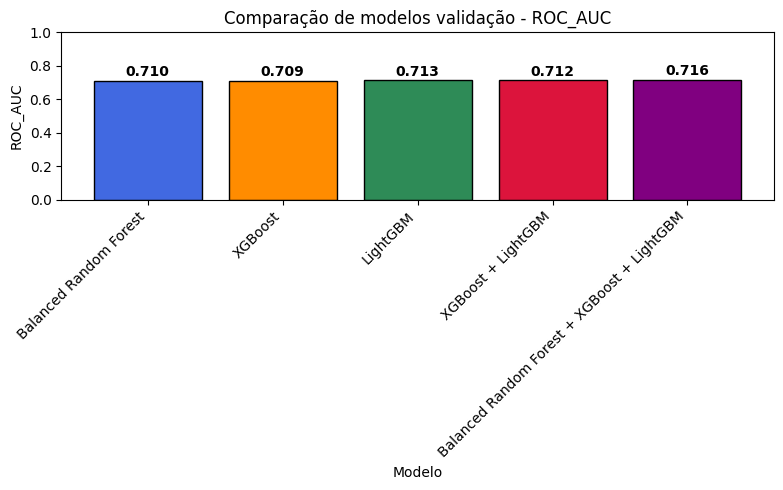

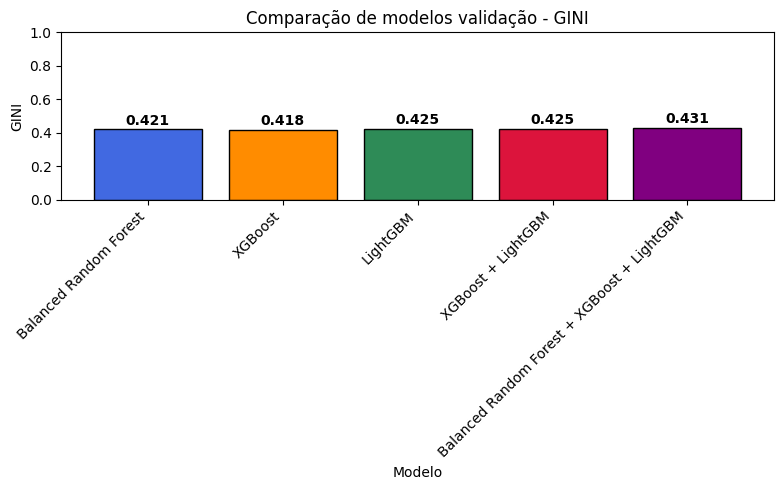

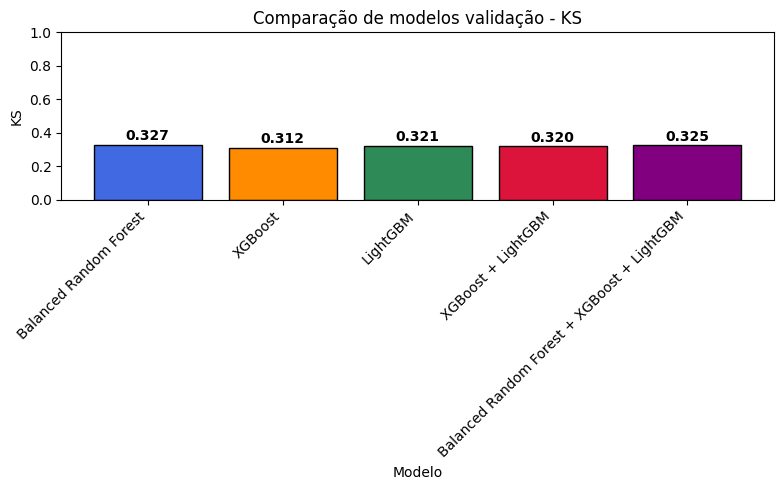

In [ ]:
# Definir as métricas que queremos plotar
metricas = ["roc_auc", "gini", "ks"]

# Definir cores para cada modelo
cores = {
    "Balanced Random Forest": "royalblue",
    "XGBoost": "darkorange",
    "LightGBM": "seagreen",
    "XGBoost + LightGBM": "crimson",
    "Balanced Random Forest + XGBoost + LightGBM": "purple"
}

# Criar 3 gráficos (um para cada métrica)
for metrica in metricas:
    plt.figure(figsize=(8,5))

    # Pegar as cores correspondentes aos modelos
    colors = [cores[m] for m in resultados2_treino["modelo"]]

    bars = plt.bar(resultados2_treino["modelo"], resultados2_treino[metrica],
                   color=colors, edgecolor="black")

    # Adicionar os valores acima de cada barra
    for bar, valor in zip(bars, resultados2_treino[metrica]):
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.01,
                 f"{valor:.3f}",
                 ha="center", va="bottom", fontsize=10, fontweight="bold")

    plt.title(f"Comparação de modelos validação - {metrica.upper()}")
    plt.xlabel("Modelo")
    plt.ylabel(metrica.upper())
    plt.ylim(0, 1)  # eixo y entre 0 e 1
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

### Análise para o teste

In [ ]:
resultados2_teste

modelo   roc_auc      gini        ks
0  Teste Balanced Random Forest - Base Original  0.709920  0.419840  0.318934
1                 Teste XGBoost - Base Original  0.711204  0.422409  0.322507
2                Teste LightGBM - Base Original  0.714112  0.428225  0.325426
3           Teste Ensemble (LightGBM + XGBoost)  0.714470  0.428940  0.330383
4     Teste Ensemble (LightGBM + XGBoost + BRF)  0.716618  0.433236  0.331096

In [ ]:
# Novos nomes para a coluna 'modelo'
nome_modelo = [
    'Balanced Random Forest',
    'XGBoost',
    'LightGBM',
    'XGBoost + LightGBM',
    'Balanced Random Forest + XGBoost + LightGBM'
]

# Atribuindo a nova lista à coluna
resultados2_teste['modelo'] = nome_modelo

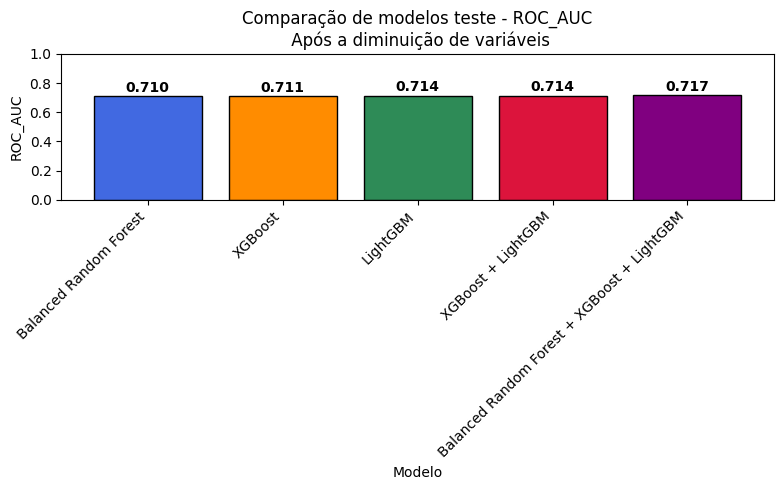

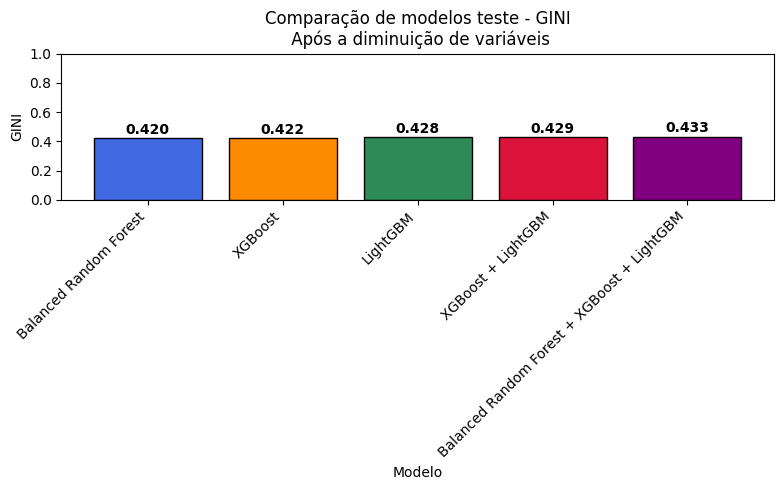

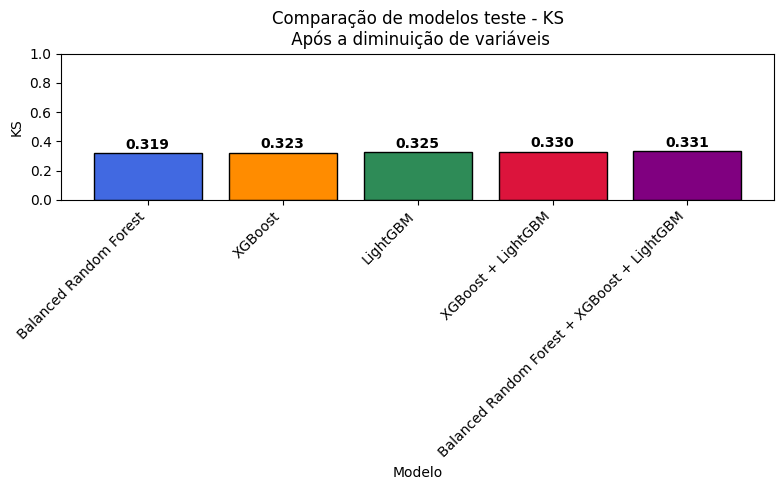

In [ ]:
# Definir as métricas que queremos plotar
metricas = ["roc_auc", "gini", "ks"]

# Definir cores para cada modelo
cores = {
    "Balanced Random Forest": "royalblue",
    "XGBoost": "darkorange",
    "LightGBM": "seagreen",
    "XGBoost + LightGBM": "crimson",
    "Balanced Random Forest + XGBoost + LightGBM": "purple"
}

# Criar 3 gráficos (um para cada métrica)
for metrica in metricas:
    plt.figure(figsize=(8,5))

    # Pegar as cores correspondentes aos modelos
    colors = [cores[m] for m in resultados2_teste["modelo"]]

    bars = plt.bar(resultados2_teste["modelo"], resultados2_teste[metrica],
                   color=colors, edgecolor="black")

    # Adicionar os valores acima de cada barra
    for bar, valor in zip(bars, resultados2_teste[metrica]):
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.01,
                 f"{valor:.3f}",
                 ha="center", va="bottom", fontsize=10, fontweight="bold")

    plt.title(f"Comparação de modelos teste - {metrica.upper()}\n Após a diminuição de variáveis")
    plt.xlabel("Modelo")
    plt.ylabel(metrica.upper())
    plt.ylim(0, 1)  # eixo y entre 0 e 1
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()